In [1]:
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

#to display images
from IPython.display import Image

#for normalize df function
from functools import reduce

#for data analysis
from sklearn.cluster import KMeans
from sklearn import preprocessing
import scipy.stats as stats
from scipy.spatial import distance

#to calculate power values
import pandapower as pp
import pandapower.shortcircuit as sc

#to draw electric diagram
import SchemDraw
import SchemDraw.elements as e

#for pv power calculation
import pvlib

#for wind power calculation
from windpowerlib.wind_turbine import WindTurbine
from windpowerlib.modelchain import ModelChain

import networkx as nx

from omegalpes.general.time import TimeUnit
from omegalpes.energy.units.production_units import FixedProductionUnit, VariableProductionUnit
from omegalpes.energy.units.consumption_units import FixedConsumptionUnit, VariableConsumptionUnit
from omegalpes.energy.energy_types import elec
from omegalpes.energy.units.storage_units import StorageUnit
from omegalpes.energy.energy_nodes import EnergyNode
from omegalpes.general.optimisation.model import OptimisationModel
from pulp import LpStatus, PULP_CBC_CMD, GLPK_CMD, COIN_CMD, GUROBI_CMD, GUROBI
work_path = os.getcwd()
from omegalpes.general.utils.plots import plot_quantity

In [2]:
#function to normalize values in a dataframe
def normalize_dfs(*arg):
    dfs = []
    for i in range(len(arg)):
        dfs.append(arg[i])   
    df_final = reduce(lambda left,right: pd.merge(left, right, left_index=True, right_index=True), dfs)
    array = df_final.values #returns a numpy array
    min_max_scaler = preprocessing.MinMaxScaler()
    scaled = min_max_scaler.fit_transform(array)
    normalized = pd.DataFrame(scaled)
    return normalized

In [3]:
#functions to separate data into groups
def k_means_3(data, clusters):
    algthm = KMeans(n_clusters=3, random_state=1)
    algthm.fit(data)
    return algthm.labels_
def k_means_2(data, clusters):
    algthm = KMeans(n_clusters=2, random_state=1)
    algthm.fit(data)
    return algthm.labels_

In [4]:
#functions to get weather for power from renewables
def get_weather_data(filename='weather.csv', **kwargs):
    if 'datapath' not in kwargs:
        kwargs['datapath'] = os.path.join(os.path.split(
            os.path.dirname(__file__))[0], 'example')
    file = os.path.join(kwargs['datapath'], filename)
    # read csv file 
    weather_df = pd.read_csv(
        file, index_col=0, header=[0, 1],
        date_parser=lambda idx: pd.to_datetime(idx, utc=True))
    # change type of index to datetime and set time zone
    weather_df.index = pd.to_datetime(weather_df.index).tz_convert(
        'Europe/Berlin')
    # change type of height from str to int by resetting columns
    l0 = [_[0] for _ in weather_df.columns]
    l1 = [int(_[1]) for _ in weather_df.columns]
    weather_df.columns = [l0, l1]
    
    return weather_df

<font size="6" color='red'>General Information</font>

<font size="5" color='blue'>Diagram</font>

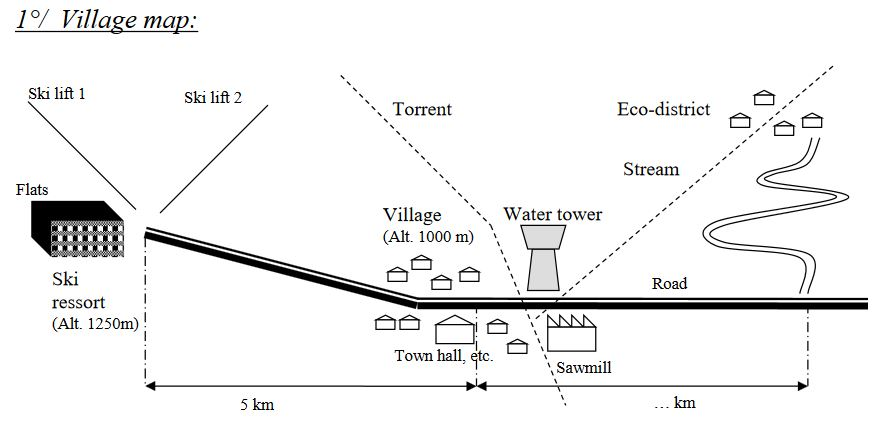

In [5]:
Image(filename='imgs/design_village.jpg') 

<font size="5" color='blue'>Location</font>

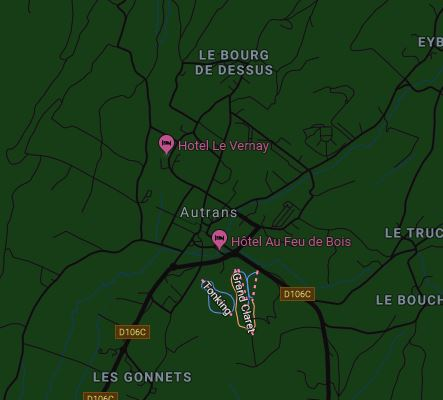

In [6]:
Image(filename='imgs/location_village.jpg') 

<font size="5" color='blue'>Geographical Data</font>

In [7]:
#data from the zone
latitude, longitude, name, altitude, timezone = (45.1996958, 5.5609121, 'Autrans', 1213, ' UTC+01:00')
#rng = rng.tz_localize(timezone)

<font size="5" color='blue'>Time periods</font>

In [8]:
initial_period = '2010-01-01'
final_period = '2011-01-01'

#rngs for dataframes
rng = pd.date_range(initial_period, final_period, freq="1h")
rng = rng[:-1]
rng_days = pd.date_range(initial_period, final_period, freq="d") 
rng_days = rng_days[:-1]

#needed for calculations
first_day = rng_days[0].strftime('%Y-%m-%d')
last_day = rng_days[-1].strftime('%Y-%m-%d')

<font size="5" color='blue'>Lines</font>

In [9]:
line_overhead = {
    "Name":"Line Overhead",
    "Lenght(km)": 8,
    "Rated voltage(kV)": 20,
    "Cross section(mm2)": 150,
    "SC power available: at substation(kV)":[(63,20)],
    "SC power available: at substation(MVA)":500
}
line_ski_resort = {
    "Name":"Line Ski-resort",
    "Lenght(km)": 5, 
}
df_lines = pd.concat([pd.DataFrame(line_overhead),pd.DataFrame(line_ski_resort, index=[1])], sort=False)
df_lines = df_lines.replace(np.nan, '', regex=True)
df_lines.set_index('Name',inplace=True)
#df_lines.loc[''] = [5, "", "", "", ""]
df_lines 

,Lenght(km),Rated voltage(kV),Cross section(mm2),SC power available: at substation(kV),SC power available: at substation(MVA)
Name,,,,,
Line Overhead,8,20,150,"(63, 20)",500
Line Ski-resort,5,,,,


<font size="6" color='red'>Temperature</font>

The outdoor temperature of the village can be measured by a small weather station  for the period to be analyzed.

In [10]:
df_temperature_village = pd.read_csv('data/Temperature_2010_1h.txt', sep=" ", header=None, names=["Temperature(Cº)"])
df_temperature_village.set_index(rng,inplace=True)
df_temperature_village.head()

,Temperature(Cº)
2010-01-01 00:00:00,2.41726
2010-01-01 01:00:00,1.91726
2010-01-01 02:00:00,1.41726
2010-01-01 03:00:00,0.91726
2010-01-01 04:00:00,0.51726


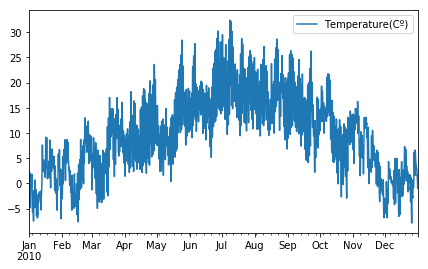

In [11]:
plt.figure()
df_temperature_village["Temperature(Cº)"].plot()
plt.legend()
plt.show()

<font size="6" color='red'>Village</font>

<font size="5" color='blue'>Load</font>

In [12]:
df_load_village = pd.read_csv('data/P_village_2010_1h.txt', sep=" ", header=None, names=["Consumption(kW)"])
df_load_village["Consumption(kW)"] = df_load_village["Consumption(kW)"]/1000 
df_load_village.set_index(rng,inplace=True)
df_load_village.head()

,Consumption(kW)
2010-01-01 00:00:00,940.530929
2010-01-01 01:00:00,1142.461898
2010-01-01 02:00:00,1030.934375
2010-01-01 03:00:00,994.541547
2010-01-01 04:00:00,882.703122


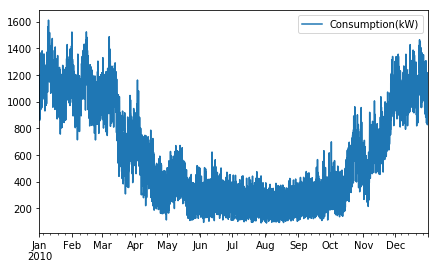

In [13]:
plt.figure()
df_load_village["Consumption(kW)"].plot()
plt.legend()
plt.show()

<font size="5" color='blue'>Load vs Temperature</font>

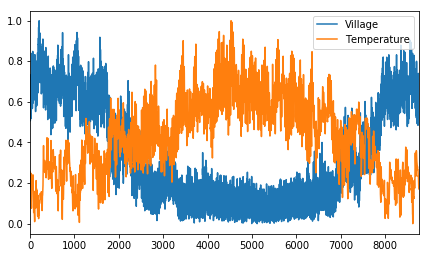

In [14]:
normalized_temperature_load_village = normalize_dfs(df_load_village["Consumption(kW)"],df_temperature_village)
normalized_temperature_load_village.columns = ["Village","Temperature"]
normalized_temperature_load_village.plot();

<font size="5" color='blue'>Consumption per day</font>

In [15]:
load_day_village = []
for date in rng_days: load_day_village.append((df_load_village['Consumption(kW)'][date.strftime('%Y-%m-%d')].sum()))
#create dataframe
df_load_day_village = pd.DataFrame(load_day_village, columns=['Consumption(kW)'])
df_load_day_village.set_index(rng_days, inplace=True)
df_load_day_village.head()

,Consumption(kW)
2010-01-01,24435.409103
2010-01-02,26932.748182
2010-01-03,26479.418250
2010-01-04,28135.490559
2010-01-05,28253.477939


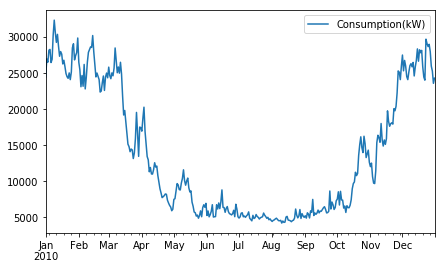

In [16]:
plt.figure()
df_load_day_village["Consumption(kW)"].plot()
plt.legend()
plt.show()

<font size="5" color='blue'>Seasons of the year</font>

<font size="4" color='yellow'>Clustering</font>

In [17]:
df_load_day_village['cluster'] = k_means_3(np.array(load_day_village).reshape(-1, 1), 3)

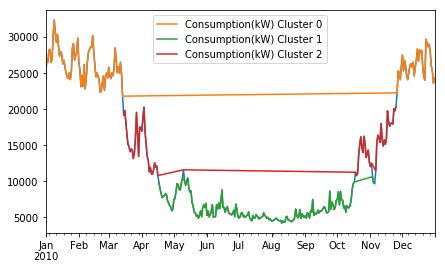

In [18]:
plt.figure()
df_load_day_village['Consumption(kW)'].plot(label='')
df_load_day_village['Consumption(kW)'][df_load_day_village['cluster']==0].plot(label='Consumption(kW) Cluster 0')
df_load_day_village['Consumption(kW)'][df_load_day_village['cluster']==1].plot(label='Consumption(kW) Cluster 1')
df_load_day_village['Consumption(kW)'][df_load_day_village['cluster']==2].plot(label='Consumption(kW) Cluster 2')
plt.legend()
plt.show()

<font size="4" color='yellow'>Separation</font>

In [19]:
#select first/final days for seasons
begin_transition1_village = df_load_day_village['Consumption(kW)'][df_load_day_village['cluster']==2]['2010-03'].index[0].strftime('%Y-%m-%d')
end_transition1_village = df_load_day_village['Consumption(kW)'][df_load_day_village['cluster']==2]['2010-04'].index[-1].strftime('%Y-%m-%d')
begin_transition2_village = df_load_day_village['Consumption(kW)'][df_load_day_village['cluster']==2]['2010-10'].index[0].strftime('%Y-%m-%d')
end_transition2_village = df_load_day_village['Consumption(kW)'][df_load_day_village['cluster']==2]['2010-11'].index[-1].strftime('%Y-%m-%d')
begin_winter_village = (pd.date_range(end_transition2_village, periods=1, freq='D')+1)[0].strftime('%Y-%m-%d')
end_winter_village = (pd.date_range(begin_transition1_village, periods=1, freq='D')-1)[0].strftime('%Y-%m-%d')
begin_summer_village = (pd.date_range(end_transition1_village, periods=1, freq='D')+1)[0].strftime('%Y-%m-%d')
end_summer_village = (pd.date_range(begin_transition2_village, periods=1, freq='D')-1)[0].strftime('%Y-%m-%d')

#create dataframes for seasons
df_summer_day_village = df_load_day_village[begin_summer_village:end_summer_village]['Consumption(kW)'].to_frame()
df_winter_day_village = pd.concat([df_load_day_village[first_day:end_winter_village]['Consumption(kW)'].to_frame(), df_load_day_village[begin_winter_village:last_day]['Consumption(kW)'].to_frame()])
df_transition_day_village = pd.concat([df_load_day_village[begin_transition1_village:end_transition1_village]['Consumption(kW)'].to_frame(), df_load_day_village[begin_transition2_village:end_transition2_village]['Consumption(kW)'].to_frame()])

D:\Programs\Anaconda3\lib\site-packages\pandas\core\arrays\datetimelike.py:1197: FutureWarning: Addition/subtraction of integers and integer-arrays to DatetimeArray is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  maybe_integer_op_deprecated(self)
D:\Programs\Anaconda3\lib\site-packages\pandas\core\arrays\datetimelike.py:1260: FutureWarning: Addition/subtraction of integers and integer-arrays to DatetimeArray is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  maybe_integer_op_deprecated(self)


<font size="5" color='blue'>Summer</font>

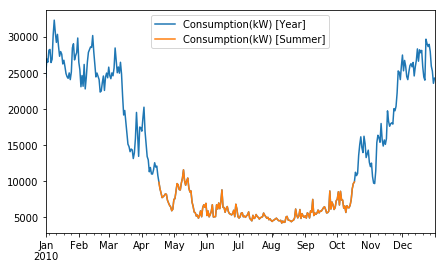

In [20]:
plt.figure()
df_load_day_village["Consumption(kW)"].plot(label='Consumption(kW) [Year]')
df_summer_day_village["Consumption(kW)"].plot(label='Consumption(kW) [Summer]')
plt.legend()
plt.show()

<font size="4" color='yellow'>Eucledian Distance</font>

In [21]:
min_euclidean_day_summer_village = 9999999999
most_common_consumption_day_summer_village = 0
for day1 in df_summer_day_village.index:
    euclidean_summer_village = 0
    for day2 in df_summer_day_village.index: euclidean_summer_village += distance.euclidean(df_load_village[day1.strftime('%Y-%m-%d')]['Consumption(kW)'].values, df_load_village[day2.strftime('%Y-%m-%d')]['Consumption(kW)'].values)
    if euclidean_summer_village < min_euclidean_day_summer_village:
        min_euclidean_day_summer_village = euclidean_summer_village
        most_common_consumption_day_summer_village = day1.strftime('%Y-%m-%d')

<font size="4" color='yellow'>Comparison days</font>

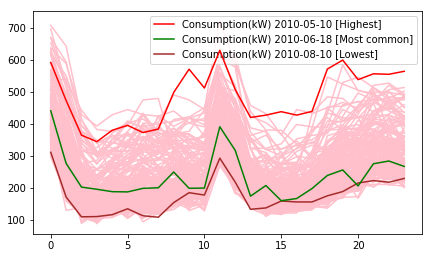

In [22]:
highest_consumption_day_summer_village = df_summer_day_village.idxmax()[0].strftime("%Y-%m-%d")
lowest_consumption_day_summer_village = df_summer_day_village.idxmin()[0].strftime("%Y-%m-%d")
plt.figure()
for day in df_summer_day_village.index:
    if day.strftime("%Y-%m-%d") == most_common_consumption_day_summer_village:
        plt.plot(df_load_village[day.strftime("%Y-%m-%d")]['Consumption(kW)'].values, color='green', zorder=99999, label='Consumption(kW) '+most_common_consumption_day_summer_village+' [Most common]')
    elif day.strftime("%Y-%m-%d") == highest_consumption_day_summer_village:
        plt.plot(df_load_village[day.strftime("%Y-%m-%d")]['Consumption(kW)'].values, color='red', zorder=99997, label='Consumption(kW) '+highest_consumption_day_summer_village+' [Highest]')
    elif day.strftime("%Y-%m-%d") == lowest_consumption_day_summer_village:
        plt.plot(df_load_village[day.strftime("%Y-%m-%d")]['Consumption(kW)'].values, color='brown', zorder=99996, label='Consumption(kW) '+lowest_consumption_day_summer_village+' [Lowest]')
    else:
        plt.plot(df_load_village[day.strftime("%Y-%m-%d")]['Consumption(kW)'].values, color='pink')
plt.legend()
plt.show()

In [23]:
days_summer_village = [most_common_consumption_day_summer_village,highest_consumption_day_summer_village,lowest_consumption_day_summer_village]
df_summer_day_village.query('@df_summer_day_village.index.normalize() in @days_summer_village')

,Consumption(kW)
2010-05-10,11593.266148
2010-06-18,5713.691280
2010-08-10,4227.647921


<font size="5" color='blue'>Winter</font>

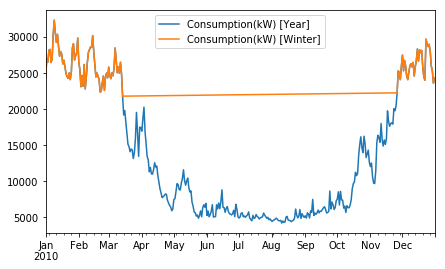

In [24]:
plt.figure()
df_load_day_village["Consumption(kW)"].plot(label='Consumption(kW) [Year]')
df_winter_day_village["Consumption(kW)"].plot(label='Consumption(kW) [Winter]')
plt.legend()
plt.show()

<font size="4" color='yellow'>Eucledian Distance</font>

In [25]:
min_euclidean_day_winter_village = 9999999999
most_common_consumption_day_winter_village = 0
for day1 in df_winter_day_village.index:
    euclidean_winter_village = 0
    for day2 in df_winter_day_village.index: euclidean_winter_village += distance.euclidean(df_load_village[day1.strftime('%Y-%m-%d')]['Consumption(kW)'].values, df_load_village[day2.strftime('%Y-%m-%d')]['Consumption(kW)'].values)
    if euclidean_winter_village < min_euclidean_day_winter_village:
        min_euclidean_day_winter_village = euclidean_winter_village
        most_common_consumption_day_winter_village = day1.strftime('%Y-%m-%d')

<font size="4" color='yellow'>Comparison days</font>

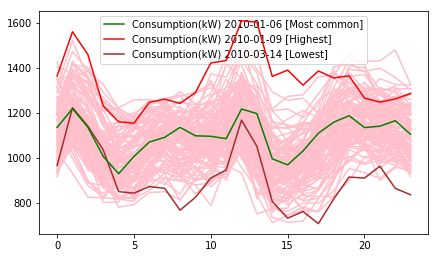

In [26]:
highest_consumption_day_winter_village = df_winter_day_village.idxmax()[0].strftime("%Y-%m-%d")
lowest_consumption_day_winter_village = df_winter_day_village.idxmin()[0].strftime("%Y-%m-%d")
plt.figure()
for day in df_winter_day_village.index:
    if day.strftime("%Y-%m-%d") == most_common_consumption_day_winter_village:
        plt.plot(df_load_village[day.strftime("%Y-%m-%d")]['Consumption(kW)'].values, color='green', zorder=99999, label='Consumption(kW) '+most_common_consumption_day_winter_village+' [Most common]')
    elif day.strftime("%Y-%m-%d") == highest_consumption_day_winter_village:
        plt.plot(df_load_village[day.strftime("%Y-%m-%d")]['Consumption(kW)'].values, color='red', zorder=99997, label='Consumption(kW) '+highest_consumption_day_winter_village+' [Highest]')
    elif day.strftime("%Y-%m-%d") == lowest_consumption_day_winter_village:
        plt.plot(df_load_village[day.strftime("%Y-%m-%d")]['Consumption(kW)'].values, color='brown', zorder=99996, label='Consumption(kW) '+lowest_consumption_day_winter_village+' [Lowest]')
    else:
        plt.plot(df_load_village[day.strftime("%Y-%m-%d")]['Consumption(kW)'].values, color='pink')
plt.legend()
plt.show()

In [27]:
days_winter_village = [most_common_consumption_day_winter_village, highest_consumption_day_winter_village,lowest_consumption_day_winter_village]
df_winter_day_village.query('@df_winter_day_village.index.normalize() in @days_winter_village')

,Consumption(kW)
2010-01-06,26433.214731
2010-01-09,32299.248082
2010-03-14,21783.914357


<font size="5" color='blue'>Transition</font>

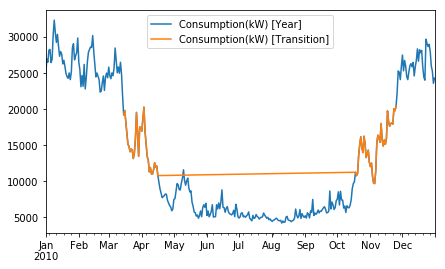

In [28]:
plt.figure()
df_load_day_village["Consumption(kW)"].plot(label='Consumption(kW) [Year]')
df_transition_day_village["Consumption(kW)"].plot(label='Consumption(kW) [Transition]')
plt.legend()
plt.show()

<font size="4" color='yellow'>Eucledian Distance</font>

In [29]:
min_euclidean_day_transition_village = 9999999999
most_common_consumption_day_transition_village = 0
for day1 in df_transition_day_village.index:
    euclidean_transition_village = 0
    for day2 in df_transition_day_village.index: euclidean_transition_village += distance.euclidean(df_load_village[day1.strftime('%Y-%m-%d')]['Consumption(kW)'].values, df_load_village[day2.strftime('%Y-%m-%d')]['Consumption(kW)'].values)
    if euclidean_transition_village < min_euclidean_day_transition_village:
        min_euclidean_day_transition_village = euclidean_transition_village
        most_common_consumption_day_transition_village = day1.strftime('%Y-%m-%d')

<font size="4" color='yellow'>Comparison days</font>

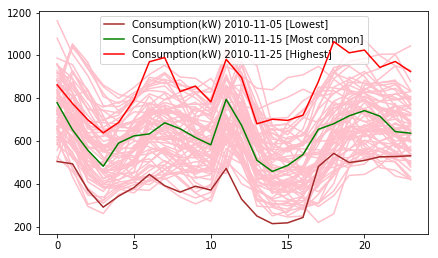

In [30]:
highest_consumption_day_transition_village = df_transition_day_village.idxmax()[0].strftime("%Y-%m-%d")
lowest_consumption_day_transition_village = df_transition_day_village.idxmin()[0].strftime("%Y-%m-%d")
plt.figure()
for day in df_transition_day_village.index:
    if day.strftime("%Y-%m-%d") == most_common_consumption_day_transition_village:
        plt.plot(df_load_village[day.strftime("%Y-%m-%d")]['Consumption(kW)'].values, color='green', zorder=99999, label='Consumption(kW) '+most_common_consumption_day_transition_village+' [Most common]')
    elif day.strftime("%Y-%m-%d") == highest_consumption_day_transition_village:
        plt.plot(df_load_village[day.strftime("%Y-%m-%d")]['Consumption(kW)'].values, color='red', zorder=99997, label='Consumption(kW) '+highest_consumption_day_transition_village+' [Highest]')
    elif day.strftime("%Y-%m-%d") == lowest_consumption_day_transition_village:
        plt.plot(df_load_village[day.strftime("%Y-%m-%d")]['Consumption(kW)'].values, color='brown', zorder=99996, label='Consumption(kW) '+lowest_consumption_day_transition_village+' [Lowest]')
    else:
        plt.plot(df_load_village[day.strftime("%Y-%m-%d")]['Consumption(kW)'].values, color='pink')
plt.legend()
plt.show()

In [31]:
days_transition_village = [most_common_consumption_day_transition_village, highest_consumption_day_transition_village, lowest_consumption_day_transition_village]
df_transition_day_village.query('@df_transition_day_village.index.normalize() in @days_transition_village')

,Consumption(kW)
2010-11-05,9690.872946
2010-11-15,15112.471622
2010-11-25,20380.657341


<font size="5" color='blue'>Transformers</font>

In [32]:
max_consumption_village = df_load_village.max().values[0]
max_consumption_time_village = df_load_village.idxmax()[0].strftime("%Y-%m-%d %H:%M:%S")
print("The max consumption is ", max_consumption_village, "kVA at ", max_consumption_time_village)

The max consumption is  1610.6460453979998 kVA at  2010-01-09 12:00:00


In [33]:
transformers_village = [
    {"Name":"Transformer(1)",'Percentage':40},
    {"Name":"Transformer(2)",'Percentage':40},
    {"Name":"Transformer(3)",'Percentage':20},
]
df_transformers_village = pd.DataFrame(transformers_village, columns=['Name','Percentage'])
df_transformers_village["(kVA)"] = df_transformers_village["Percentage"]/100*max_consumption_village
df_transformers_village["(kW)"] = df_transformers_village["(kVA)"]*.8
df_transformers_village["(kVAr)"] = df_transformers_village["(kVA)"]*math.sin(math.acos(.8))
df_transformers_village.set_index('Name',inplace=True)
df_transformers_village

,Percentage,(kVA),(kW),(kVAr)
Name,,,,
Transformer(1),40,644.258418,515.406735,386.555051
Transformer(2),40,644.258418,515.406735,386.555051
Transformer(3),20,322.129209,257.703367,193.277525


<font size="6" color='red'>Ski-resort</font>

<font size="5" color='blue'>Load</font>

In [34]:
df_load_ski_resort = pd.read_csv('data/P_ski station_2010_1h.txt', sep=" ", header=None, names=["Consumption(kW)"])
df_load_ski_resort["Consumption(kW)"] = df_load_ski_resort["Consumption(kW)"]/1000 
df_load_ski_resort.set_index(rng,inplace=True)
df_load_ski_resort.head()

,Consumption(kW)
2010-01-01 00:00:00,48.155106
2010-01-01 01:00:00,54.728584
2010-01-01 02:00:00,56.447571
2010-01-01 03:00:00,57.650476
2010-01-01 04:00:00,67.961215


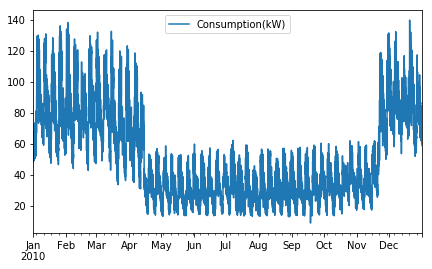

In [35]:
plt.figure()
df_load_ski_resort["Consumption(kW)"].plot()
plt.legend()
plt.show()

<font size="5" color='blue'>Load vs Temperature</font>

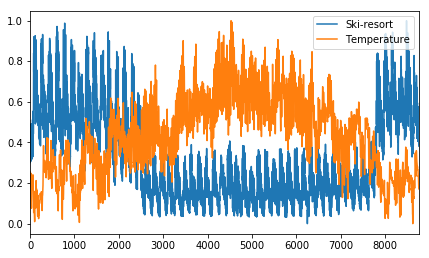

In [36]:
normalized_temperature_load_ski_resort = normalize_dfs(df_load_ski_resort["Consumption(kW)"],df_temperature_village)
normalized_temperature_load_ski_resort.columns = ["Ski-resort","Temperature"]
normalized_temperature_load_ski_resort.plot();

<font size="5" color='blue'>Consumption per day</font>

In [37]:
load_day_ski_resort = []
for date in rng_days: load_day_ski_resort.append((df_load_ski_resort['Consumption(kW)'][date.strftime('%Y-%m-%d')].sum()))
#create dataframe
df_load_day_ski_resort = pd.DataFrame(load_day_ski_resort, columns=['Consumption(kW)'])
df_load_day_ski_resort.set_index(rng_days, inplace=True)
df_load_day_ski_resort.head()

,Consumption(kW)
2010-01-01,1308.824046
2010-01-02,1424.609362
2010-01-03,1534.597307
2010-01-04,2375.492434
2010-01-05,2664.456523


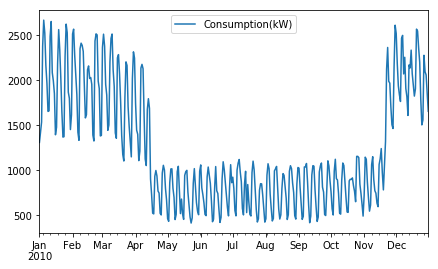

In [38]:
plt.figure()
df_load_day_ski_resort["Consumption(kW)"].plot()
plt.legend()
plt.show()

<font size="5" color='blue'>Seasons of the year</font>

<font size="4" color='yellow'>Clustering</font>

In [39]:
df_load_day_ski_resort['cluster'] = k_means_2(np.array(load_day_ski_resort).reshape(-1, 1), 2)

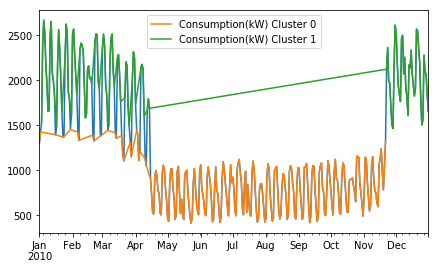

In [40]:
plt.figure()
df_load_day_ski_resort['Consumption(kW)'].plot(label='')
df_load_day_ski_resort['Consumption(kW)'][df_load_day_ski_resort['cluster']==0].plot(label='Consumption(kW) Cluster 0')
df_load_day_ski_resort['Consumption(kW)'][df_load_day_ski_resort['cluster']==1].plot(label='Consumption(kW) Cluster 1')
plt.legend()
plt.show()

<font size="4" color='yellow'>Separation</font>

In [41]:
#select first/final days for seasons
begin_summer_ski_resort = df_load_day_ski_resort['Consumption(kW)'][df_load_day_ski_resort['cluster']==0]['2010-4'][df_load_day_ski_resort['Consumption(kW)']<1000].index[0].strftime('%Y-%m-%d')
end_summer_ski_resort = df_load_day_ski_resort['Consumption(kW)'][df_load_day_ski_resort['cluster']==0]['2010-11'].index[-1].strftime('%Y-%m-%d')
begin_winter_ski_resort = (pd.date_range(end_summer_ski_resort, periods=1, freq='D')+1)[0].strftime('%Y-%m-%d')
end_winter_ski_resort = (pd.date_range(begin_summer_ski_resort, periods=1, freq='D')-1)[0].strftime('%Y-%m-%d')
#create dataframes for seasons
df_summer_day_ski_resort = df_load_day_ski_resort[begin_summer_ski_resort:end_summer_ski_resort]['Consumption(kW)'].to_frame()
df_winter_day_ski_resort = pd.concat([df_load_day_ski_resort[first_day:end_winter_ski_resort]['Consumption(kW)'].to_frame(), df_load_day_ski_resort[begin_winter_ski_resort:last_day]['Consumption(kW)'].to_frame()])

D:\Programs\Anaconda3\lib\site-packages\pandas\core\arrays\datetimelike.py:1197: FutureWarning: Addition/subtraction of integers and integer-arrays to DatetimeArray is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  maybe_integer_op_deprecated(self)
D:\Programs\Anaconda3\lib\site-packages\pandas\core\arrays\datetimelike.py:1260: FutureWarning: Addition/subtraction of integers and integer-arrays to DatetimeArray is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  maybe_integer_op_deprecated(self)


<font size="5" color='blue'>Summer</font>

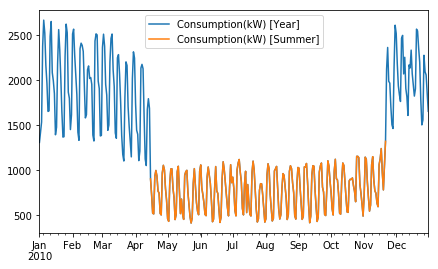

In [42]:
plt.figure()
df_load_day_ski_resort["Consumption(kW)"].plot(label='Consumption(kW) [Year]')
df_summer_day_ski_resort["Consumption(kW)"].plot(label='Consumption(kW) [Summer]')
plt.legend()
plt.show()

<font size="4" color='yellow'>Eucledian Distance</font>

In [43]:
min_euclidean_day_summer_ski_resort = 9999999999
most_common_consumption_day_summer_ski_resort = 0
for day1 in df_summer_day_ski_resort.index:
    euclidean_summer_ski_resort = 0
    for day2 in df_summer_day_ski_resort.index: euclidean_summer_ski_resort += distance.euclidean(df_load_ski_resort[day1.strftime('%Y-%m-%d')]['Consumption(kW)'].values, df_load_ski_resort[day2.strftime('%Y-%m-%d')]['Consumption(kW)'].values)
    if euclidean_summer_ski_resort < min_euclidean_day_summer_ski_resort:
        min_euclidean_day_summer_ski_resort = euclidean_summer_ski_resort
        most_common_consumption_day_summer_ski_resort = day1.strftime('%Y-%m-%d')

<font size="4" color='yellow'>Comparison days</font>

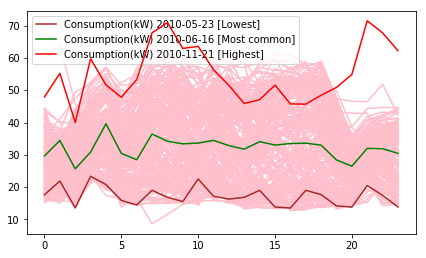

In [44]:
highest_consumption_day_summer_ski_resort = df_summer_day_ski_resort.idxmax()[0].strftime("%Y-%m-%d")
lowest_consumption_day_summer_ski_resort = df_summer_day_ski_resort.idxmin()[0].strftime("%Y-%m-%d")
plt.figure()
for day in df_summer_day_ski_resort.index:
    if day.strftime("%Y-%m-%d") == most_common_consumption_day_summer_ski_resort:
        plt.plot(df_load_ski_resort[day.strftime("%Y-%m-%d")]['Consumption(kW)'].values, color='green', zorder=99999, label='Consumption(kW) '+most_common_consumption_day_summer_ski_resort+' [Most common]')
    elif day.strftime("%Y-%m-%d") == highest_consumption_day_summer_ski_resort:
        plt.plot(df_load_ski_resort[day.strftime("%Y-%m-%d")]['Consumption(kW)'].values, color='red', zorder=99997, label='Consumption(kW) '+highest_consumption_day_summer_ski_resort+' [Highest]')
    elif day.strftime("%Y-%m-%d") == lowest_consumption_day_summer_ski_resort:
        plt.plot(df_load_ski_resort[day.strftime("%Y-%m-%d")]['Consumption(kW)'].values, color='brown', zorder=99996, label='Consumption(kW) '+lowest_consumption_day_summer_ski_resort+' [Lowest]')
    else:
        plt.plot(df_load_ski_resort[day.strftime("%Y-%m-%d")]['Consumption(kW)'].values, color='pink')
plt.legend()
plt.show()

In [45]:
days_summer_ski_resort = [most_common_consumption_day_summer_ski_resort, highest_consumption_day_summer_ski_resort, lowest_consumption_day_summer_ski_resort]
df_summer_day_ski_resort.query('@df_summer_day_ski_resort.index.normalize() in @days_summer_ski_resort')

,Consumption(kW)
2010-05-23,414.994340
2010-06-16,772.617031
2010-11-21,1320.778116


<font size="5" color='blue'>Winter</font>

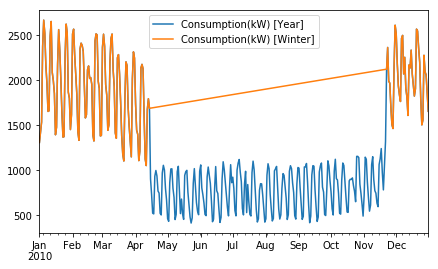

In [46]:
plt.figure()
df_load_day_ski_resort["Consumption(kW)"].plot(label='Consumption(kW) [Year]')
df_winter_day_ski_resort["Consumption(kW)"].plot(label='Consumption(kW) [Winter]')
plt.legend()
plt.show()

<font size="4" color='yellow'>Eucledian Distance</font>

In [47]:
min_euclidean_day_winter_ski_resort = 9999999999
most_common_consumption_day_winter_ski_resort = 0
for day1 in df_winter_day_ski_resort.index:
    euclidean_winter_ski_resort = 0
    for day2 in df_winter_day_ski_resort.index: euclidean_winter_ski_resort += distance.euclidean(df_load_ski_resort[day1.strftime('%Y-%m-%d')]['Consumption(kW)'].values, df_load_ski_resort[day2.strftime('%Y-%m-%d')]['Consumption(kW)'].values)
    if euclidean_winter_ski_resort < min_euclidean_day_winter_ski_resort:
        min_euclidean_day_winter_ski_resort = euclidean_winter_ski_resort
        most_common_consumption_day_winter_ski_resort = day1.strftime('%Y-%m-%d')

<font size="4" color='yellow'>Comparison days</font>

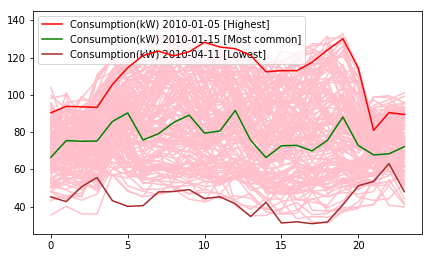

In [48]:
highest_consumption_day_winter_ski_resort = df_winter_day_ski_resort.idxmax()[0].strftime("%Y-%m-%d")
lowest_consumption_day_winter_ski_resort = df_winter_day_ski_resort.idxmin()[0].strftime("%Y-%m-%d")
plt.figure()
for day in df_winter_day_ski_resort.index:
    if day.strftime("%Y-%m-%d") == most_common_consumption_day_winter_ski_resort:
        plt.plot(df_load_ski_resort[day.strftime("%Y-%m-%d")]['Consumption(kW)'].values, color='green', zorder=99999, label='Consumption(kW) '+most_common_consumption_day_winter_ski_resort+' [Most common]')
    elif day.strftime("%Y-%m-%d") == highest_consumption_day_winter_ski_resort:
        plt.plot(df_load_ski_resort[day.strftime("%Y-%m-%d")]['Consumption(kW)'].values, color='red', zorder=99997, label='Consumption(kW) '+highest_consumption_day_winter_ski_resort+' [Highest]')
    elif day.strftime("%Y-%m-%d") == lowest_consumption_day_winter_ski_resort:
        plt.plot(df_load_ski_resort[day.strftime("%Y-%m-%d")]['Consumption(kW)'].values, color='brown', zorder=99996, label='Consumption(kW) '+lowest_consumption_day_winter_ski_resort+' [Lowest]')
    else:
        plt.plot(df_load_ski_resort[day.strftime("%Y-%m-%d")]['Consumption(kW)'].values, color='pink')
plt.legend()
plt.show()

In [49]:
days_winter_ski_resort = [most_common_consumption_day_winter_ski_resort, highest_consumption_day_winter_ski_resort, lowest_consumption_day_winter_ski_resort]
df_winter_day_ski_resort.query('@df_winter_day_ski_resort.index.normalize() in @days_winter_ski_resort')

,Consumption(kW)
2010-01-05,2664.456523
2010-01-15,1850.476642
2010-04-11,1052.349063


<font size="5" color='blue'>Transformers</font>

In [50]:
max_consumption_ski_resort = df_load_ski_resort.max().values[0]
max_consumption_time_ski_resort = df_load_ski_resort.idxmax()[0].strftime("%Y-%m-%d %H:%M:%S")
print("The max consumption is ", max_consumption_ski_resort, "kVA at ", max_consumption_time_ski_resort)

The max consumption is  139.77603775699998 kVA at  2010-12-20 09:00:00


In [51]:
transformers_ski_resort = [
    {"Name":"Transformer(1)",'Percentage':100},
]
df_transformers_ski_resort = pd.DataFrame(transformers_ski_resort, columns=['Name','Percentage'])
df_transformers_ski_resort["(kVA)"] = df_transformers_ski_resort["Percentage"]/100*max_consumption_ski_resort
df_transformers_ski_resort["(kW)"] = df_transformers_ski_resort["(kVA)"]*.8
df_transformers_ski_resort["(kVAr)"] = df_transformers_ski_resort["(kVA)"]*math.sin(math.acos(.8))
df_transformers_ski_resort.set_index('Name',inplace=True)
df_transformers_ski_resort

,Percentage,(kVA),(kW),(kVAr)
Name,,,,
Transformer(1),100,139.776038,111.82083,83.865623


<font size="6" color='red'>Village + Ski-resort</font>

In [52]:
df_load_village_ski_resort = pd.DataFrame()
df_load_village_ski_resort['Consumption(kW)']=df_load_village["Consumption(kW)"]+df_load_ski_resort["Consumption(kW)"]
df_load_village_ski_resort.head()

,Consumption(kW)
2010-01-01 00:00:00,988.686035
2010-01-01 01:00:00,1197.190483
2010-01-01 02:00:00,1087.381946
2010-01-01 03:00:00,1052.192024
2010-01-01 04:00:00,950.664338


In [53]:
max_consumption_village_ski_resort = df_load_village_ski_resort.max().values[0]
max_consumption_time_village_ski_resort = df_load_village_ski_resort.idxmax()[0].strftime("%Y-%m-%d %H:%M:%S")
print("The max consumption is ", max_consumption_village_ski_resort, "kVA at ", max_consumption_time_village_ski_resort)

The max consumption is  1682.0360042879997 kVA at  2010-01-09 12:00:00


<font size="5" color='blue'>Diagram of the system</font>

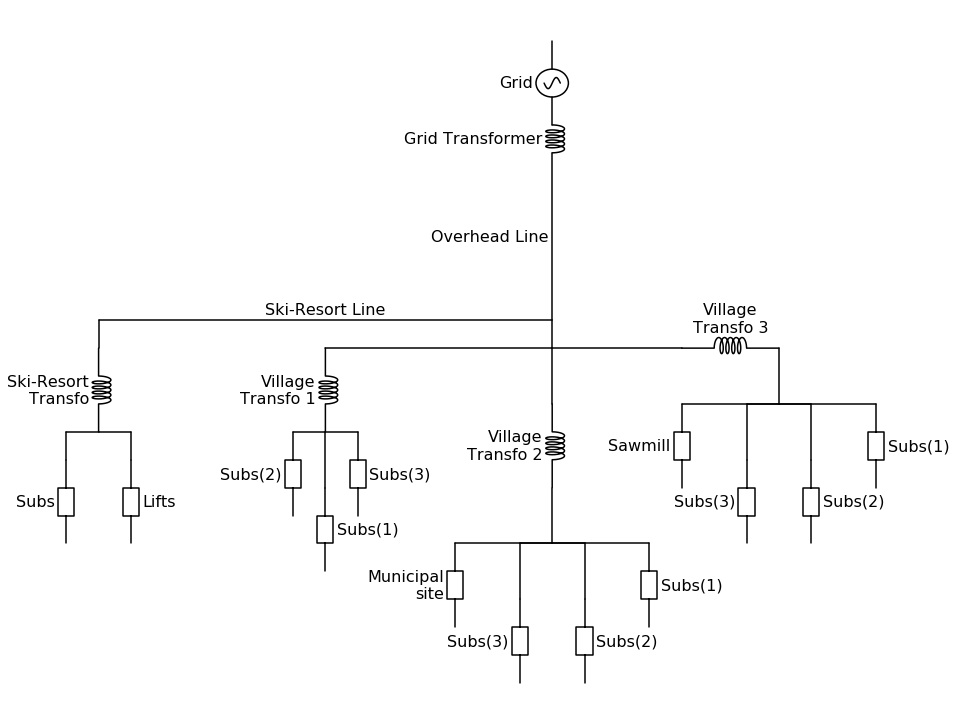

In [54]:
d = SchemDraw.Drawing()
#######################################overhead line elements#######################################
d.add(e.SOURCE_SIN, d='down', label='Grid')
d.add(e.INDUCTOR2, label='Grid Transformer', l=1)
d.add(e.LINE, label="Overhead Line", l=6)
d.push() #save point CONNECTION GRID
#######################################village elements#######################################
d.add(e.LINE, d='down', l=1)
#####Transfo 1#####
d.push() #save point VILLAGE TRANSFOS
d.add(e.LINE, d='left', l=7)
d.add(e.INDUCTOR2, d='down', label='Village\nTransfo 1', l=3)
##Load 1##
d.push() #save point TRANSFO #1
d.add(e.LINE, d='down', l=2)
d.add(e.RBOX, d='down', botlabel='Subs(1)')
d.pop() #return to the point TRANSFO #1
##Load 2##
d.push() #save point TRANSFO #1
d.add(e.LINE, d='left', l=1)
d.add(e.RBOX, d='down', label='Subs(2)')
d.pop() #return to the point TRANSFO #1
##Load 3##
d.add(e.LINE, d='right', l=1)
d.add(e.RBOX, d='down', botlabel='Subs(3)')
d.pop() #return to the point VILLAGE TRANSFOS
#####Transfo 2#####
d.push() #save point VILLAGE TRANSFOS
d.add(e.LINE, d='down', l=2)
d.add(e.INDUCTOR2, d='down', label='Village\nTransfo 2', l=3)
d.add(e.LINE, d='down', l=2)
##Load 1##
d.push() #save point TRANSFO #2
d.add(e.LINE, d='right', l=3)
d.add(e.RBOX, d='down', botlabel='Subs(1)')
d.pop() #return to the point TRANSFO #2
##Load 2##
d.push() #save point TRANSFO #2
d.add(e.LINE, d='right', l=1)
d.add(e.LINE, d='down', l=2)
d.add(e.RBOX, d='down', botlabel='Subs(2)')
d.pop() #return to the point TRANSFO #2
##Load 3##
d.push() #save point TRANSFO #2
d.add(e.LINE, d='left', l=3)
d.add(e.RBOX, d='down', label='Municipal\nsite')
d.pop() #return to the point TRANSFO #2
##Load 4##
d.add(e.LINE, d='left', l=1)
d.add(e.LINE, d='down', l=2)
d.add(e.RBOX, d='down', label='Subs(3)')
d.pop() #return to the point VILLAGE TRANSFOS
#####Transfo 3#####
d.add(e.LINE, d='right', l=4) #Transfo 3 line
d.add(e.INDUCTOR2, label='Village\nTransfo 3', l=3)
d.add(e.LINE, d='down', l=2)
##Load 1##
d.push() #save point TRANSFO #3
d.add(e.LINE, d='right', l=3)
d.add(e.RBOX, d='down', botlabel='Subs(1)')
d.pop() #return to the point TRANSFO #3
##Load 2##
d.push() #save point TRANSFO #3
d.add(e.LINE, d='right', l=1)
d.add(e.LINE, d='down', l=2)
d.add(e.RBOX, d='down', botlabel='Subs(2)')
d.pop() #return to the point TRANSFO #3
##Load 3##
d.push() #save point TRANSFO #3
d.add(e.LINE, d='left', l=3)
d.add(e.RBOX, d='down', label='Sawmill')
d.pop() #return to the point TRANSFO #3
##Load 4##
d.add(e.LINE, d='left', l=1)
d.add(e.LINE, d='down', l=2)
d.add(e.RBOX, d='down', label='Subs(3)')
d.pop() #return to the point VILLAGE TRANSFOS
########################################ski resort elements#######################################
d.pop() #return to the point CONNECTION GRID
d.push() #save point CONNECTION GRID
d.add(e.LINE, d='left', label="Ski-Resort Line", l=14)
d.add(e.LINE, d='down', l=1)
d.add(e.INDUCTOR2, label='Ski-Resort\nTransfo', l=3)
##Load 1##
d.push() #save point TRANSFO #1
d.add(e.LINE, d='left', l=1)
d.add(e.LINE, d='down', l=1)
d.add(e.RBOX, label='Subs')
d.pop() #return to the point TRANSFO #1
##Load 2##
d.add(e.LINE, d='right', l=1)
d.add(e.LINE, d='down', l=1)
d.add(e.RBOX, botlabel='Lifts')
d.pop() #return to the point CONNECTION GRID
d.draw()
d.save('imgs/line_diagram.eps')

<font size="5" color='blue'>Simulation of the Network</font>

In [55]:
net = pp.create_empty_network(name="Village")
buses={}
####################elements(overhead line)####################
#buses
buses['bus 0'] = pp.create_bus(net, vn_kv=63, name="Connection Grid")
buses['bus 1'] = pp.create_bus(net, vn_kv=20, name="Line Overhead")
buses['bus 2'] = pp.create_bus(net, vn_kv=20, name="Village")
#grid
pp.create_ext_grid(net, bus=buses['bus 0'], vm_pu=1.0, name="Grid")
#transformer
pp.create_transformer(net, hv_bus=buses['bus 0'], lv_bus=buses['bus 1'], std_type="25 MVA 110/20 kV", name="Transformer Grid")
#line
pp.create_line(net, from_bus=buses['bus 1'], to_bus=buses['bus 2'], length_km=line_overhead["Lenght(km)"], std_type="NA2XS2Y 1x150 RM/25 12/20 kV", name="Line Overhead")
####################elements(village)####################
#buses, transformers & loads
for idx, bus in enumerate(range(3,6)): 
    buses['bus {}'.format(bus)] = pp.create_bus(net, vn_kv=.4, name="Load Village {}".format(idx+1))
    pp.create_transformer(net, hv_bus=buses['bus 2'], lv_bus=buses['bus {}'.format(bus)], std_type="0.63 MVA 20/0.4 kV", name="Transformer Village {}".format(idx+1))
    pp.create_load(net, bus=buses['bus {}'.format(bus)], p_mw=df_transformers_village[df_transformers_village.index == "Transformer({})".format(idx+1)]["(kW)"].values[0]/1000, q_mvar=df_transformers_village[df_transformers_village.index == "Transformer({})".format(idx+1)]["(kVAr)"].values[0]/1000, name="Load Village {}".format(idx+1))
####################elements(ski resort)####################
#buses & lines
buses['bus 6'] = pp.create_bus(net, vn_kv=20, name="Line Ski-resort")
pp.create_line(net, from_bus=buses['bus 2'], to_bus=buses['bus 6'], length_km=line_ski_resort["Lenght(km)"], std_type="NA2XS2Y 1x150 RM/25 12/20 kV", name="Line Ski-resort")
#buses, transformers & loads
buses['bus 7'] = pp.create_bus(net, vn_kv=.4, name="Load Ski-resort")
pp.create_transformer(net, hv_bus=buses['bus 6'], lv_bus=buses['bus 7'], std_type="0.63 MVA 20/0.4 kV", name="Transformer Ski-resort")
pp.create_load(net, bus=buses['bus 7'], p_mw=df_transformers_ski_resort["(kW)"].values[0]/1000, q_mvar=df_transformers_ski_resort["(kVAr)"].values[0]/1000, name="Load Ski-resort")
## shortcircuit parameters
net.ext_grid["s_sc_max_mva"] = 500
net.ext_grid["rx_max"] = 0.1

In [56]:
net.trafo.loc[net.trafo[net.trafo["name"]=="Transformer Grid"].index, "sn_mva"] = max_consumption_village_ski_resort*1.5/1000
net.trafo.loc[net.trafo[net.trafo["name"]=="Transformer Grid"].index, "vn_hv_kv"] = 63.0
net.trafo.loc[net.trafo[net.trafo["name"]=="Transformer Village 1"].index, "sn_mva"] = df_transformers_village[df_transformers_village.index=='Transformer(1)']['(kVA)'].values[0]*1.5/1000
net.trafo.loc[net.trafo[net.trafo["name"]=="Transformer Village 2"].index, "sn_mva"] = df_transformers_village[df_transformers_village.index=='Transformer(2)']['(kVA)'].values[0]*1.5/1000
net.trafo.loc[net.trafo[net.trafo["name"]=="Transformer Village 3"].index, "sn_mva"] = df_transformers_village[df_transformers_village.index=='Transformer(3)']['(kVA)'].values[0]*1.5/1000
net.trafo.loc[net.trafo[net.trafo["name"]=="Transformer Ski-resort"].index, "sn_mva"] = df_transformers_ski_resort[df_transformers_ski_resort.index=='Transformer(1)']['(kVA)'].values[0]*1.5/1000

In [57]:
pp.runpp(net)

In [58]:
df_results_lines = net.res_line
df_results_lines.set_index(net.line.name,inplace=True)
df_results_lines

,p_from_mw,q_from_mvar,p_to_mw,q_to_mvar,pl_mw,ql_mvar,i_from_ka,i_to_ka,i_ka,vm_from_pu,va_from_degree,vm_to_pu,va_to_degree,loading_percent
name,,,,,,,,,,,,,,
Line Overhead,1.435811,0.773843,-1.422973,-0.994619,0.012838,-0.220776,0.049219,0.052850,0.052850,0.956633,-4.034336,0.948293,-4.013433,16.567469
Line Ski-resort,0.114644,-0.050719,-0.114605,-0.090464,0.000039,-0.141183,0.003816,0.004446,0.004446,0.948293,-4.013433,0.947952,-4.020761,1.393820


In [59]:
df_results_transformers = net.res_trafo
df_results_transformers.set_index(net.trafo.name,inplace=True)
df_results_transformers

,p_hv_mw,q_hv_mvar,p_lv_mw,q_lv_mvar,pl_mw,ql_mvar,i_hv_ka,i_lv_ka,vm_hv_pu,va_hv_degree,vm_lv_pu,va_lv_degree,loading_percent
name,,,,,,,,,,,,,
Transformer Grid,1.453950,0.912988,-1.435811,-0.773843,0.018140,0.139145,0.015734,0.049219,1.000000,0.000000,0.956633,-4.034336,68.045856
Transformer Village 1,0.523045,0.418468,-0.515407,-0.386555,0.007638,0.031913,0.020391,1.016220,0.948293,-4.013433,0.915064,-5.767173,73.093671
Transformer Village 2,0.523045,0.418468,-0.515407,-0.386555,0.007638,0.031913,0.020391,1.016220,0.948293,-4.013433,0.915064,-5.767173,73.093671
Transformer Village 3,0.262239,0.208402,-0.257703,-0.193278,0.004535,0.015125,0.010197,0.508085,0.948293,-4.013433,0.915110,-5.770544,73.102748
Transformer Ski-resort,0.114605,0.090464,-0.111821,-0.083866,0.002785,0.006598,0.004446,0.220557,0.947952,-4.020761,0.914727,-5.786631,73.462208


In [60]:
sc.calc_sc(net, case="max", ip=True)

In [61]:
df_results_sc_bus = net.res_bus_sc
df_results_sc_bus.set_index(net.bus.name,inplace=True)
df_results_sc_bus

,ikss_ka,ip_ka
name,,
Connection Grid,4.582145,11.314322
Line Overhead,0.653907,1.753937
Village,0.620308,1.500941
Load Village 1,13.957102,31.924221
Load Village 2,13.957102,31.924221
Load Village 3,9.000802,20.270324
Line Ski-resort,0.599326,1.374670
Load Ski-resort,4.645043,10.249185


<font size="5" color='blue'>Economic Analysis</font>

The connection and associated elements between the station and the village have to be replaced

In [62]:
years = 20
interest_rate = .08

In [63]:
cost_per_km_cable = 21709
cost_line_ski_resort = cost_per_km_cable*df_lines[df_lines.index=='Line']['Lenght(km)'].values[0]
cost_transfo_ski_resort = 3200
#create dataframe
df_costs = pd.DataFrame(columns=['Name','Cost($)'])
df_costs.loc[df_costs.shape[0]] = ["Line Ski-resort", cost_line_ski_resort]
df_costs.loc[df_costs.shape[0]] = ["Transformer Ski-resort", cost_transfo_ski_resort]
df_costs.set_index('Name', inplace=True)
df_costs

IndexError: index 0 is out of bounds for axis 0 with size 0

<font size="5" color='blue'>Single initial payment</font>

In [ ]:
initial_investment = df_costs['Cost($)'].values.sum()
percentage_maintenance = .03
cost_maintenance = df_costs['Cost($)'].values.sum()*percentage_maintenance
#create dataframe
df_single_payment = pd.DataFrame(columns=['Investment($)','Maintenance($)'])
df_single_payment.loc[df_single_payment.shape[0]] = [initial_investment, 0]
for i in range(years-1):
    df_single_payment.loc[df_single_payment.shape[0]] = [0, cost_maintenance]
df_single_payment.index+=1
df_single_payment.T

In [ ]:
pd.DataFrame(df_single_payment.sum(), columns=['Total'])

In [ ]:
df_single_payment.plot(kind='bar');

In [ ]:
pv_maintenance = np.pv(interest_rate,1,0,fv=-np.pv(interest_rate, years-1, -cost_maintenance))
npv_single_payment = initial_investment+pv_maintenance
print("Present value cost from maintenance is = ", pv_maintenance)
print("Total net present value cost is = ", npv_single_payment)

<font size="5" color='blue'>Payments</font>

In [ ]:
payment = np.pmt(rate=interest_rate, nper=years, pv=-initial_investment)
#create dataframe
df_payments = pd.DataFrame(columns=['Payment($)'])
for i in range(years):
    df_payments.loc[df_payments.shape[0]] = payment
df_payments['Maintenance($)'] = cost_maintenance
df_payments.index+=1
df_payments.T

In [ ]:
pd.DataFrame(df_payments.sum(), columns=['Total'])

In [ ]:
df_payments.plot(kind='bar');
print("Total payment per year = ", payment+cost_maintenance)

In [ ]:
#create list
list_to_pay = []
to_pay = df_payments['Payment($)'].sum()
for i in range(years):
    list_to_pay.append(to_pay)
    to_pay = to_pay - payment
#create dataframe
df_to_pay = pd.DataFrame(columns=['Payment($)'])
for i in range(years):
    df_to_pay.loc[df_to_pay.shape[0]] = payment
df_to_pay['To pay($)'] = list_to_pay
df_to_pay.index+=1
df_to_pay

In [ ]:
df_to_pay.plot(kind='bar');

In [ ]:
df_costs_comparison = pd.DataFrame(columns=['Name','Total($)'])
df_costs_comparison.loc[df_costs_comparison.shape[0]] = ["Single payment", df_single_payment.sum().sum()]
df_costs_comparison.loc[df_costs_comparison.shape[0]] = ["Payments", df_payments[['Payment($)','Maintenance($)']].sum().sum()]
df_costs_comparison.set_index('Name', inplace=True)
df_costs_comparison

<font size="6" color='red'>Eco-District</font>

<font size="5" color='blue'>Load</font>

In [64]:
df_load_eco_district = pd.read_csv('data/P_ecodistrict_2010_1h.txt', sep=" ", header=None, names=["Consumption(kW)"])
df_load_eco_district["Consumption(kW)"] = df_load_eco_district["Consumption(kW)"]/1000 
df_load_eco_district.set_index(rng,inplace=True)
df_load_eco_district.head()

,Consumption(kW)
2010-01-01 00:00:00,34.297910
2010-01-01 01:00:00,44.925218
2010-01-01 02:00:00,38.253187
2010-01-01 03:00:00,37.285681
2010-01-01 04:00:00,31.724994


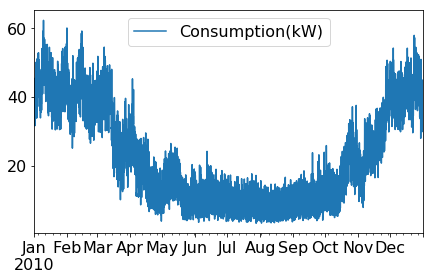

In [65]:
plt.figure()
df_load_eco_district["Consumption(kW)"].plot()
plt.legend()
plt.show()

<font size="5" color='blue'>Load vs Temperature</font>

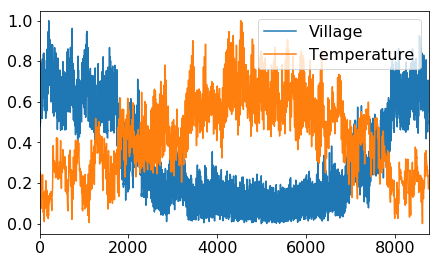

In [66]:
normalized_temperature_load_eco_district = normalize_dfs(df_load_eco_district["Consumption(kW)"],df_temperature_village)
normalized_temperature_load_eco_district.columns = ["Village","Temperature"]
normalized_temperature_load_eco_district.plot();

<font size="5" color='blue'>Consumption per day</font>

In [67]:
load_day_eco_district = []
for date in rng_days: load_day_eco_district.append((df_load_eco_district['Consumption(kW)'][date.strftime('%Y-%m-%d')].sum()))
#create dataframe
df_load_day_eco_district = pd.DataFrame(load_day_eco_district, columns=['Consumption(kW)'])
df_load_day_eco_district.set_index(rng_days, inplace=True)
df_load_day_eco_district.head()

,Consumption(kW)
2010-01-01,920.035752
2010-01-02,1005.979474
2010-01-03,993.333391
2010-01-04,1068.354545
2010-01-05,1069.256201


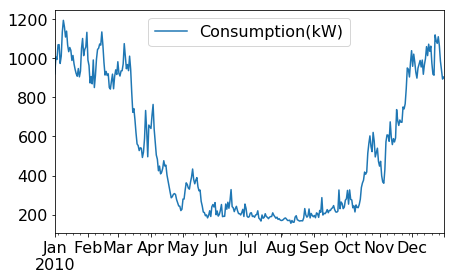

In [68]:
plt.figure()
df_load_day_eco_district["Consumption(kW)"].plot()
plt.legend()
plt.show()

<font size="5" color='blue'>Seasons of the year</font>

<font size="4" color='yellow'>Clustering</font>

In [69]:
df_load_day_eco_district['cluster'] = k_means_3(np.array(load_day_eco_district).reshape(-1, 1), 3)

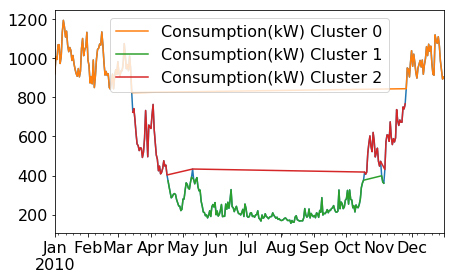

In [70]:
plt.figure()
df_load_day_eco_district['Consumption(kW)'].plot(label='')
df_load_day_eco_district['Consumption(kW)'][df_load_day_eco_district['cluster']==0].plot(label='Consumption(kW) Cluster 0')
df_load_day_eco_district['Consumption(kW)'][df_load_day_eco_district['cluster']==1].plot(label='Consumption(kW) Cluster 1')
df_load_day_eco_district['Consumption(kW)'][df_load_day_eco_district['cluster']==2].plot(label='Consumption(kW) Cluster 2')
plt.legend()
plt.show()

<font size="4" color='yellow'>Separation</font>

In [71]:
#select first/final days for seasons
begin_transition1_eco_district = df_load_day_eco_district['Consumption(kW)'][df_load_day_eco_district['cluster']==2]['2010-03'].index[0].strftime('%Y-%m-%d')
end_transition1_eco_district = df_load_day_eco_district['Consumption(kW)'][df_load_day_eco_district['cluster']==2]['2010-04'].index[-1].strftime('%Y-%m-%d')
begin_transition2_eco_district = df_load_day_eco_district['Consumption(kW)'][df_load_day_eco_district['cluster']==2]['2010-10'].index[0].strftime('%Y-%m-%d')
end_transition2_eco_district = df_load_day_eco_district['Consumption(kW)'][df_load_day_eco_district['cluster']==2]['2010-11'].index[-1].strftime('%Y-%m-%d')
begin_winter_eco_district = (pd.date_range(end_transition2_eco_district, periods=1, freq='D')+1)[0].strftime('%Y-%m-%d')
end_winter_eco_district = (pd.date_range(begin_transition1_eco_district, periods=1, freq='D')-1)[0].strftime('%Y-%m-%d')
begin_summer_eco_district = (pd.date_range(end_transition1_eco_district, periods=1, freq='D')+1)[0].strftime('%Y-%m-%d')
end_summer_eco_district = (pd.date_range(begin_transition2_eco_district, periods=1, freq='D')-1)[0].strftime('%Y-%m-%d')

#create dataframes for seasons
df_summer_day_eco_district = df_load_day_eco_district[begin_summer_eco_district:end_summer_eco_district]['Consumption(kW)'].to_frame()
df_winter_day_eco_district = pd.concat([df_load_day_eco_district[first_day:end_winter_eco_district]['Consumption(kW)'].to_frame(), df_load_day_eco_district[begin_winter_eco_district:last_day]['Consumption(kW)'].to_frame()])
df_transition_day_eco_district = pd.concat([df_load_day_eco_district[begin_transition1_eco_district:end_transition1_eco_district]['Consumption(kW)'].to_frame(), df_load_day_eco_district[begin_transition2_eco_district:end_transition2_eco_district]['Consumption(kW)'].to_frame()])

D:\Programs\Anaconda3\lib\site-packages\pandas\core\arrays\datetimelike.py:1197: FutureWarning: Addition/subtraction of integers and integer-arrays to DatetimeArray is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  maybe_integer_op_deprecated(self)
D:\Programs\Anaconda3\lib\site-packages\pandas\core\arrays\datetimelike.py:1260: FutureWarning: Addition/subtraction of integers and integer-arrays to DatetimeArray is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  maybe_integer_op_deprecated(self)


<font size="5" color='blue'>Summer</font>

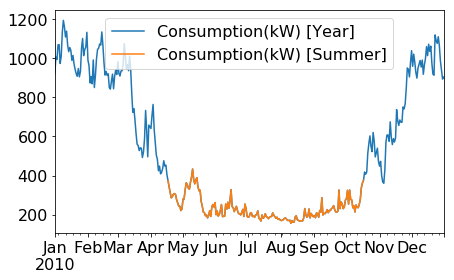

In [72]:
plt.figure()
df_load_day_eco_district["Consumption(kW)"].plot(label='Consumption(kW) [Year]')
df_summer_day_eco_district["Consumption(kW)"].plot(label='Consumption(kW) [Summer]')
plt.legend()
plt.show()

<font size="4" color='yellow'>Eucledian Distance</font>

In [73]:
min_euclidean_day_summer_eco_district = 9999999999
most_common_consumption_day_summer_eco_district = 0
for day1 in df_summer_day_eco_district.index:
    euclidean_summer_eco_district = 0
    for day2 in df_summer_day_eco_district.index: euclidean_summer_eco_district += distance.euclidean(df_load_eco_district[day1.strftime('%Y-%m-%d')]['Consumption(kW)'].values, df_load_eco_district[day2.strftime('%Y-%m-%d')]['Consumption(kW)'].values)
    if euclidean_summer_eco_district < min_euclidean_day_summer_eco_district:
        min_euclidean_day_summer_eco_district = euclidean_summer_eco_district
        most_common_consumption_day_summer_eco_district = day1.strftime('%Y-%m-%d')

<font size="4" color='yellow'>Comparison days</font>

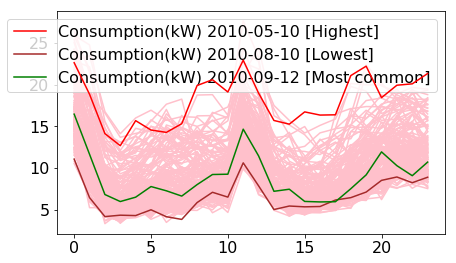

In [74]:
highest_consumption_day_summer_eco_district = df_summer_day_eco_district.idxmax()[0].strftime("%Y-%m-%d")
lowest_consumption_day_summer_eco_district = df_summer_day_eco_district.idxmin()[0].strftime("%Y-%m-%d")
plt.figure()
for day in df_summer_day_eco_district.index:
    if day.strftime("%Y-%m-%d") == most_common_consumption_day_summer_eco_district:
        plt.plot(df_load_eco_district[day.strftime("%Y-%m-%d")]['Consumption(kW)'].values, color='green', zorder=99999, label='Consumption(kW) '+most_common_consumption_day_summer_eco_district+' [Most common]')
    elif day.strftime("%Y-%m-%d") == highest_consumption_day_summer_eco_district:
        plt.plot(df_load_eco_district[day.strftime("%Y-%m-%d")]['Consumption(kW)'].values, color='red', zorder=99997, label='Consumption(kW) '+highest_consumption_day_summer_eco_district+' [Highest]')
    elif day.strftime("%Y-%m-%d") == lowest_consumption_day_summer_eco_district:
        plt.plot(df_load_eco_district[day.strftime("%Y-%m-%d")]['Consumption(kW)'].values, color='brown', zorder=99996, label='Consumption(kW) '+lowest_consumption_day_summer_eco_district+' [Lowest]')
    else:
        plt.plot(df_load_eco_district[day.strftime("%Y-%m-%d")]['Consumption(kW)'].values, color='pink')
plt.legend()
plt.show()

In [75]:
days_summer_eco_district = [most_common_consumption_day_summer_eco_district, highest_consumption_day_summer_eco_district, lowest_consumption_day_summer_eco_district]
df_summer_day_eco_district.query('@df_summer_day_eco_district.index.normalize() in @days_summer_eco_district')

,Consumption(kW)
2010-05-10,433.756434
2010-08-10,156.702369
2010-09-12,213.021476


<font size="5" color='blue'>Winter</font>

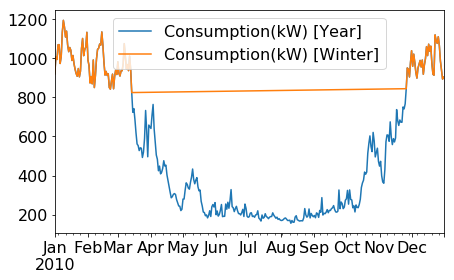

In [76]:
plt.figure()
df_load_day_eco_district["Consumption(kW)"].plot(label='Consumption(kW) [Year]')
df_winter_day_eco_district["Consumption(kW)"].plot(label='Consumption(kW) [Winter]')
plt.legend()
plt.show()

<font size="4" color='yellow'>Eucledian Distance</font>

In [77]:
min_euclidean_day_winter_eco_district = 9999999999
most_common_consumption_day_winter_eco_district = 0
for day1 in df_winter_day_eco_district.index:
    euclidean_winter_eco_district = 0
    for day2 in df_winter_day_eco_district.index: euclidean_winter_eco_district += distance.euclidean(df_load_eco_district[day1.strftime('%Y-%m-%d')]['Consumption(kW)'].values, df_load_eco_district[day2.strftime('%Y-%m-%d')]['Consumption(kW)'].values)
    if euclidean_winter_eco_district < min_euclidean_day_winter_eco_district:
        min_euclidean_day_winter_eco_district = euclidean_winter_eco_district
        most_common_consumption_day_winter_eco_district = day1.strftime('%Y-%m-%d')

<font size="4" color='yellow'>Comparison days</font>

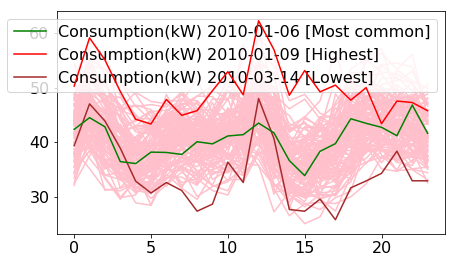

In [78]:
highest_consumption_day_winter_eco_district = df_winter_day_eco_district.idxmax()[0].strftime("%Y-%m-%d")
lowest_consumption_day_winter_eco_district = df_winter_day_eco_district.idxmin()[0].strftime("%Y-%m-%d")
plt.figure()
for day in df_winter_day_eco_district.index:
    if day.strftime("%Y-%m-%d") == most_common_consumption_day_winter_eco_district:
        plt.plot(df_load_eco_district[day.strftime("%Y-%m-%d")]['Consumption(kW)'].values, color='green', zorder=99999, label='Consumption(kW) '+most_common_consumption_day_winter_eco_district+' [Most common]')
    elif day.strftime("%Y-%m-%d") == highest_consumption_day_winter_eco_district:
        plt.plot(df_load_eco_district[day.strftime("%Y-%m-%d")]['Consumption(kW)'].values, color='red', zorder=99997, label='Consumption(kW) '+highest_consumption_day_winter_eco_district+' [Highest]')
    elif day.strftime("%Y-%m-%d") == lowest_consumption_day_winter_eco_district:
        plt.plot(df_load_eco_district[day.strftime("%Y-%m-%d")]['Consumption(kW)'].values, color='brown', zorder=99996, label='Consumption(kW) '+lowest_consumption_day_winter_eco_district+' [Lowest]')
    else:
        plt.plot(df_load_eco_district[day.strftime("%Y-%m-%d")]['Consumption(kW)'].values, color='pink')
plt.legend()
plt.show()

In [79]:
days_winter_eco_district = [most_common_consumption_day_winter_eco_district, highest_consumption_day_winter_eco_district,lowest_consumption_day_winter_eco_district]
df_winter_day_eco_district.query('@df_winter_day_eco_district.index.normalize() in @days_winter_eco_district')

,Consumption(kW)
2010-01-06,972.999312
2010-01-09,1193.304737
2010-03-14,824.374218


<font size="5" color='blue'>Transition</font>

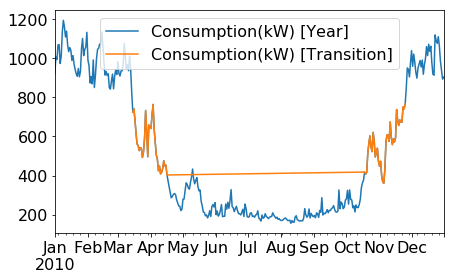

In [80]:
plt.figure()
df_load_day_eco_district["Consumption(kW)"].plot(label='Consumption(kW) [Year]')
df_transition_day_eco_district["Consumption(kW)"].plot(label='Consumption(kW) [Transition]')
plt.legend()
plt.show()

<font size="4" color='yellow'>Eucledian Distance</font>

In [81]:
min_euclidean_day_transition_eco_district = 9999999999
most_common_consumption_day_transition_eco_district = 0
for day1 in df_transition_day_eco_district.index:
    euclidean_transition_eco_district = 0
    for day2 in df_transition_day_eco_district.index: euclidean_transition_eco_district += distance.euclidean(df_load_eco_district[day1.strftime('%Y-%m-%d')]['Consumption(kW)'].values, df_load_eco_district[day2.strftime('%Y-%m-%d')]['Consumption(kW)'].values)
    if euclidean_transition_eco_district < min_euclidean_day_transition_eco_district:
        min_euclidean_day_transition_eco_district = euclidean_transition_eco_district
        most_common_consumption_day_transition_eco_district = day1.strftime('%Y-%m-%d')

<font size="4" color='yellow'>Comparison days</font>

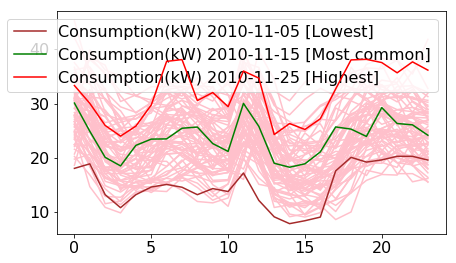

In [82]:
highest_consumption_day_transition_eco_district = df_transition_day_eco_district.idxmax()[0].strftime("%Y-%m-%d")
lowest_consumption_day_transition_eco_district = df_transition_day_eco_district.idxmin()[0].strftime("%Y-%m-%d")
plt.figure()
for day in df_transition_day_eco_district.index:
    if day.strftime("%Y-%m-%d") == most_common_consumption_day_transition_eco_district:
        plt.plot(df_load_eco_district[day.strftime("%Y-%m-%d")]['Consumption(kW)'].values, color='green', zorder=99999, label='Consumption(kW) '+most_common_consumption_day_transition_eco_district+' [Most common]')
    elif day.strftime("%Y-%m-%d") == highest_consumption_day_transition_eco_district:
        plt.plot(df_load_eco_district[day.strftime("%Y-%m-%d")]['Consumption(kW)'].values, color='red', zorder=99997, label='Consumption(kW) '+highest_consumption_day_transition_eco_district+' [Highest]')
    elif day.strftime("%Y-%m-%d") == lowest_consumption_day_transition_eco_district:
        plt.plot(df_load_eco_district[day.strftime("%Y-%m-%d")]['Consumption(kW)'].values, color='brown', zorder=99996, label='Consumption(kW) '+lowest_consumption_day_transition_eco_district+' [Lowest]')
    else:
        plt.plot(df_load_eco_district[day.strftime("%Y-%m-%d")]['Consumption(kW)'].values, color='pink')
plt.legend()
plt.show()

In [83]:
days_transition_eco_district = [most_common_consumption_day_transition_eco_district, highest_consumption_day_transition_eco_district, lowest_consumption_day_transition_eco_district]
df_transition_day_eco_district.query('@df_transition_day_eco_district.index.normalize() in @days_transition_eco_district')

,Consumption(kW)
2010-11-05,361.090093
2010-11-15,572.067373
2010-11-25,766.683576


<font size="5" color='blue'>Transformers</font>

In [84]:
max_consumption_eco_district = df_load_eco_district.max().values[0]
max_consumption_time_eco_district = df_load_eco_district.idxmax()[0].strftime("%Y-%m-%d %H:%M:%S")
print("The max consumption is ", max_consumption_eco_district, "kVA at ", max_consumption_time_eco_district)

The max consumption is  62.234142712 kVA at  2010-01-09 12:00:00


In [85]:
transformers_eco_district = [
    {"Name":"Transformer(1)",'Percentage':100},
]
df_transformers_eco_district = pd.DataFrame(transformers_eco_district, columns=['Name','Percentage'])
df_transformers_eco_district["(kVA)"] = df_transformers_eco_district["Percentage"]/100*max_consumption_eco_district
df_transformers_eco_district["(kW)"] = df_transformers_eco_district["(kVA)"]*.8
df_transformers_eco_district["(kVAr)"] = df_transformers_eco_district["(kVA)"]*math.sin(math.acos(.8))
df_transformers_eco_district.set_index('Name',inplace=True)
df_transformers_eco_district

,Percentage,(kVA),(kW),(kVAr)
Name,,,,
Transformer(1),100,62.234143,49.787314,37.340486


<font size="5" color='blue'>Weather</font>

In [86]:
weather = get_weather_data(filename='weather.csv', datapath='data/')
weather.set_index(rng,inplace=True)
weather.head()

,pressure,temperature,wind_speed,roughness_length,temperature,wind_speed
,0,2,10,0,10,80
2010-01-01 00:00:00,98405.7,267.60,5.32697,0.15,267.57,7.80697
2010-01-01 01:00:00,98382.7,267.60,5.46199,0.15,267.55,7.86199
2010-01-01 02:00:00,98362.9,267.61,5.67899,0.15,267.54,8.59899
2010-01-01 03:00:00,98340.9,267.63,5.68466,0.15,267.56,7.89466
2010-01-01 04:00:00,98336.8,267.63,5.38084,0.15,267.61,7.57084


<font size="5" color='blue'>PV</font>

<font size="4" color='yellow'>Production</font>

In [87]:
#weather series
temp_series = df_temperature_village.squeeze()
wind_series = weather['wind_speed'][10]
# Calculations
sandia_modules = pvlib.pvsystem.retrieve_sam('SandiaMod')
sapm_inverters = pvlib.pvsystem.retrieve_sam('cecinverter')
module = sandia_modules['Canadian_Solar_CS5P_220M___2009_']
inverter = sapm_inverters['ABB__MICRO_0_25_I_OUTD_US_208_208V__CEC_2014_']
system = {'module': module, 'inverter': inverter, 'surface_azimuth': 180}
times = rng
system['surface_tilt'] = latitude
solpos = pvlib.solarposition.get_solarposition(times, latitude, longitude)
dni_extra = pvlib.irradiance.get_extra_radiation(times)
airmass = pvlib.atmosphere.get_relative_airmass(solpos['apparent_zenith'])
pressure = pvlib.atmosphere.alt2pres(altitude)
am_abs = pvlib.atmosphere.get_absolute_airmass(airmass, pressure)
tl = pvlib.clearsky.lookup_linke_turbidity(times, latitude, longitude)
cs = pvlib.clearsky.ineichen(solpos['apparent_zenith'], am_abs, tl, dni_extra=dni_extra, altitude=altitude)
aoi = pvlib.irradiance.aoi(system['surface_tilt'], system['surface_azimuth'], solpos['apparent_zenith'], solpos['azimuth'])
total_irrad = pvlib.irradiance.get_total_irradiance(system['surface_tilt'], system['surface_azimuth'], solpos['apparent_zenith'], solpos['azimuth'], cs['dni'], cs['ghi'], cs['dhi'], dni_extra=dni_extra, model='haydavies')
temps = pvlib.pvsystem.sapm_celltemp(total_irrad['poa_global'], wind_series, temp_series)
effective_irradiance = pvlib.pvsystem.sapm_effective_irradiance(total_irrad['poa_direct'], total_irrad['poa_diffuse'], am_abs, aoi, module)
dc = pvlib.pvsystem.sapm(effective_irradiance, temps['temp_cell'], module)
ac = pvlib.pvsystem.snlinverter(dc['v_mp'], dc['p_mp'], inverter)
#create dataframe
number_of_panels = 150
df_production_pv = pd.DataFrame(ac.values*number_of_panels/1000, columns=["Production(kW)"])
df_production_pv.set_index(rng,inplace=True)
df_production_pv.head()

,Production(kW)
2010-01-01 00:00:00,-0.003
2010-01-01 01:00:00,-0.003
2010-01-01 02:00:00,-0.003
2010-01-01 03:00:00,-0.003
2010-01-01 04:00:00,-0.003


<font size="4" color='yellow'>Production per day</font>

In [88]:
production_day_pv = []
for date in rng_days: production_day_pv.append((df_production_pv['Production(kW)'][date.strftime('%Y-%m-%d')].sum()))
#create dataframe
df_production_day_pv = pd.DataFrame(production_day_pv, columns=['Production(kW)'])
df_production_day_pv.set_index(rng_days, inplace=True)
df_production_day_pv.head()

,Production(kW)
2010-01-01,162.610949
2010-01-02,161.493696
2010-01-03,161.588823
2010-01-04,163.325269
2010-01-05,164.655652


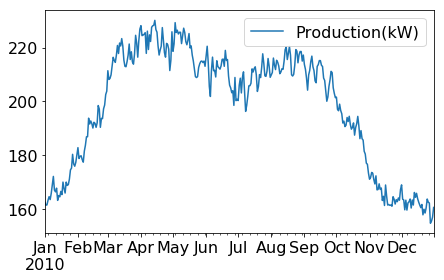

In [89]:
plt.figure()
df_production_day_pv['Production(kW)'].plot()
plt.legend()
plt.show()

<font size="5" color='blue'>Wind</font>

<font size="4" color='yellow'>Production</font>

In [90]:
# specification of wind turbine where power curve is provided in the oedb turbine library
enercon_e53 = {
        'turbine_type': 'E-53/800',  # turbine type as in oedb turbine library
        'hub_height': 50  # in m
    }
e53 = WindTurbine(**enercon_e53)
e53.nominal_power=e53.nominal_power/10
e53.power_curve['value']=e53.power_curve['value']/10
#power output calculation for e53, own specifications for ModelChain setup
modelchain_data = {
    'wind_speed_model': 'logarithmic',      # 'logarithmic' (default), hellman' or 'interpolation_extrapolation'
    'density_model': 'ideal_gas',           # 'barometric' (default), 'ideal_gas' or 'interpolation_extrapolation'
    'temperature_model': 'linear_gradient', # 'linear_gradient' (def.) or 'interpolation_extrapolation'
    'power_output_model': 'power_curve',    # 'power_curve' (default) or 'power_coefficient_curve'
    'density_correction': True,             # False (default) or True
    'obstacle_height': 0,                   # default: 0
    'hellman_exp': None}                    # None (default) or None
mc_e53 = ModelChain(e53, **modelchain_data).run_model(weather)
# write power output time series to WindTurbine object
e53.power_output = mc_e53.power_output
#create dataframe
df_production_wind = pd.DataFrame(e53.power_output.values/1000, columns=["Production(kW)"])
df_production_wind.set_index(rng,inplace=True)
df_production_wind.head()

,Production(kW)
2010-01-01 00:00:00,26.273147
2010-01-01 01:00:00,26.831603
2010-01-01 02:00:00,34.636393
2010-01-01 03:00:00,27.152766
2010-01-01 04:00:00,23.834904


In [91]:
production_day_wind = []
for date in rng_days: production_day_wind.append((df_production_wind['Production(kW)'][date.strftime('%Y-%m-%d')].sum()))
#create dataframe
df_production_day_wind = pd.DataFrame(production_day_wind, columns=['Production(kW)'])
df_production_day_wind.set_index(rng_days, inplace=True)
df_production_day_wind.head()

,Production(kW)
2010-01-01,573.940704
2010-01-02,214.113183
2010-01-03,169.741240
2010-01-04,47.582733
2010-01-05,85.136364


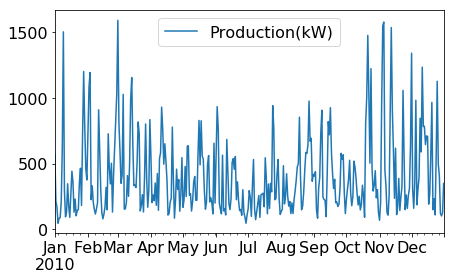

In [92]:
plt.figure()
df_production_day_wind['Production(kW)'].plot()
plt.legend()
plt.show()

<font size="5" color='blue'>Consumption-Production</font>

<font size="4" color='yellow'>Difference</font>

In [93]:
difference_consumption_production = []
for hour in rng: difference_consumption_production.append(df_load_eco_district['Consumption(kW)'][hour]-df_production_wind['Production(kW)'][hour]-df_production_pv['Production(kW)'][hour])
df_difference_consumption_production = pd.DataFrame(difference_consumption_production, columns=['Consumption-Production(kW)'])
df_difference_consumption_production.set_index(rng, inplace=True)
df_difference_consumption_production['Consumption(kW)']=df_load_eco_district['Consumption(kW)']
df_difference_consumption_production['Production(kW) PV']=df_production_pv['Production(kW)']
df_difference_consumption_production['Production(kW) Wind']=df_production_wind['Production(kW)']
df_difference_consumption_production.head()

,Consumption-Production(kW),Consumption(kW),Production(kW) PV,Production(kW) Wind
2010-01-01 00:00:00,8.027764,34.297910,-0.003,26.273147
2010-01-01 01:00:00,18.096615,44.925218,-0.003,26.831603
2010-01-01 02:00:00,3.619794,38.253187,-0.003,34.636393
2010-01-01 03:00:00,10.135914,37.285681,-0.003,27.152766
2010-01-01 04:00:00,7.893090,31.724994,-0.003,23.834904


<font size="4" color='yellow'>Difference per day</font>

In [94]:
difference_consumption_production_day = []
for day in rng_days: difference_consumption_production_day.append(df_load_day_eco_district['Consumption(kW)'][day.strftime('%Y-%m-%d')]-df_production_day_wind['Production(kW)'][day.strftime('%Y-%m-%d')]-df_production_day_pv['Production(kW)'][day.strftime('%Y-%m-%d')])
df_difference_consumption_production_day = pd.DataFrame(difference_consumption_production_day, columns=['Consumption-Production(kW)'])
df_difference_consumption_production_day.set_index(rng_days, inplace=True)
df_difference_consumption_production_day['Consumption(kW)']=df_load_day_eco_district['Consumption(kW)']
df_difference_consumption_production_day['Production(kW) PV']=df_production_day_pv['Production(kW)']
df_difference_consumption_production_day['Production(kW) Wind']=df_production_day_wind['Production(kW)']
df_difference_consumption_production_day.head()

,Consumption-Production(kW),Consumption(kW),Production(kW) PV,Production(kW) Wind
2010-01-01,183.484099,920.035752,162.610949,573.940704
2010-01-02,630.372594,1005.979474,161.493696,214.113183
2010-01-03,662.003327,993.333391,161.588823,169.741240
2010-01-04,857.446543,1068.354545,163.325269,47.582733
2010-01-05,819.464185,1069.256201,164.655652,85.136364


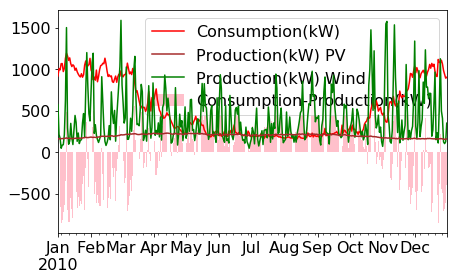

In [95]:
plt.figure()
df_load_day_eco_district['Consumption(kW)'].plot(label='Consumption(kW)', color='red', zorder=997)
df_production_day_pv['Production(kW)'].plot(label='Production(kW) PV', color='brown', zorder=999)
df_production_day_wind['Production(kW)'].plot(label='Production(kW) Wind', color='green', zorder=998)
plt.bar(df_difference_consumption_production_day.index, -df_difference_consumption_production_day['Consumption-Production(kW)'].values, label='Consumption-Production(kW)', color='pink')
plt.legend()
plt.show()

<font size="5" color='blue'>Storage</font>

<font size="4" color='yellow'>Node diagram</font>

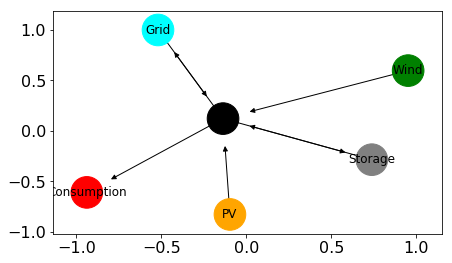

In [96]:
G = nx.DiGraph()
G.add_edges_from(
    [('Node','Grid'), ('Grid', 'Node'), ('Node','Consumption'),('PV', 'Node'),('Wind', 'Node'),('Node', 'Storage'),('Storage', 'Node')])
pos = nx.spring_layout(G, k=1)
color=['black','cyan','red','orange', 'green', 'gray']
nx.draw_networkx_nodes(G, pos, node_size = 1000, node_color=color)
nx.draw_networkx_labels(G, pos)
nx.draw_networkx_edges(G, pos, arrows=True, node_size = 3000)
plt.show()

<font size="4" color='yellow'>Calculation</font>

In [97]:
bad_days = ['2010-07-05','2010-07-11','2010-08-15','2010-08-21', '2010-09-06', '2010-10-02', '2010-10-03']
df_without_bad_days = df_summer_day_eco_district.query('@df_summer_day_eco_district.index.normalize() not in @bad_days')

In [98]:
dict_storage_size = {}
for day in df_without_bad_days.index:
    #time-period
    day_to_analyze = day.strftime('%Y-%m-%d')
    time_day = TimeUnit(periods = 24, dt=1, start=day_to_analyze)
    #units
    unit_eco_district = FixedConsumptionUnit(time=time_day, name='eco_district',p=df_load_eco_district['Consumption(kW)'][day_to_analyze].values.tolist(), energy_type=elec)        
    unit_pv = FixedProductionUnit(time=time_day, name='pv', p=df_production_pv['Production(kW)'][day_to_analyze].values.tolist(), energy_type=elec)
    unit_wind = FixedProductionUnit(time=time_day, name='wind', p=df_production_wind['Production(kW)'][day_to_analyze].values.tolist(), energy_type=elec)
    unit_grid_consumption = VariableConsumptionUnit(time_day, name='grid_consumption', energy_type=elec, e_max=1000000)
    unit_grid_production = VariableProductionUnit(time_day, name='grid_production',energy_type=elec, e_max=10000000)
    unit_storage = StorageUnit(time_day, name='storage', e_0=0, ef_is_e0=True, )
    #node
    node = EnergyNode(time=time_day, name='elec_node', energy_type=elec)
    node.connect_units(unit_eco_district, unit_pv, unit_wind, unit_storage, unit_grid_consumption, unit_grid_production)
    #functions
    unit_grid_production.minimize_production(weight=1)
    unit_grid_consumption.minimize_consumption(weight=1)
    #model
    model = OptimisationModel(time=time_day, name='storage')
    model.add_nodes_and_actors(node)
    model.writeLP(work_path+r'\optim_models\storage.lp')
    model.solve_and_update(PULP_CBC_CMD(msg=1))
    if LpStatus[model.status] == 'Optimal':
        dict_storage_size[day] = unit_storage.capacity.value

You are studying the period from 2010-04-17 00:00:00 to 2010-04-17 23:00:00
Creating the eco_district.
Creating the pv.
Creating the wind.
Creating the grid_consumption.
Creating the grid_production.
Creating the storage.
Creating the elec_node.

--- Adding all variables to the model ---
Adding variable : eco_district_p
Adding variable : eco_district_e_tot
Adding variable : pv_p
Adding variable : pv_e_tot
Adding variable : wind_p
Adding variable : wind_e_tot
Adding variable : storage_p
Adding variable : storage_e_tot
Adding variable : storage_u
Adding variable : storage_capacity
Adding variable : storage_e
Adding variable : storage_pc
Adding variable : storage_pd
Adding variable : storage_uc
Adding variable : storage_e_f
Adding variable : grid_consumption_p
Adding variable : grid_consumption_e_tot
Adding variable : grid_consumption_u
Adding variable : grid_production_p
Adding variable : grid_production_e_tot
Adding variable : grid_production_u

--- Adding all objectives to the model --

D:\Programs\Anaconda3\lib\site-packages\omegalpes\general\optimisation\model.py:460: UserWarning: The unit elec_node seems to have as parent Autrans which was not declared as parent.
  'parent.'.format(unit.name, parent_name))


Adding constraint : storage_def_min_discharging , exp = storage_pd[t] + (storage_uc[t] - storage_u[t]) * 1e-05 >= 0 for t in time.I
Adding constraint : storage_set_e_0 , exp = storage_e[0] == 0
Adding constraint : storage_e_f_min , exp = storage_e_f >= 0 * storage_capacity
Adding constraint : storage_e_f_max , exp = storage_e_f <= 1 * storage_capacity
Adding constraint : storage_calc_e_f , exp = storage_e_f-storage_e[23] == 1*(storage_pc[23]*1-storage_pd[23]*1/1-0*storage_e[23]-0*storage_capacity)
Adding constraint : storage_ef_is_e0 , exp = storage_e[0] == storage_e_f
Adding constraint : grid_consumption_calc_e_tot , exp = grid_consumption_e_tot == time.DT * lpSum(grid_consumption_p[t] for t in time.I)
Adding constraint : grid_consumption_on_off_max , exp = grid_consumption_p[t] <= grid_consumption_u[t] * 100000.0 for t in time.I
Adding constraint : grid_consumption_on_off_min , exp = grid_consumption_p[t] >= grid_consumption_u[t] * 1e-05 for t in time.I
Adding constraint : grid_produ


 - - - - - UPDATE RESULTS - - - - - 
Updating unit : elec_node
Updating unit : eco_district
	Quantity : p
	Quantity : e_tot
Updating unit : pv
	Quantity : p
	Quantity : e_tot
Updating unit : wind
	Quantity : p
	Quantity : e_tot
Updating unit : storage
	Quantity : p
	Quantity : e_tot
	Quantity : u
	Quantity : capacity
	Quantity : e
	Quantity : pc
	Quantity : pd
	Quantity : uc
	Quantity : e_f
Updating unit : grid_consumption
	Quantity : p
	Quantity : e_tot
	Quantity : u
Updating unit : grid_production
	Quantity : p
	Quantity : e_tot
	Quantity : u
You are studying the period from 2010-04-20 00:00:00 to 2010-04-20 23:00:00
Creating the eco_district.
Creating the pv.
Creating the wind.
Creating the grid_consumption.
Creating the grid_production.
Creating the storage.
Creating the elec_node.

--- Adding all variables to the model ---
Adding variable : eco_district_p
Adding variable : eco_district_e_tot
Adding variable : pv_p
Adding variable : pv_e_tot
Adding variable : wind_p
Adding variabl


 - - - - - UPDATE RESULTS - - - - - 
Updating unit : elec_node
Updating unit : eco_district
	Quantity : p
	Quantity : e_tot
Updating unit : pv
	Quantity : p
	Quantity : e_tot
Updating unit : wind
	Quantity : p
	Quantity : e_tot
Updating unit : storage
	Quantity : p
	Quantity : e_tot
	Quantity : u
	Quantity : capacity
	Quantity : e
	Quantity : pc
	Quantity : pd
	Quantity : uc
	Quantity : e_f
Updating unit : grid_consumption
	Quantity : p
	Quantity : e_tot
	Quantity : u
Updating unit : grid_production
	Quantity : p
	Quantity : e_tot
	Quantity : u
You are studying the period from 2010-04-22 00:00:00 to 2010-04-22 23:00:00
Creating the eco_district.
Creating the pv.
Creating the wind.
Creating the grid_consumption.
Creating the grid_production.
Creating the storage.
Creating the elec_node.

--- Adding all variables to the model ---
Adding variable : eco_district_p
Adding variable : eco_district_e_tot
Adding variable : pv_p
Adding variable : pv_e_tot
Adding variable : wind_p
Adding variabl


 - - - - - UPDATE RESULTS - - - - - 
Updating unit : elec_node
Updating unit : eco_district
	Quantity : p
	Quantity : e_tot
Updating unit : pv
	Quantity : p
	Quantity : e_tot
Updating unit : wind
	Quantity : p
	Quantity : e_tot
Updating unit : storage
	Quantity : p
	Quantity : e_tot
	Quantity : u
	Quantity : capacity
	Quantity : e
	Quantity : pc
	Quantity : pd
	Quantity : uc
	Quantity : e_f
Updating unit : grid_consumption
	Quantity : p
	Quantity : e_tot
	Quantity : u
Updating unit : grid_production
	Quantity : p
	Quantity : e_tot
	Quantity : u
You are studying the period from 2010-04-24 00:00:00 to 2010-04-24 23:00:00
Creating the eco_district.
Creating the pv.
Creating the wind.
Creating the grid_consumption.
Creating the grid_production.
Creating the storage.
Creating the elec_node.

--- Adding all variables to the model ---
Adding variable : eco_district_p
Adding variable : eco_district_e_tot
Adding variable : pv_p
Adding variable : pv_e_tot
Adding variable : wind_p
Adding variabl


 - - - - - UPDATE RESULTS - - - - - 
Updating unit : elec_node
Updating unit : eco_district
	Quantity : p
	Quantity : e_tot
Updating unit : pv
	Quantity : p
	Quantity : e_tot
Updating unit : wind
	Quantity : p
	Quantity : e_tot
Updating unit : storage
	Quantity : p
	Quantity : e_tot
	Quantity : u
	Quantity : capacity
	Quantity : e
	Quantity : pc
	Quantity : pd
	Quantity : uc
	Quantity : e_f
Updating unit : grid_consumption
	Quantity : p
	Quantity : e_tot
	Quantity : u
Updating unit : grid_production
	Quantity : p
	Quantity : e_tot
	Quantity : u
You are studying the period from 2010-04-26 00:00:00 to 2010-04-26 23:00:00
Creating the eco_district.
Creating the pv.
Creating the wind.
Creating the grid_consumption.
Creating the grid_production.
Creating the storage.
Creating the elec_node.

--- Adding all variables to the model ---
Adding variable : eco_district_p
Adding variable : eco_district_e_tot
Adding variable : pv_p
Adding variable : pv_e_tot
Adding variable : wind_p
Adding variabl


 - - - - - UPDATE RESULTS - - - - - 
Updating unit : elec_node
Updating unit : eco_district
	Quantity : p
	Quantity : e_tot
Updating unit : pv
	Quantity : p
	Quantity : e_tot
Updating unit : wind
	Quantity : p
	Quantity : e_tot
Updating unit : storage
	Quantity : p
	Quantity : e_tot
	Quantity : u
	Quantity : capacity
	Quantity : e
	Quantity : pc
	Quantity : pd
	Quantity : uc
	Quantity : e_f
Updating unit : grid_consumption
	Quantity : p
	Quantity : e_tot
	Quantity : u
Updating unit : grid_production
	Quantity : p
	Quantity : e_tot
	Quantity : u
You are studying the period from 2010-04-28 00:00:00 to 2010-04-28 23:00:00
Creating the eco_district.
Creating the pv.
Creating the wind.
Creating the grid_consumption.
Creating the grid_production.
Creating the storage.
Creating the elec_node.

--- Adding all variables to the model ---
Adding variable : eco_district_p
Adding variable : eco_district_e_tot
Adding variable : pv_p
Adding variable : pv_e_tot
Adding variable : wind_p
Adding variabl


 - - - - - UPDATE RESULTS - - - - - 
Updating unit : elec_node
Updating unit : eco_district
	Quantity : p
	Quantity : e_tot
Updating unit : pv
	Quantity : p
	Quantity : e_tot
Updating unit : wind
	Quantity : p
	Quantity : e_tot
Updating unit : storage
	Quantity : p
	Quantity : e_tot
	Quantity : u
	Quantity : capacity
	Quantity : e
	Quantity : pc
	Quantity : pd
	Quantity : uc
	Quantity : e_f
Updating unit : grid_consumption
	Quantity : p
	Quantity : e_tot
	Quantity : u
Updating unit : grid_production
	Quantity : p
	Quantity : e_tot
	Quantity : u
You are studying the period from 2010-04-30 00:00:00 to 2010-04-30 23:00:00
Creating the eco_district.
Creating the pv.
Creating the wind.
Creating the grid_consumption.
Creating the grid_production.
Creating the storage.
Creating the elec_node.

--- Adding all variables to the model ---
Adding variable : eco_district_p
Adding variable : eco_district_e_tot
Adding variable : pv_p
Adding variable : pv_e_tot
Adding variable : wind_p
Adding variabl


 - - - - - UPDATE RESULTS - - - - - 
Updating unit : elec_node
Updating unit : eco_district
	Quantity : p
	Quantity : e_tot
Updating unit : pv
	Quantity : p
	Quantity : e_tot
Updating unit : wind
	Quantity : p
	Quantity : e_tot
Updating unit : storage
	Quantity : p
	Quantity : e_tot
	Quantity : u
	Quantity : capacity
	Quantity : e
	Quantity : pc
	Quantity : pd
	Quantity : uc
	Quantity : e_f
Updating unit : grid_consumption
	Quantity : p
	Quantity : e_tot
	Quantity : u
Updating unit : grid_production
	Quantity : p
	Quantity : e_tot
	Quantity : u
You are studying the period from 2010-05-02 00:00:00 to 2010-05-02 23:00:00
Creating the eco_district.
Creating the pv.
Creating the wind.
Creating the grid_consumption.
Creating the grid_production.
Creating the storage.
Creating the elec_node.

--- Adding all variables to the model ---
Adding variable : eco_district_p
Adding variable : eco_district_e_tot
Adding variable : pv_p
Adding variable : pv_e_tot
Adding variable : wind_p
Adding variabl


 - - - - - UPDATE RESULTS - - - - - 
Updating unit : elec_node
Updating unit : eco_district
	Quantity : p
	Quantity : e_tot
Updating unit : pv
	Quantity : p
	Quantity : e_tot
Updating unit : wind
	Quantity : p
	Quantity : e_tot
Updating unit : storage
	Quantity : p
	Quantity : e_tot
	Quantity : u
	Quantity : capacity
	Quantity : e
	Quantity : pc
	Quantity : pd
	Quantity : uc
	Quantity : e_f
Updating unit : grid_consumption
	Quantity : p
	Quantity : e_tot
	Quantity : u
Updating unit : grid_production
	Quantity : p
	Quantity : e_tot
	Quantity : u
You are studying the period from 2010-05-04 00:00:00 to 2010-05-04 23:00:00
Creating the eco_district.
Creating the pv.
Creating the wind.
Creating the grid_consumption.
Creating the grid_production.
Creating the storage.
Creating the elec_node.

--- Adding all variables to the model ---
Adding variable : eco_district_p
Adding variable : eco_district_e_tot
Adding variable : pv_p
Adding variable : pv_e_tot
Adding variable : wind_p
Adding variabl


 - - - - - UPDATE RESULTS - - - - - 
Updating unit : elec_node
Updating unit : eco_district
	Quantity : p
	Quantity : e_tot
Updating unit : pv
	Quantity : p
	Quantity : e_tot
Updating unit : wind
	Quantity : p
	Quantity : e_tot
Updating unit : storage
	Quantity : p
	Quantity : e_tot
	Quantity : u
	Quantity : capacity
	Quantity : e
	Quantity : pc
	Quantity : pd
	Quantity : uc
	Quantity : e_f
Updating unit : grid_consumption
	Quantity : p
	Quantity : e_tot
	Quantity : u
Updating unit : grid_production
	Quantity : p
	Quantity : e_tot
	Quantity : u
You are studying the period from 2010-05-06 00:00:00 to 2010-05-06 23:00:00
Creating the eco_district.
Creating the pv.
Creating the wind.
Creating the grid_consumption.
Creating the grid_production.
Creating the storage.
Creating the elec_node.

--- Adding all variables to the model ---
Adding variable : eco_district_p
Adding variable : eco_district_e_tot
Adding variable : pv_p
Adding variable : pv_e_tot
Adding variable : wind_p
Adding variabl


 - - - - - UPDATE RESULTS - - - - - 
Updating unit : elec_node
Updating unit : eco_district
	Quantity : p
	Quantity : e_tot
Updating unit : pv
	Quantity : p
	Quantity : e_tot
Updating unit : wind
	Quantity : p
	Quantity : e_tot
Updating unit : storage
	Quantity : p
	Quantity : e_tot
	Quantity : u
	Quantity : capacity
	Quantity : e
	Quantity : pc
	Quantity : pd
	Quantity : uc
	Quantity : e_f
Updating unit : grid_consumption
	Quantity : p
	Quantity : e_tot
	Quantity : u
Updating unit : grid_production
	Quantity : p
	Quantity : e_tot
	Quantity : u
You are studying the period from 2010-05-08 00:00:00 to 2010-05-08 23:00:00
Creating the eco_district.
Creating the pv.
Creating the wind.
Creating the grid_consumption.
Creating the grid_production.
Creating the storage.
Creating the elec_node.

--- Adding all variables to the model ---
Adding variable : eco_district_p
Adding variable : eco_district_e_tot
Adding variable : pv_p
Adding variable : pv_e_tot
Adding variable : wind_p
Adding variabl


 - - - - - UPDATE RESULTS - - - - - 
Updating unit : elec_node
Updating unit : eco_district
	Quantity : p
	Quantity : e_tot
Updating unit : pv
	Quantity : p
	Quantity : e_tot
Updating unit : wind
	Quantity : p
	Quantity : e_tot
Updating unit : storage
	Quantity : p
	Quantity : e_tot
	Quantity : u
	Quantity : capacity
	Quantity : e
	Quantity : pc
	Quantity : pd
	Quantity : uc
	Quantity : e_f
Updating unit : grid_consumption
	Quantity : p
	Quantity : e_tot
	Quantity : u
Updating unit : grid_production
	Quantity : p
	Quantity : e_tot
	Quantity : u
You are studying the period from 2010-05-10 00:00:00 to 2010-05-10 23:00:00
Creating the eco_district.
Creating the pv.
Creating the wind.
Creating the grid_consumption.
Creating the grid_production.
Creating the storage.
Creating the elec_node.

--- Adding all variables to the model ---
Adding variable : eco_district_p
Adding variable : eco_district_e_tot
Adding variable : pv_p
Adding variable : pv_e_tot
Adding variable : wind_p
Adding variabl


 - - - - - UPDATE RESULTS - - - - - 
Updating unit : elec_node
Updating unit : eco_district
	Quantity : p
	Quantity : e_tot
Updating unit : pv
	Quantity : p
	Quantity : e_tot
Updating unit : wind
	Quantity : p
	Quantity : e_tot
Updating unit : storage
	Quantity : p
	Quantity : e_tot
	Quantity : u
	Quantity : capacity
	Quantity : e
	Quantity : pc
	Quantity : pd
	Quantity : uc
	Quantity : e_f
Updating unit : grid_consumption
	Quantity : p
	Quantity : e_tot
	Quantity : u
Updating unit : grid_production
	Quantity : p
	Quantity : e_tot
	Quantity : u
You are studying the period from 2010-05-12 00:00:00 to 2010-05-12 23:00:00
Creating the eco_district.
Creating the pv.
Creating the wind.
Creating the grid_consumption.
Creating the grid_production.
Creating the storage.
Creating the elec_node.

--- Adding all variables to the model ---
Adding variable : eco_district_p
Adding variable : eco_district_e_tot
Adding variable : pv_p
Adding variable : pv_e_tot
Adding variable : wind_p
Adding variabl


 - - - - - UPDATE RESULTS - - - - - 
Updating unit : elec_node
Updating unit : eco_district
	Quantity : p
	Quantity : e_tot
Updating unit : pv
	Quantity : p
	Quantity : e_tot
Updating unit : wind
	Quantity : p
	Quantity : e_tot
Updating unit : storage
	Quantity : p
	Quantity : e_tot
	Quantity : u
	Quantity : capacity
	Quantity : e
	Quantity : pc
	Quantity : pd
	Quantity : uc
	Quantity : e_f
Updating unit : grid_consumption
	Quantity : p
	Quantity : e_tot
	Quantity : u
Updating unit : grid_production
	Quantity : p
	Quantity : e_tot
	Quantity : u
You are studying the period from 2010-05-14 00:00:00 to 2010-05-14 23:00:00
Creating the eco_district.
Creating the pv.
Creating the wind.
Creating the grid_consumption.
Creating the grid_production.
Creating the storage.
Creating the elec_node.

--- Adding all variables to the model ---
Adding variable : eco_district_p
Adding variable : eco_district_e_tot
Adding variable : pv_p
Adding variable : pv_e_tot
Adding variable : wind_p
Adding variabl


 - - - - - UPDATE RESULTS - - - - - 
Updating unit : elec_node
Updating unit : eco_district
	Quantity : p
	Quantity : e_tot
Updating unit : pv
	Quantity : p
	Quantity : e_tot
Updating unit : wind
	Quantity : p
	Quantity : e_tot
Updating unit : storage
	Quantity : p
	Quantity : e_tot
	Quantity : u
	Quantity : capacity
	Quantity : e
	Quantity : pc
	Quantity : pd
	Quantity : uc
	Quantity : e_f
Updating unit : grid_consumption
	Quantity : p
	Quantity : e_tot
	Quantity : u
Updating unit : grid_production
	Quantity : p
	Quantity : e_tot
	Quantity : u
You are studying the period from 2010-05-16 00:00:00 to 2010-05-16 23:00:00
Creating the eco_district.
Creating the pv.
Creating the wind.
Creating the grid_consumption.
Creating the grid_production.
Creating the storage.
Creating the elec_node.

--- Adding all variables to the model ---
Adding variable : eco_district_p
Adding variable : eco_district_e_tot
Adding variable : pv_p
Adding variable : pv_e_tot
Adding variable : wind_p
Adding variabl


 - - - - - UPDATE RESULTS - - - - - 
Updating unit : elec_node
Updating unit : eco_district
	Quantity : p
	Quantity : e_tot
Updating unit : pv
	Quantity : p
	Quantity : e_tot
Updating unit : wind
	Quantity : p
	Quantity : e_tot
Updating unit : storage
	Quantity : p
	Quantity : e_tot
	Quantity : u
	Quantity : capacity
	Quantity : e
	Quantity : pc
	Quantity : pd
	Quantity : uc
	Quantity : e_f
Updating unit : grid_consumption
	Quantity : p
	Quantity : e_tot
	Quantity : u
Updating unit : grid_production
	Quantity : p
	Quantity : e_tot
	Quantity : u
You are studying the period from 2010-05-18 00:00:00 to 2010-05-18 23:00:00
Creating the eco_district.
Creating the pv.
Creating the wind.
Creating the grid_consumption.
Creating the grid_production.
Creating the storage.
Creating the elec_node.

--- Adding all variables to the model ---
Adding variable : eco_district_p
Adding variable : eco_district_e_tot
Adding variable : pv_p
Adding variable : pv_e_tot
Adding variable : wind_p
Adding variabl


 - - - - - UPDATE RESULTS - - - - - 
Updating unit : elec_node
Updating unit : eco_district
	Quantity : p
	Quantity : e_tot
Updating unit : pv
	Quantity : p
	Quantity : e_tot
Updating unit : wind
	Quantity : p
	Quantity : e_tot
Updating unit : storage
	Quantity : p
	Quantity : e_tot
	Quantity : u
	Quantity : capacity
	Quantity : e
	Quantity : pc
	Quantity : pd
	Quantity : uc
	Quantity : e_f
Updating unit : grid_consumption
	Quantity : p
	Quantity : e_tot
	Quantity : u
Updating unit : grid_production
	Quantity : p
	Quantity : e_tot
	Quantity : u
You are studying the period from 2010-05-20 00:00:00 to 2010-05-20 23:00:00
Creating the eco_district.
Creating the pv.
Creating the wind.
Creating the grid_consumption.
Creating the grid_production.
Creating the storage.
Creating the elec_node.

--- Adding all variables to the model ---
Adding variable : eco_district_p
Adding variable : eco_district_e_tot
Adding variable : pv_p
Adding variable : pv_e_tot
Adding variable : wind_p
Adding variabl


 - - - - - UPDATE RESULTS - - - - - 
Updating unit : elec_node
Updating unit : eco_district
	Quantity : p
	Quantity : e_tot
Updating unit : pv
	Quantity : p
	Quantity : e_tot
Updating unit : wind
	Quantity : p
	Quantity : e_tot
Updating unit : storage
	Quantity : p
	Quantity : e_tot
	Quantity : u
	Quantity : capacity
	Quantity : e
	Quantity : pc
	Quantity : pd
	Quantity : uc
	Quantity : e_f
Updating unit : grid_consumption
	Quantity : p
	Quantity : e_tot
	Quantity : u
Updating unit : grid_production
	Quantity : p
	Quantity : e_tot
	Quantity : u
You are studying the period from 2010-05-22 00:00:00 to 2010-05-22 23:00:00
Creating the eco_district.
Creating the pv.
Creating the wind.
Creating the grid_consumption.
Creating the grid_production.
Creating the storage.
Creating the elec_node.

--- Adding all variables to the model ---
Adding variable : eco_district_p
Adding variable : eco_district_e_tot
Adding variable : pv_p
Adding variable : pv_e_tot
Adding variable : wind_p
Adding variabl


 - - - - - UPDATE RESULTS - - - - - 
Updating unit : elec_node
Updating unit : eco_district
	Quantity : p
	Quantity : e_tot
Updating unit : pv
	Quantity : p
	Quantity : e_tot
Updating unit : wind
	Quantity : p
	Quantity : e_tot
Updating unit : storage
	Quantity : p
	Quantity : e_tot
	Quantity : u
	Quantity : capacity
	Quantity : e
	Quantity : pc
	Quantity : pd
	Quantity : uc
	Quantity : e_f
Updating unit : grid_consumption
	Quantity : p
	Quantity : e_tot
	Quantity : u
Updating unit : grid_production
	Quantity : p
	Quantity : e_tot
	Quantity : u
You are studying the period from 2010-05-24 00:00:00 to 2010-05-24 23:00:00
Creating the eco_district.
Creating the pv.
Creating the wind.
Creating the grid_consumption.
Creating the grid_production.
Creating the storage.
Creating the elec_node.

--- Adding all variables to the model ---
Adding variable : eco_district_p
Adding variable : eco_district_e_tot
Adding variable : pv_p
Adding variable : pv_e_tot
Adding variable : wind_p
Adding variabl


 - - - - - UPDATE RESULTS - - - - - 
Updating unit : elec_node
Updating unit : eco_district
	Quantity : p
	Quantity : e_tot
Updating unit : pv
	Quantity : p
	Quantity : e_tot
Updating unit : wind
	Quantity : p
	Quantity : e_tot
Updating unit : storage
	Quantity : p
	Quantity : e_tot
	Quantity : u
	Quantity : capacity
	Quantity : e
	Quantity : pc
	Quantity : pd
	Quantity : uc
	Quantity : e_f
Updating unit : grid_consumption
	Quantity : p
	Quantity : e_tot
	Quantity : u
Updating unit : grid_production
	Quantity : p
	Quantity : e_tot
	Quantity : u
You are studying the period from 2010-05-26 00:00:00 to 2010-05-26 23:00:00
Creating the eco_district.
Creating the pv.
Creating the wind.
Creating the grid_consumption.
Creating the grid_production.
Creating the storage.
Creating the elec_node.

--- Adding all variables to the model ---
Adding variable : eco_district_p
Adding variable : eco_district_e_tot
Adding variable : pv_p
Adding variable : pv_e_tot
Adding variable : wind_p
Adding variabl


 - - - - - UPDATE RESULTS - - - - - 
Updating unit : elec_node
Updating unit : eco_district
	Quantity : p
	Quantity : e_tot
Updating unit : pv
	Quantity : p
	Quantity : e_tot
Updating unit : wind
	Quantity : p
	Quantity : e_tot
Updating unit : storage
	Quantity : p
	Quantity : e_tot
	Quantity : u
	Quantity : capacity
	Quantity : e
	Quantity : pc
	Quantity : pd
	Quantity : uc
	Quantity : e_f
Updating unit : grid_consumption
	Quantity : p
	Quantity : e_tot
	Quantity : u
Updating unit : grid_production
	Quantity : p
	Quantity : e_tot
	Quantity : u
You are studying the period from 2010-05-28 00:00:00 to 2010-05-28 23:00:00
Creating the eco_district.
Creating the pv.
Creating the wind.
Creating the grid_consumption.
Creating the grid_production.
Creating the storage.
Creating the elec_node.

--- Adding all variables to the model ---
Adding variable : eco_district_p
Adding variable : eco_district_e_tot
Adding variable : pv_p
Adding variable : pv_e_tot
Adding variable : wind_p
Adding variabl


 - - - - - UPDATE RESULTS - - - - - 
Updating unit : elec_node
Updating unit : eco_district
	Quantity : p
	Quantity : e_tot
Updating unit : pv
	Quantity : p
	Quantity : e_tot
Updating unit : wind
	Quantity : p
	Quantity : e_tot
Updating unit : storage
	Quantity : p
	Quantity : e_tot
	Quantity : u
	Quantity : capacity
	Quantity : e
	Quantity : pc
	Quantity : pd
	Quantity : uc
	Quantity : e_f
Updating unit : grid_consumption
	Quantity : p
	Quantity : e_tot
	Quantity : u
Updating unit : grid_production
	Quantity : p
	Quantity : e_tot
	Quantity : u
You are studying the period from 2010-05-30 00:00:00 to 2010-05-30 23:00:00
Creating the eco_district.
Creating the pv.
Creating the wind.
Creating the grid_consumption.
Creating the grid_production.
Creating the storage.
Creating the elec_node.

--- Adding all variables to the model ---
Adding variable : eco_district_p
Adding variable : eco_district_e_tot
Adding variable : pv_p
Adding variable : pv_e_tot
Adding variable : wind_p
Adding variabl


 - - - - - UPDATE RESULTS - - - - - 
Updating unit : elec_node
Updating unit : eco_district
	Quantity : p
	Quantity : e_tot
Updating unit : pv
	Quantity : p
	Quantity : e_tot
Updating unit : wind
	Quantity : p
	Quantity : e_tot
Updating unit : storage
	Quantity : p
	Quantity : e_tot
	Quantity : u
	Quantity : capacity
	Quantity : e
	Quantity : pc
	Quantity : pd
	Quantity : uc
	Quantity : e_f
Updating unit : grid_consumption
	Quantity : p
	Quantity : e_tot
	Quantity : u
Updating unit : grid_production
	Quantity : p
	Quantity : e_tot
	Quantity : u
You are studying the period from 2010-06-01 00:00:00 to 2010-06-01 23:00:00
Creating the eco_district.
Creating the pv.
Creating the wind.
Creating the grid_consumption.
Creating the grid_production.
Creating the storage.
Creating the elec_node.

--- Adding all variables to the model ---
Adding variable : eco_district_p
Adding variable : eco_district_e_tot
Adding variable : pv_p
Adding variable : pv_e_tot
Adding variable : wind_p
Adding variabl


 - - - - - UPDATE RESULTS - - - - - 
Updating unit : elec_node
Updating unit : eco_district
	Quantity : p
	Quantity : e_tot
Updating unit : pv
	Quantity : p
	Quantity : e_tot
Updating unit : wind
	Quantity : p
	Quantity : e_tot
Updating unit : storage
	Quantity : p
	Quantity : e_tot
	Quantity : u
	Quantity : capacity
	Quantity : e
	Quantity : pc
	Quantity : pd
	Quantity : uc
	Quantity : e_f
Updating unit : grid_consumption
	Quantity : p
	Quantity : e_tot
	Quantity : u
Updating unit : grid_production
	Quantity : p
	Quantity : e_tot
	Quantity : u
You are studying the period from 2010-06-03 00:00:00 to 2010-06-03 23:00:00
Creating the eco_district.
Creating the pv.
Creating the wind.
Creating the grid_consumption.
Creating the grid_production.
Creating the storage.
Creating the elec_node.

--- Adding all variables to the model ---
Adding variable : eco_district_p
Adding variable : eco_district_e_tot
Adding variable : pv_p
Adding variable : pv_e_tot
Adding variable : wind_p
Adding variabl


 - - - - - UPDATE RESULTS - - - - - 
Updating unit : elec_node
Updating unit : eco_district
	Quantity : p
	Quantity : e_tot
Updating unit : pv
	Quantity : p
	Quantity : e_tot
Updating unit : wind
	Quantity : p
	Quantity : e_tot
Updating unit : storage
	Quantity : p
	Quantity : e_tot
	Quantity : u
	Quantity : capacity
	Quantity : e
	Quantity : pc
	Quantity : pd
	Quantity : uc
	Quantity : e_f
Updating unit : grid_consumption
	Quantity : p
	Quantity : e_tot
	Quantity : u
Updating unit : grid_production
	Quantity : p
	Quantity : e_tot
	Quantity : u
You are studying the period from 2010-06-05 00:00:00 to 2010-06-05 23:00:00
Creating the eco_district.
Creating the pv.
Creating the wind.
Creating the grid_consumption.
Creating the grid_production.
Creating the storage.
Creating the elec_node.

--- Adding all variables to the model ---
Adding variable : eco_district_p
Adding variable : eco_district_e_tot
Adding variable : pv_p
Adding variable : pv_e_tot
Adding variable : wind_p
Adding variabl


 - - - - - UPDATE RESULTS - - - - - 
Updating unit : elec_node
Updating unit : eco_district
	Quantity : p
	Quantity : e_tot
Updating unit : pv
	Quantity : p
	Quantity : e_tot
Updating unit : wind
	Quantity : p
	Quantity : e_tot
Updating unit : storage
	Quantity : p
	Quantity : e_tot
	Quantity : u
	Quantity : capacity
	Quantity : e
	Quantity : pc
	Quantity : pd
	Quantity : uc
	Quantity : e_f
Updating unit : grid_consumption
	Quantity : p
	Quantity : e_tot
	Quantity : u
Updating unit : grid_production
	Quantity : p
	Quantity : e_tot
	Quantity : u
You are studying the period from 2010-06-07 00:00:00 to 2010-06-07 23:00:00
Creating the eco_district.
Creating the pv.
Creating the wind.
Creating the grid_consumption.
Creating the grid_production.
Creating the storage.
Creating the elec_node.

--- Adding all variables to the model ---
Adding variable : eco_district_p
Adding variable : eco_district_e_tot
Adding variable : pv_p
Adding variable : pv_e_tot
Adding variable : wind_p
Adding variabl


 - - - - - UPDATE RESULTS - - - - - 
Updating unit : elec_node
Updating unit : eco_district
	Quantity : p
	Quantity : e_tot
Updating unit : pv
	Quantity : p
	Quantity : e_tot
Updating unit : wind
	Quantity : p
	Quantity : e_tot
Updating unit : storage
	Quantity : p
	Quantity : e_tot
	Quantity : u
	Quantity : capacity
	Quantity : e
	Quantity : pc
	Quantity : pd
	Quantity : uc
	Quantity : e_f
Updating unit : grid_consumption
	Quantity : p
	Quantity : e_tot
	Quantity : u
Updating unit : grid_production
	Quantity : p
	Quantity : e_tot
	Quantity : u
You are studying the period from 2010-06-09 00:00:00 to 2010-06-09 23:00:00
Creating the eco_district.
Creating the pv.
Creating the wind.
Creating the grid_consumption.
Creating the grid_production.
Creating the storage.
Creating the elec_node.

--- Adding all variables to the model ---
Adding variable : eco_district_p
Adding variable : eco_district_e_tot
Adding variable : pv_p
Adding variable : pv_e_tot
Adding variable : wind_p
Adding variabl


 - - - - - UPDATE RESULTS - - - - - 
Updating unit : elec_node
Updating unit : eco_district
	Quantity : p
	Quantity : e_tot
Updating unit : pv
	Quantity : p
	Quantity : e_tot
Updating unit : wind
	Quantity : p
	Quantity : e_tot
Updating unit : storage
	Quantity : p
	Quantity : e_tot
	Quantity : u
	Quantity : capacity
	Quantity : e
	Quantity : pc
	Quantity : pd
	Quantity : uc
	Quantity : e_f
Updating unit : grid_consumption
	Quantity : p
	Quantity : e_tot
	Quantity : u
Updating unit : grid_production
	Quantity : p
	Quantity : e_tot
	Quantity : u
You are studying the period from 2010-06-11 00:00:00 to 2010-06-11 23:00:00
Creating the eco_district.
Creating the pv.
Creating the wind.
Creating the grid_consumption.
Creating the grid_production.
Creating the storage.
Creating the elec_node.

--- Adding all variables to the model ---
Adding variable : eco_district_p
Adding variable : eco_district_e_tot
Adding variable : pv_p
Adding variable : pv_e_tot
Adding variable : wind_p
Adding variabl


 - - - - - UPDATE RESULTS - - - - - 
Updating unit : elec_node
Updating unit : eco_district
	Quantity : p
	Quantity : e_tot
Updating unit : pv
	Quantity : p
	Quantity : e_tot
Updating unit : wind
	Quantity : p
	Quantity : e_tot
Updating unit : storage
	Quantity : p
	Quantity : e_tot
	Quantity : u
	Quantity : capacity
	Quantity : e
	Quantity : pc
	Quantity : pd
	Quantity : uc
	Quantity : e_f
Updating unit : grid_consumption
	Quantity : p
	Quantity : e_tot
	Quantity : u
Updating unit : grid_production
	Quantity : p
	Quantity : e_tot
	Quantity : u
You are studying the period from 2010-06-13 00:00:00 to 2010-06-13 23:00:00
Creating the eco_district.
Creating the pv.
Creating the wind.
Creating the grid_consumption.
Creating the grid_production.
Creating the storage.
Creating the elec_node.

--- Adding all variables to the model ---
Adding variable : eco_district_p
Adding variable : eco_district_e_tot
Adding variable : pv_p
Adding variable : pv_e_tot
Adding variable : wind_p
Adding variabl


 - - - - - UPDATE RESULTS - - - - - 
Updating unit : elec_node
Updating unit : eco_district
	Quantity : p
	Quantity : e_tot
Updating unit : pv
	Quantity : p
	Quantity : e_tot
Updating unit : wind
	Quantity : p
	Quantity : e_tot
Updating unit : storage
	Quantity : p
	Quantity : e_tot
	Quantity : u
	Quantity : capacity
	Quantity : e
	Quantity : pc
	Quantity : pd
	Quantity : uc
	Quantity : e_f
Updating unit : grid_consumption
	Quantity : p
	Quantity : e_tot
	Quantity : u
Updating unit : grid_production
	Quantity : p
	Quantity : e_tot
	Quantity : u
You are studying the period from 2010-06-15 00:00:00 to 2010-06-15 23:00:00
Creating the eco_district.
Creating the pv.
Creating the wind.
Creating the grid_consumption.
Creating the grid_production.
Creating the storage.
Creating the elec_node.

--- Adding all variables to the model ---
Adding variable : eco_district_p
Adding variable : eco_district_e_tot
Adding variable : pv_p
Adding variable : pv_e_tot
Adding variable : wind_p
Adding variabl


 - - - - - UPDATE RESULTS - - - - - 
Updating unit : elec_node
Updating unit : eco_district
	Quantity : p
	Quantity : e_tot
Updating unit : pv
	Quantity : p
	Quantity : e_tot
Updating unit : wind
	Quantity : p
	Quantity : e_tot
Updating unit : storage
	Quantity : p
	Quantity : e_tot
	Quantity : u
	Quantity : capacity
	Quantity : e
	Quantity : pc
	Quantity : pd
	Quantity : uc
	Quantity : e_f
Updating unit : grid_consumption
	Quantity : p
	Quantity : e_tot
	Quantity : u
Updating unit : grid_production
	Quantity : p
	Quantity : e_tot
	Quantity : u
You are studying the period from 2010-06-17 00:00:00 to 2010-06-17 23:00:00
Creating the eco_district.
Creating the pv.
Creating the wind.
Creating the grid_consumption.
Creating the grid_production.
Creating the storage.
Creating the elec_node.

--- Adding all variables to the model ---
Adding variable : eco_district_p
Adding variable : eco_district_e_tot
Adding variable : pv_p
Adding variable : pv_e_tot
Adding variable : wind_p
Adding variabl


 - - - - - UPDATE RESULTS - - - - - 
Updating unit : elec_node
Updating unit : eco_district
	Quantity : p
	Quantity : e_tot
Updating unit : pv
	Quantity : p
	Quantity : e_tot
Updating unit : wind
	Quantity : p
	Quantity : e_tot
Updating unit : storage
	Quantity : p
	Quantity : e_tot
	Quantity : u
	Quantity : capacity
	Quantity : e
	Quantity : pc
	Quantity : pd
	Quantity : uc
	Quantity : e_f
Updating unit : grid_consumption
	Quantity : p
	Quantity : e_tot
	Quantity : u
Updating unit : grid_production
	Quantity : p
	Quantity : e_tot
	Quantity : u
You are studying the period from 2010-06-19 00:00:00 to 2010-06-19 23:00:00
Creating the eco_district.
Creating the pv.
Creating the wind.
Creating the grid_consumption.
Creating the grid_production.
Creating the storage.
Creating the elec_node.

--- Adding all variables to the model ---
Adding variable : eco_district_p
Adding variable : eco_district_e_tot
Adding variable : pv_p
Adding variable : pv_e_tot
Adding variable : wind_p
Adding variabl


 - - - - - UPDATE RESULTS - - - - - 
Updating unit : elec_node
Updating unit : eco_district
	Quantity : p
	Quantity : e_tot
Updating unit : pv
	Quantity : p
	Quantity : e_tot
Updating unit : wind
	Quantity : p
	Quantity : e_tot
Updating unit : storage
	Quantity : p
	Quantity : e_tot
	Quantity : u
	Quantity : capacity
	Quantity : e
	Quantity : pc
	Quantity : pd
	Quantity : uc
	Quantity : e_f
Updating unit : grid_consumption
	Quantity : p
	Quantity : e_tot
	Quantity : u
Updating unit : grid_production
	Quantity : p
	Quantity : e_tot
	Quantity : u
You are studying the period from 2010-06-21 00:00:00 to 2010-06-21 23:00:00
Creating the eco_district.
Creating the pv.
Creating the wind.
Creating the grid_consumption.
Creating the grid_production.
Creating the storage.
Creating the elec_node.

--- Adding all variables to the model ---
Adding variable : eco_district_p
Adding variable : eco_district_e_tot
Adding variable : pv_p
Adding variable : pv_e_tot
Adding variable : wind_p
Adding variabl


 - - - - - UPDATE RESULTS - - - - - 
Updating unit : elec_node
Updating unit : eco_district
	Quantity : p
	Quantity : e_tot
Updating unit : pv
	Quantity : p
	Quantity : e_tot
Updating unit : wind
	Quantity : p
	Quantity : e_tot
Updating unit : storage
	Quantity : p
	Quantity : e_tot
	Quantity : u
	Quantity : capacity
	Quantity : e
	Quantity : pc
	Quantity : pd
	Quantity : uc
	Quantity : e_f
Updating unit : grid_consumption
	Quantity : p
	Quantity : e_tot
	Quantity : u
Updating unit : grid_production
	Quantity : p
	Quantity : e_tot
	Quantity : u
You are studying the period from 2010-06-23 00:00:00 to 2010-06-23 23:00:00
Creating the eco_district.
Creating the pv.
Creating the wind.
Creating the grid_consumption.
Creating the grid_production.
Creating the storage.
Creating the elec_node.

--- Adding all variables to the model ---
Adding variable : eco_district_p
Adding variable : eco_district_e_tot
Adding variable : pv_p
Adding variable : pv_e_tot
Adding variable : wind_p
Adding variabl


 - - - - - UPDATE RESULTS - - - - - 
Updating unit : elec_node
Updating unit : eco_district
	Quantity : p
	Quantity : e_tot
Updating unit : pv
	Quantity : p
	Quantity : e_tot
Updating unit : wind
	Quantity : p
	Quantity : e_tot
Updating unit : storage
	Quantity : p
	Quantity : e_tot
	Quantity : u
	Quantity : capacity
	Quantity : e
	Quantity : pc
	Quantity : pd
	Quantity : uc
	Quantity : e_f
Updating unit : grid_consumption
	Quantity : p
	Quantity : e_tot
	Quantity : u
Updating unit : grid_production
	Quantity : p
	Quantity : e_tot
	Quantity : u
You are studying the period from 2010-06-25 00:00:00 to 2010-06-25 23:00:00
Creating the eco_district.
Creating the pv.
Creating the wind.
Creating the grid_consumption.
Creating the grid_production.
Creating the storage.
Creating the elec_node.

--- Adding all variables to the model ---
Adding variable : eco_district_p
Adding variable : eco_district_e_tot
Adding variable : pv_p
Adding variable : pv_e_tot
Adding variable : wind_p
Adding variabl

D:\Programs\Anaconda3\lib\site-packages\omegalpes\general\optimisation\model.py:399: UserWarning: Your optimization failed with status : Infeasible.
  LpStatus[self.status]))


If you are a Gurobi user and you want to catch the source of infeasibility, please refer to the method "compute_gurobi_IIS()" in general\optimation\model.
You are studying the period from 2010-06-27 00:00:00 to 2010-06-27 23:00:00
Creating the eco_district.
Creating the pv.
Creating the wind.
Creating the grid_consumption.
Creating the grid_production.
Creating the storage.
Creating the elec_node.

--- Adding all variables to the model ---
Adding variable : eco_district_p
Adding variable : eco_district_e_tot
Adding variable : pv_p
Adding variable : pv_e_tot
Adding variable : wind_p
Adding variable : wind_e_tot
Adding variable : storage_p
Adding variable : storage_e_tot
Adding variable : storage_u
Adding variable : storage_capacity
Adding variable : storage_e
Adding variable : storage_pc
Adding variable : storage_pd
Adding variable : storage_uc
Adding variable : storage_e_f
Adding variable : grid_consumption_p
Adding variable : grid_consumption_e_tot
Adding variable : grid_consumption_u


 - - - - - UPDATE RESULTS - - - - - 
Updating unit : elec_node
Updating unit : eco_district
	Quantity : p
	Quantity : e_tot
Updating unit : pv
	Quantity : p
	Quantity : e_tot
Updating unit : wind
	Quantity : p
	Quantity : e_tot
Updating unit : storage
	Quantity : p
	Quantity : e_tot
	Quantity : u
	Quantity : capacity
	Quantity : e
	Quantity : pc
	Quantity : pd
	Quantity : uc
	Quantity : e_f
Updating unit : grid_consumption
	Quantity : p
	Quantity : e_tot
	Quantity : u
Updating unit : grid_production
	Quantity : p
	Quantity : e_tot
	Quantity : u
You are studying the period from 2010-06-29 00:00:00 to 2010-06-29 23:00:00
Creating the eco_district.
Creating the pv.
Creating the wind.
Creating the grid_consumption.
Creating the grid_production.
Creating the storage.
Creating the elec_node.

--- Adding all variables to the model ---
Adding variable : eco_district_p
Adding variable : eco_district_e_tot
Adding variable : pv_p
Adding variable : pv_e_tot
Adding variable : wind_p
Adding variabl


 - - - - - UPDATE RESULTS - - - - - 
Updating unit : elec_node
Updating unit : eco_district
	Quantity : p
	Quantity : e_tot
Updating unit : pv
	Quantity : p
	Quantity : e_tot
Updating unit : wind
	Quantity : p
	Quantity : e_tot
Updating unit : storage
	Quantity : p
	Quantity : e_tot
	Quantity : u
	Quantity : capacity
	Quantity : e
	Quantity : pc
	Quantity : pd
	Quantity : uc
	Quantity : e_f
Updating unit : grid_consumption
	Quantity : p
	Quantity : e_tot
	Quantity : u
Updating unit : grid_production
	Quantity : p
	Quantity : e_tot
	Quantity : u
You are studying the period from 2010-07-01 00:00:00 to 2010-07-01 23:00:00
Creating the eco_district.
Creating the pv.
Creating the wind.
Creating the grid_consumption.
Creating the grid_production.
Creating the storage.
Creating the elec_node.

--- Adding all variables to the model ---
Adding variable : eco_district_p
Adding variable : eco_district_e_tot
Adding variable : pv_p
Adding variable : pv_e_tot
Adding variable : wind_p
Adding variabl


 - - - - - UPDATE RESULTS - - - - - 
Updating unit : elec_node
Updating unit : eco_district
	Quantity : p
	Quantity : e_tot
Updating unit : pv
	Quantity : p
	Quantity : e_tot
Updating unit : wind
	Quantity : p
	Quantity : e_tot
Updating unit : storage
	Quantity : p
	Quantity : e_tot
	Quantity : u
	Quantity : capacity
	Quantity : e
	Quantity : pc
	Quantity : pd
	Quantity : uc
	Quantity : e_f
Updating unit : grid_consumption
	Quantity : p
	Quantity : e_tot
	Quantity : u
Updating unit : grid_production
	Quantity : p
	Quantity : e_tot
	Quantity : u
You are studying the period from 2010-07-03 00:00:00 to 2010-07-03 23:00:00
Creating the eco_district.
Creating the pv.
Creating the wind.
Creating the grid_consumption.
Creating the grid_production.
Creating the storage.
Creating the elec_node.

--- Adding all variables to the model ---
Adding variable : eco_district_p
Adding variable : eco_district_e_tot
Adding variable : pv_p
Adding variable : pv_e_tot
Adding variable : wind_p
Adding variabl


 - - - - - UPDATE RESULTS - - - - - 
Updating unit : elec_node
Updating unit : eco_district
	Quantity : p
	Quantity : e_tot
Updating unit : pv
	Quantity : p
	Quantity : e_tot
Updating unit : wind
	Quantity : p
	Quantity : e_tot
Updating unit : storage
	Quantity : p
	Quantity : e_tot
	Quantity : u
	Quantity : capacity
	Quantity : e
	Quantity : pc
	Quantity : pd
	Quantity : uc
	Quantity : e_f
Updating unit : grid_consumption
	Quantity : p
	Quantity : e_tot
	Quantity : u
Updating unit : grid_production
	Quantity : p
	Quantity : e_tot
	Quantity : u
You are studying the period from 2010-07-06 00:00:00 to 2010-07-06 23:00:00
Creating the eco_district.
Creating the pv.
Creating the wind.
Creating the grid_consumption.
Creating the grid_production.
Creating the storage.
Creating the elec_node.

--- Adding all variables to the model ---
Adding variable : eco_district_p
Adding variable : eco_district_e_tot
Adding variable : pv_p
Adding variable : pv_e_tot
Adding variable : wind_p
Adding variabl


 - - - - - UPDATE RESULTS - - - - - 
Updating unit : elec_node
Updating unit : eco_district
	Quantity : p
	Quantity : e_tot
Updating unit : pv
	Quantity : p
	Quantity : e_tot
Updating unit : wind
	Quantity : p
	Quantity : e_tot
Updating unit : storage
	Quantity : p
	Quantity : e_tot
	Quantity : u
	Quantity : capacity
	Quantity : e
	Quantity : pc
	Quantity : pd
	Quantity : uc
	Quantity : e_f
Updating unit : grid_consumption
	Quantity : p
	Quantity : e_tot
	Quantity : u
Updating unit : grid_production
	Quantity : p
	Quantity : e_tot
	Quantity : u
You are studying the period from 2010-07-08 00:00:00 to 2010-07-08 23:00:00
Creating the eco_district.
Creating the pv.
Creating the wind.
Creating the grid_consumption.
Creating the grid_production.
Creating the storage.
Creating the elec_node.

--- Adding all variables to the model ---
Adding variable : eco_district_p
Adding variable : eco_district_e_tot
Adding variable : pv_p
Adding variable : pv_e_tot
Adding variable : wind_p
Adding variabl


 - - - - - UPDATE RESULTS - - - - - 
Updating unit : elec_node
Updating unit : eco_district
	Quantity : p
	Quantity : e_tot
Updating unit : pv
	Quantity : p
	Quantity : e_tot
Updating unit : wind
	Quantity : p
	Quantity : e_tot
Updating unit : storage
	Quantity : p
	Quantity : e_tot
	Quantity : u
	Quantity : capacity
	Quantity : e
	Quantity : pc
	Quantity : pd
	Quantity : uc
	Quantity : e_f
Updating unit : grid_consumption
	Quantity : p
	Quantity : e_tot
	Quantity : u
Updating unit : grid_production
	Quantity : p
	Quantity : e_tot
	Quantity : u
You are studying the period from 2010-07-10 00:00:00 to 2010-07-10 23:00:00
Creating the eco_district.
Creating the pv.
Creating the wind.
Creating the grid_consumption.
Creating the grid_production.
Creating the storage.
Creating the elec_node.

--- Adding all variables to the model ---
Adding variable : eco_district_p
Adding variable : eco_district_e_tot
Adding variable : pv_p
Adding variable : pv_e_tot
Adding variable : wind_p
Adding variabl


 - - - - - UPDATE RESULTS - - - - - 
Updating unit : elec_node
Updating unit : eco_district
	Quantity : p
	Quantity : e_tot
Updating unit : pv
	Quantity : p
	Quantity : e_tot
Updating unit : wind
	Quantity : p
	Quantity : e_tot
Updating unit : storage
	Quantity : p
	Quantity : e_tot
	Quantity : u
	Quantity : capacity
	Quantity : e
	Quantity : pc
	Quantity : pd
	Quantity : uc
	Quantity : e_f
Updating unit : grid_consumption
	Quantity : p
	Quantity : e_tot
	Quantity : u
Updating unit : grid_production
	Quantity : p
	Quantity : e_tot
	Quantity : u
You are studying the period from 2010-07-13 00:00:00 to 2010-07-13 23:00:00
Creating the eco_district.
Creating the pv.
Creating the wind.
Creating the grid_consumption.
Creating the grid_production.
Creating the storage.
Creating the elec_node.

--- Adding all variables to the model ---
Adding variable : eco_district_p
Adding variable : eco_district_e_tot
Adding variable : pv_p
Adding variable : pv_e_tot
Adding variable : wind_p
Adding variabl


 - - - - - UPDATE RESULTS - - - - - 
Updating unit : elec_node
Updating unit : eco_district
	Quantity : p
	Quantity : e_tot
Updating unit : pv
	Quantity : p
	Quantity : e_tot
Updating unit : wind
	Quantity : p
	Quantity : e_tot
Updating unit : storage
	Quantity : p
	Quantity : e_tot
	Quantity : u
	Quantity : capacity
	Quantity : e
	Quantity : pc
	Quantity : pd
	Quantity : uc
	Quantity : e_f
Updating unit : grid_consumption
	Quantity : p
	Quantity : e_tot
	Quantity : u
Updating unit : grid_production
	Quantity : p
	Quantity : e_tot
	Quantity : u
You are studying the period from 2010-07-15 00:00:00 to 2010-07-15 23:00:00
Creating the eco_district.
Creating the pv.
Creating the wind.
Creating the grid_consumption.
Creating the grid_production.
Creating the storage.
Creating the elec_node.

--- Adding all variables to the model ---
Adding variable : eco_district_p
Adding variable : eco_district_e_tot
Adding variable : pv_p
Adding variable : pv_e_tot
Adding variable : wind_p
Adding variabl


 - - - - - UPDATE RESULTS - - - - - 
Updating unit : elec_node
Updating unit : eco_district
	Quantity : p
	Quantity : e_tot
Updating unit : pv
	Quantity : p
	Quantity : e_tot
Updating unit : wind
	Quantity : p
	Quantity : e_tot
Updating unit : storage
	Quantity : p
	Quantity : e_tot
	Quantity : u
	Quantity : capacity
	Quantity : e
	Quantity : pc
	Quantity : pd
	Quantity : uc
	Quantity : e_f
Updating unit : grid_consumption
	Quantity : p
	Quantity : e_tot
	Quantity : u
Updating unit : grid_production
	Quantity : p
	Quantity : e_tot
	Quantity : u
You are studying the period from 2010-07-17 00:00:00 to 2010-07-17 23:00:00
Creating the eco_district.
Creating the pv.
Creating the wind.
Creating the grid_consumption.
Creating the grid_production.
Creating the storage.
Creating the elec_node.

--- Adding all variables to the model ---
Adding variable : eco_district_p
Adding variable : eco_district_e_tot
Adding variable : pv_p
Adding variable : pv_e_tot
Adding variable : wind_p
Adding variabl


 - - - - - UPDATE RESULTS - - - - - 
Updating unit : elec_node
Updating unit : eco_district
	Quantity : p
	Quantity : e_tot
Updating unit : pv
	Quantity : p
	Quantity : e_tot
Updating unit : wind
	Quantity : p
	Quantity : e_tot
Updating unit : storage
	Quantity : p
	Quantity : e_tot
	Quantity : u
	Quantity : capacity
	Quantity : e
	Quantity : pc
	Quantity : pd
	Quantity : uc
	Quantity : e_f
Updating unit : grid_consumption
	Quantity : p
	Quantity : e_tot
	Quantity : u
Updating unit : grid_production
	Quantity : p
	Quantity : e_tot
	Quantity : u
You are studying the period from 2010-07-19 00:00:00 to 2010-07-19 23:00:00
Creating the eco_district.
Creating the pv.
Creating the wind.
Creating the grid_consumption.
Creating the grid_production.
Creating the storage.
Creating the elec_node.

--- Adding all variables to the model ---
Adding variable : eco_district_p
Adding variable : eco_district_e_tot
Adding variable : pv_p
Adding variable : pv_e_tot
Adding variable : wind_p
Adding variabl


 - - - - - UPDATE RESULTS - - - - - 
Updating unit : elec_node
Updating unit : eco_district
	Quantity : p
	Quantity : e_tot
Updating unit : pv
	Quantity : p
	Quantity : e_tot
Updating unit : wind
	Quantity : p
	Quantity : e_tot
Updating unit : storage
	Quantity : p
	Quantity : e_tot
	Quantity : u
	Quantity : capacity
	Quantity : e
	Quantity : pc
	Quantity : pd
	Quantity : uc
	Quantity : e_f
Updating unit : grid_consumption
	Quantity : p
	Quantity : e_tot
	Quantity : u
Updating unit : grid_production
	Quantity : p
	Quantity : e_tot
	Quantity : u
You are studying the period from 2010-07-21 00:00:00 to 2010-07-21 23:00:00
Creating the eco_district.
Creating the pv.
Creating the wind.
Creating the grid_consumption.
Creating the grid_production.
Creating the storage.
Creating the elec_node.

--- Adding all variables to the model ---
Adding variable : eco_district_p
Adding variable : eco_district_e_tot
Adding variable : pv_p
Adding variable : pv_e_tot
Adding variable : wind_p
Adding variabl


 - - - - - UPDATE RESULTS - - - - - 
Updating unit : elec_node
Updating unit : eco_district
	Quantity : p
	Quantity : e_tot
Updating unit : pv
	Quantity : p
	Quantity : e_tot
Updating unit : wind
	Quantity : p
	Quantity : e_tot
Updating unit : storage
	Quantity : p
	Quantity : e_tot
	Quantity : u
	Quantity : capacity
	Quantity : e
	Quantity : pc
	Quantity : pd
	Quantity : uc
	Quantity : e_f
Updating unit : grid_consumption
	Quantity : p
	Quantity : e_tot
	Quantity : u
Updating unit : grid_production
	Quantity : p
	Quantity : e_tot
	Quantity : u
You are studying the period from 2010-07-23 00:00:00 to 2010-07-23 23:00:00
Creating the eco_district.
Creating the pv.
Creating the wind.
Creating the grid_consumption.
Creating the grid_production.
Creating the storage.
Creating the elec_node.

--- Adding all variables to the model ---
Adding variable : eco_district_p
Adding variable : eco_district_e_tot
Adding variable : pv_p
Adding variable : pv_e_tot
Adding variable : wind_p
Adding variabl


 - - - - - UPDATE RESULTS - - - - - 
Updating unit : elec_node
Updating unit : eco_district
	Quantity : p
	Quantity : e_tot
Updating unit : pv
	Quantity : p
	Quantity : e_tot
Updating unit : wind
	Quantity : p
	Quantity : e_tot
Updating unit : storage
	Quantity : p
	Quantity : e_tot
	Quantity : u
	Quantity : capacity
	Quantity : e
	Quantity : pc
	Quantity : pd
	Quantity : uc
	Quantity : e_f
Updating unit : grid_consumption
	Quantity : p
	Quantity : e_tot
	Quantity : u
Updating unit : grid_production
	Quantity : p
	Quantity : e_tot
	Quantity : u
You are studying the period from 2010-07-25 00:00:00 to 2010-07-25 23:00:00
Creating the eco_district.
Creating the pv.
Creating the wind.
Creating the grid_consumption.
Creating the grid_production.
Creating the storage.
Creating the elec_node.

--- Adding all variables to the model ---
Adding variable : eco_district_p
Adding variable : eco_district_e_tot
Adding variable : pv_p
Adding variable : pv_e_tot
Adding variable : wind_p
Adding variabl


 - - - - - UPDATE RESULTS - - - - - 
Updating unit : elec_node
Updating unit : eco_district
	Quantity : p
	Quantity : e_tot
Updating unit : pv
	Quantity : p
	Quantity : e_tot
Updating unit : wind
	Quantity : p
	Quantity : e_tot
Updating unit : storage
	Quantity : p
	Quantity : e_tot
	Quantity : u
	Quantity : capacity
	Quantity : e
	Quantity : pc
	Quantity : pd
	Quantity : uc
	Quantity : e_f
Updating unit : grid_consumption
	Quantity : p
	Quantity : e_tot
	Quantity : u
Updating unit : grid_production
	Quantity : p
	Quantity : e_tot
	Quantity : u
You are studying the period from 2010-07-27 00:00:00 to 2010-07-27 23:00:00
Creating the eco_district.
Creating the pv.
Creating the wind.
Creating the grid_consumption.
Creating the grid_production.
Creating the storage.
Creating the elec_node.

--- Adding all variables to the model ---
Adding variable : eco_district_p
Adding variable : eco_district_e_tot
Adding variable : pv_p
Adding variable : pv_e_tot
Adding variable : wind_p
Adding variabl


 - - - - - UPDATE RESULTS - - - - - 
Updating unit : elec_node
Updating unit : eco_district
	Quantity : p
	Quantity : e_tot
Updating unit : pv
	Quantity : p
	Quantity : e_tot
Updating unit : wind
	Quantity : p
	Quantity : e_tot
Updating unit : storage
	Quantity : p
	Quantity : e_tot
	Quantity : u
	Quantity : capacity
	Quantity : e
	Quantity : pc
	Quantity : pd
	Quantity : uc
	Quantity : e_f
Updating unit : grid_consumption
	Quantity : p
	Quantity : e_tot
	Quantity : u
Updating unit : grid_production
	Quantity : p
	Quantity : e_tot
	Quantity : u
You are studying the period from 2010-07-29 00:00:00 to 2010-07-29 23:00:00
Creating the eco_district.
Creating the pv.
Creating the wind.
Creating the grid_consumption.
Creating the grid_production.
Creating the storage.
Creating the elec_node.

--- Adding all variables to the model ---
Adding variable : eco_district_p
Adding variable : eco_district_e_tot
Adding variable : pv_p
Adding variable : pv_e_tot
Adding variable : wind_p
Adding variabl


 - - - - - UPDATE RESULTS - - - - - 
Updating unit : elec_node
Updating unit : eco_district
	Quantity : p
	Quantity : e_tot
Updating unit : pv
	Quantity : p
	Quantity : e_tot
Updating unit : wind
	Quantity : p
	Quantity : e_tot
Updating unit : storage
	Quantity : p
	Quantity : e_tot
	Quantity : u
	Quantity : capacity
	Quantity : e
	Quantity : pc
	Quantity : pd
	Quantity : uc
	Quantity : e_f
Updating unit : grid_consumption
	Quantity : p
	Quantity : e_tot
	Quantity : u
Updating unit : grid_production
	Quantity : p
	Quantity : e_tot
	Quantity : u
You are studying the period from 2010-07-31 00:00:00 to 2010-07-31 23:00:00
Creating the eco_district.
Creating the pv.
Creating the wind.
Creating the grid_consumption.
Creating the grid_production.
Creating the storage.
Creating the elec_node.

--- Adding all variables to the model ---
Adding variable : eco_district_p
Adding variable : eco_district_e_tot
Adding variable : pv_p
Adding variable : pv_e_tot
Adding variable : wind_p
Adding variabl


 - - - - - UPDATE RESULTS - - - - - 
Updating unit : elec_node
Updating unit : eco_district
	Quantity : p
	Quantity : e_tot
Updating unit : pv
	Quantity : p
	Quantity : e_tot
Updating unit : wind
	Quantity : p
	Quantity : e_tot
Updating unit : storage
	Quantity : p
	Quantity : e_tot
	Quantity : u
	Quantity : capacity
	Quantity : e
	Quantity : pc
	Quantity : pd
	Quantity : uc
	Quantity : e_f
Updating unit : grid_consumption
	Quantity : p
	Quantity : e_tot
	Quantity : u
Updating unit : grid_production
	Quantity : p
	Quantity : e_tot
	Quantity : u
You are studying the period from 2010-08-02 00:00:00 to 2010-08-02 23:00:00
Creating the eco_district.
Creating the pv.
Creating the wind.
Creating the grid_consumption.
Creating the grid_production.
Creating the storage.
Creating the elec_node.

--- Adding all variables to the model ---
Adding variable : eco_district_p
Adding variable : eco_district_e_tot
Adding variable : pv_p
Adding variable : pv_e_tot
Adding variable : wind_p
Adding variabl


 - - - - - UPDATE RESULTS - - - - - 
Updating unit : elec_node
Updating unit : eco_district
	Quantity : p
	Quantity : e_tot
Updating unit : pv
	Quantity : p
	Quantity : e_tot
Updating unit : wind
	Quantity : p
	Quantity : e_tot
Updating unit : storage
	Quantity : p
	Quantity : e_tot
	Quantity : u
	Quantity : capacity
	Quantity : e
	Quantity : pc
	Quantity : pd
	Quantity : uc
	Quantity : e_f
Updating unit : grid_consumption
	Quantity : p
	Quantity : e_tot
	Quantity : u
Updating unit : grid_production
	Quantity : p
	Quantity : e_tot
	Quantity : u
You are studying the period from 2010-08-04 00:00:00 to 2010-08-04 23:00:00
Creating the eco_district.
Creating the pv.
Creating the wind.
Creating the grid_consumption.
Creating the grid_production.
Creating the storage.
Creating the elec_node.

--- Adding all variables to the model ---
Adding variable : eco_district_p
Adding variable : eco_district_e_tot
Adding variable : pv_p
Adding variable : pv_e_tot
Adding variable : wind_p
Adding variabl


 - - - - - UPDATE RESULTS - - - - - 
Updating unit : elec_node
Updating unit : eco_district
	Quantity : p
	Quantity : e_tot
Updating unit : pv
	Quantity : p
	Quantity : e_tot
Updating unit : wind
	Quantity : p
	Quantity : e_tot
Updating unit : storage
	Quantity : p
	Quantity : e_tot
	Quantity : u
	Quantity : capacity
	Quantity : e
	Quantity : pc
	Quantity : pd
	Quantity : uc
	Quantity : e_f
Updating unit : grid_consumption
	Quantity : p
	Quantity : e_tot
	Quantity : u
Updating unit : grid_production
	Quantity : p
	Quantity : e_tot
	Quantity : u
You are studying the period from 2010-08-06 00:00:00 to 2010-08-06 23:00:00
Creating the eco_district.
Creating the pv.
Creating the wind.
Creating the grid_consumption.
Creating the grid_production.
Creating the storage.
Creating the elec_node.

--- Adding all variables to the model ---
Adding variable : eco_district_p
Adding variable : eco_district_e_tot
Adding variable : pv_p
Adding variable : pv_e_tot
Adding variable : wind_p
Adding variabl


 - - - - - UPDATE RESULTS - - - - - 
Updating unit : elec_node
Updating unit : eco_district
	Quantity : p
	Quantity : e_tot
Updating unit : pv
	Quantity : p
	Quantity : e_tot
Updating unit : wind
	Quantity : p
	Quantity : e_tot
Updating unit : storage
	Quantity : p
	Quantity : e_tot
	Quantity : u
	Quantity : capacity
	Quantity : e
	Quantity : pc
	Quantity : pd
	Quantity : uc
	Quantity : e_f
Updating unit : grid_consumption
	Quantity : p
	Quantity : e_tot
	Quantity : u
Updating unit : grid_production
	Quantity : p
	Quantity : e_tot
	Quantity : u
You are studying the period from 2010-08-08 00:00:00 to 2010-08-08 23:00:00
Creating the eco_district.
Creating the pv.
Creating the wind.
Creating the grid_consumption.
Creating the grid_production.
Creating the storage.
Creating the elec_node.

--- Adding all variables to the model ---
Adding variable : eco_district_p
Adding variable : eco_district_e_tot
Adding variable : pv_p
Adding variable : pv_e_tot
Adding variable : wind_p
Adding variabl


 - - - - - UPDATE RESULTS - - - - - 
Updating unit : elec_node
Updating unit : eco_district
	Quantity : p
	Quantity : e_tot
Updating unit : pv
	Quantity : p
	Quantity : e_tot
Updating unit : wind
	Quantity : p
	Quantity : e_tot
Updating unit : storage
	Quantity : p
	Quantity : e_tot
	Quantity : u
	Quantity : capacity
	Quantity : e
	Quantity : pc
	Quantity : pd
	Quantity : uc
	Quantity : e_f
Updating unit : grid_consumption
	Quantity : p
	Quantity : e_tot
	Quantity : u
Updating unit : grid_production
	Quantity : p
	Quantity : e_tot
	Quantity : u
You are studying the period from 2010-08-10 00:00:00 to 2010-08-10 23:00:00
Creating the eco_district.
Creating the pv.
Creating the wind.
Creating the grid_consumption.
Creating the grid_production.
Creating the storage.
Creating the elec_node.

--- Adding all variables to the model ---
Adding variable : eco_district_p
Adding variable : eco_district_e_tot
Adding variable : pv_p
Adding variable : pv_e_tot
Adding variable : wind_p
Adding variabl


 - - - - - UPDATE RESULTS - - - - - 
Updating unit : elec_node
Updating unit : eco_district
	Quantity : p
	Quantity : e_tot
Updating unit : pv
	Quantity : p
	Quantity : e_tot
Updating unit : wind
	Quantity : p
	Quantity : e_tot
Updating unit : storage
	Quantity : p
	Quantity : e_tot
	Quantity : u
	Quantity : capacity
	Quantity : e
	Quantity : pc
	Quantity : pd
	Quantity : uc
	Quantity : e_f
Updating unit : grid_consumption
	Quantity : p
	Quantity : e_tot
	Quantity : u
Updating unit : grid_production
	Quantity : p
	Quantity : e_tot
	Quantity : u
You are studying the period from 2010-08-12 00:00:00 to 2010-08-12 23:00:00
Creating the eco_district.
Creating the pv.
Creating the wind.
Creating the grid_consumption.
Creating the grid_production.
Creating the storage.
Creating the elec_node.

--- Adding all variables to the model ---
Adding variable : eco_district_p
Adding variable : eco_district_e_tot
Adding variable : pv_p
Adding variable : pv_e_tot
Adding variable : wind_p
Adding variabl


 - - - - - UPDATE RESULTS - - - - - 
Updating unit : elec_node
Updating unit : eco_district
	Quantity : p
	Quantity : e_tot
Updating unit : pv
	Quantity : p
	Quantity : e_tot
Updating unit : wind
	Quantity : p
	Quantity : e_tot
Updating unit : storage
	Quantity : p
	Quantity : e_tot
	Quantity : u
	Quantity : capacity
	Quantity : e
	Quantity : pc
	Quantity : pd
	Quantity : uc
	Quantity : e_f
Updating unit : grid_consumption
	Quantity : p
	Quantity : e_tot
	Quantity : u
Updating unit : grid_production
	Quantity : p
	Quantity : e_tot
	Quantity : u
You are studying the period from 2010-08-14 00:00:00 to 2010-08-14 23:00:00
Creating the eco_district.
Creating the pv.
Creating the wind.
Creating the grid_consumption.
Creating the grid_production.
Creating the storage.
Creating the elec_node.

--- Adding all variables to the model ---
Adding variable : eco_district_p
Adding variable : eco_district_e_tot
Adding variable : pv_p
Adding variable : pv_e_tot
Adding variable : wind_p
Adding variabl


 - - - - - UPDATE RESULTS - - - - - 
Updating unit : elec_node
Updating unit : eco_district
	Quantity : p
	Quantity : e_tot
Updating unit : pv
	Quantity : p
	Quantity : e_tot
Updating unit : wind
	Quantity : p
	Quantity : e_tot
Updating unit : storage
	Quantity : p
	Quantity : e_tot
	Quantity : u
	Quantity : capacity
	Quantity : e
	Quantity : pc
	Quantity : pd
	Quantity : uc
	Quantity : e_f
Updating unit : grid_consumption
	Quantity : p
	Quantity : e_tot
	Quantity : u
Updating unit : grid_production
	Quantity : p
	Quantity : e_tot
	Quantity : u
You are studying the period from 2010-08-17 00:00:00 to 2010-08-17 23:00:00
Creating the eco_district.
Creating the pv.
Creating the wind.
Creating the grid_consumption.
Creating the grid_production.
Creating the storage.
Creating the elec_node.

--- Adding all variables to the model ---
Adding variable : eco_district_p
Adding variable : eco_district_e_tot
Adding variable : pv_p
Adding variable : pv_e_tot
Adding variable : wind_p
Adding variabl


 - - - - - UPDATE RESULTS - - - - - 
Updating unit : elec_node
Updating unit : eco_district
	Quantity : p
	Quantity : e_tot
Updating unit : pv
	Quantity : p
	Quantity : e_tot
Updating unit : wind
	Quantity : p
	Quantity : e_tot
Updating unit : storage
	Quantity : p
	Quantity : e_tot
	Quantity : u
	Quantity : capacity
	Quantity : e
	Quantity : pc
	Quantity : pd
	Quantity : uc
	Quantity : e_f
Updating unit : grid_consumption
	Quantity : p
	Quantity : e_tot
	Quantity : u
Updating unit : grid_production
	Quantity : p
	Quantity : e_tot
	Quantity : u
You are studying the period from 2010-08-19 00:00:00 to 2010-08-19 23:00:00
Creating the eco_district.
Creating the pv.
Creating the wind.
Creating the grid_consumption.
Creating the grid_production.
Creating the storage.
Creating the elec_node.

--- Adding all variables to the model ---
Adding variable : eco_district_p
Adding variable : eco_district_e_tot
Adding variable : pv_p
Adding variable : pv_e_tot
Adding variable : wind_p
Adding variabl


 - - - - - UPDATE RESULTS - - - - - 
Updating unit : elec_node
Updating unit : eco_district
	Quantity : p
	Quantity : e_tot
Updating unit : pv
	Quantity : p
	Quantity : e_tot
Updating unit : wind
	Quantity : p
	Quantity : e_tot
Updating unit : storage
	Quantity : p
	Quantity : e_tot
	Quantity : u
	Quantity : capacity
	Quantity : e
	Quantity : pc
	Quantity : pd
	Quantity : uc
	Quantity : e_f
Updating unit : grid_consumption
	Quantity : p
	Quantity : e_tot
	Quantity : u
Updating unit : grid_production
	Quantity : p
	Quantity : e_tot
	Quantity : u
You are studying the period from 2010-08-22 00:00:00 to 2010-08-22 23:00:00
Creating the eco_district.
Creating the pv.
Creating the wind.
Creating the grid_consumption.
Creating the grid_production.
Creating the storage.
Creating the elec_node.

--- Adding all variables to the model ---
Adding variable : eco_district_p
Adding variable : eco_district_e_tot
Adding variable : pv_p
Adding variable : pv_e_tot
Adding variable : wind_p
Adding variabl


 - - - - - UPDATE RESULTS - - - - - 
Updating unit : elec_node
Updating unit : eco_district
	Quantity : p
	Quantity : e_tot
Updating unit : pv
	Quantity : p
	Quantity : e_tot
Updating unit : wind
	Quantity : p
	Quantity : e_tot
Updating unit : storage
	Quantity : p
	Quantity : e_tot
	Quantity : u
	Quantity : capacity
	Quantity : e
	Quantity : pc
	Quantity : pd
	Quantity : uc
	Quantity : e_f
Updating unit : grid_consumption
	Quantity : p
	Quantity : e_tot
	Quantity : u
Updating unit : grid_production
	Quantity : p
	Quantity : e_tot
	Quantity : u
You are studying the period from 2010-08-24 00:00:00 to 2010-08-24 23:00:00
Creating the eco_district.
Creating the pv.
Creating the wind.
Creating the grid_consumption.
Creating the grid_production.
Creating the storage.
Creating the elec_node.

--- Adding all variables to the model ---
Adding variable : eco_district_p
Adding variable : eco_district_e_tot
Adding variable : pv_p
Adding variable : pv_e_tot
Adding variable : wind_p
Adding variabl


 - - - - - UPDATE RESULTS - - - - - 
Updating unit : elec_node
Updating unit : eco_district
	Quantity : p
	Quantity : e_tot
Updating unit : pv
	Quantity : p
	Quantity : e_tot
Updating unit : wind
	Quantity : p
	Quantity : e_tot
Updating unit : storage
	Quantity : p
	Quantity : e_tot
	Quantity : u
	Quantity : capacity
	Quantity : e
	Quantity : pc
	Quantity : pd
	Quantity : uc
	Quantity : e_f
Updating unit : grid_consumption
	Quantity : p
	Quantity : e_tot
	Quantity : u
Updating unit : grid_production
	Quantity : p
	Quantity : e_tot
	Quantity : u
You are studying the period from 2010-08-26 00:00:00 to 2010-08-26 23:00:00
Creating the eco_district.
Creating the pv.
Creating the wind.
Creating the grid_consumption.
Creating the grid_production.
Creating the storage.
Creating the elec_node.

--- Adding all variables to the model ---
Adding variable : eco_district_p
Adding variable : eco_district_e_tot
Adding variable : pv_p
Adding variable : pv_e_tot
Adding variable : wind_p
Adding variabl


 - - - - - UPDATE RESULTS - - - - - 
Updating unit : elec_node
Updating unit : eco_district
	Quantity : p
	Quantity : e_tot
Updating unit : pv
	Quantity : p
	Quantity : e_tot
Updating unit : wind
	Quantity : p
	Quantity : e_tot
Updating unit : storage
	Quantity : p
	Quantity : e_tot
	Quantity : u
	Quantity : capacity
	Quantity : e
	Quantity : pc
	Quantity : pd
	Quantity : uc
	Quantity : e_f
Updating unit : grid_consumption
	Quantity : p
	Quantity : e_tot
	Quantity : u
Updating unit : grid_production
	Quantity : p
	Quantity : e_tot
	Quantity : u
You are studying the period from 2010-08-28 00:00:00 to 2010-08-28 23:00:00
Creating the eco_district.
Creating the pv.
Creating the wind.
Creating the grid_consumption.
Creating the grid_production.
Creating the storage.
Creating the elec_node.

--- Adding all variables to the model ---
Adding variable : eco_district_p
Adding variable : eco_district_e_tot
Adding variable : pv_p
Adding variable : pv_e_tot
Adding variable : wind_p
Adding variabl


 - - - - - UPDATE RESULTS - - - - - 
Updating unit : elec_node
Updating unit : eco_district
	Quantity : p
	Quantity : e_tot
Updating unit : pv
	Quantity : p
	Quantity : e_tot
Updating unit : wind
	Quantity : p
	Quantity : e_tot
Updating unit : storage
	Quantity : p
	Quantity : e_tot
	Quantity : u
	Quantity : capacity
	Quantity : e
	Quantity : pc
	Quantity : pd
	Quantity : uc
	Quantity : e_f
Updating unit : grid_consumption
	Quantity : p
	Quantity : e_tot
	Quantity : u
Updating unit : grid_production
	Quantity : p
	Quantity : e_tot
	Quantity : u
You are studying the period from 2010-08-30 00:00:00 to 2010-08-30 23:00:00
Creating the eco_district.
Creating the pv.
Creating the wind.
Creating the grid_consumption.
Creating the grid_production.
Creating the storage.
Creating the elec_node.

--- Adding all variables to the model ---
Adding variable : eco_district_p
Adding variable : eco_district_e_tot
Adding variable : pv_p
Adding variable : pv_e_tot
Adding variable : wind_p
Adding variabl


 - - - - - UPDATE RESULTS - - - - - 
Updating unit : elec_node
Updating unit : eco_district
	Quantity : p
	Quantity : e_tot
Updating unit : pv
	Quantity : p
	Quantity : e_tot
Updating unit : wind
	Quantity : p
	Quantity : e_tot
Updating unit : storage
	Quantity : p
	Quantity : e_tot
	Quantity : u
	Quantity : capacity
	Quantity : e
	Quantity : pc
	Quantity : pd
	Quantity : uc
	Quantity : e_f
Updating unit : grid_consumption
	Quantity : p
	Quantity : e_tot
	Quantity : u
Updating unit : grid_production
	Quantity : p
	Quantity : e_tot
	Quantity : u
You are studying the period from 2010-09-01 00:00:00 to 2010-09-01 23:00:00
Creating the eco_district.
Creating the pv.
Creating the wind.
Creating the grid_consumption.
Creating the grid_production.
Creating the storage.
Creating the elec_node.

--- Adding all variables to the model ---
Adding variable : eco_district_p
Adding variable : eco_district_e_tot
Adding variable : pv_p
Adding variable : pv_e_tot
Adding variable : wind_p
Adding variabl


 - - - - - UPDATE RESULTS - - - - - 
Updating unit : elec_node
Updating unit : eco_district
	Quantity : p
	Quantity : e_tot
Updating unit : pv
	Quantity : p
	Quantity : e_tot
Updating unit : wind
	Quantity : p
	Quantity : e_tot
Updating unit : storage
	Quantity : p
	Quantity : e_tot
	Quantity : u
	Quantity : capacity
	Quantity : e
	Quantity : pc
	Quantity : pd
	Quantity : uc
	Quantity : e_f
Updating unit : grid_consumption
	Quantity : p
	Quantity : e_tot
	Quantity : u
Updating unit : grid_production
	Quantity : p
	Quantity : e_tot
	Quantity : u
You are studying the period from 2010-09-03 00:00:00 to 2010-09-03 23:00:00
Creating the eco_district.
Creating the pv.
Creating the wind.
Creating the grid_consumption.
Creating the grid_production.
Creating the storage.
Creating the elec_node.

--- Adding all variables to the model ---
Adding variable : eco_district_p
Adding variable : eco_district_e_tot
Adding variable : pv_p
Adding variable : pv_e_tot
Adding variable : wind_p
Adding variabl


 - - - - - UPDATE RESULTS - - - - - 
Updating unit : elec_node
Updating unit : eco_district
	Quantity : p
	Quantity : e_tot
Updating unit : pv
	Quantity : p
	Quantity : e_tot
Updating unit : wind
	Quantity : p
	Quantity : e_tot
Updating unit : storage
	Quantity : p
	Quantity : e_tot
	Quantity : u
	Quantity : capacity
	Quantity : e
	Quantity : pc
	Quantity : pd
	Quantity : uc
	Quantity : e_f
Updating unit : grid_consumption
	Quantity : p
	Quantity : e_tot
	Quantity : u
Updating unit : grid_production
	Quantity : p
	Quantity : e_tot
	Quantity : u
You are studying the period from 2010-09-05 00:00:00 to 2010-09-05 23:00:00
Creating the eco_district.
Creating the pv.
Creating the wind.
Creating the grid_consumption.
Creating the grid_production.
Creating the storage.
Creating the elec_node.

--- Adding all variables to the model ---
Adding variable : eco_district_p
Adding variable : eco_district_e_tot
Adding variable : pv_p
Adding variable : pv_e_tot
Adding variable : wind_p
Adding variabl


 - - - - - UPDATE RESULTS - - - - - 
Updating unit : elec_node
Updating unit : eco_district
	Quantity : p
	Quantity : e_tot
Updating unit : pv
	Quantity : p
	Quantity : e_tot
Updating unit : wind
	Quantity : p
	Quantity : e_tot
Updating unit : storage
	Quantity : p
	Quantity : e_tot
	Quantity : u
	Quantity : capacity
	Quantity : e
	Quantity : pc
	Quantity : pd
	Quantity : uc
	Quantity : e_f
Updating unit : grid_consumption
	Quantity : p
	Quantity : e_tot
	Quantity : u
Updating unit : grid_production
	Quantity : p
	Quantity : e_tot
	Quantity : u
You are studying the period from 2010-09-08 00:00:00 to 2010-09-08 23:00:00
Creating the eco_district.
Creating the pv.
Creating the wind.
Creating the grid_consumption.
Creating the grid_production.
Creating the storage.
Creating the elec_node.

--- Adding all variables to the model ---
Adding variable : eco_district_p
Adding variable : eco_district_e_tot
Adding variable : pv_p
Adding variable : pv_e_tot
Adding variable : wind_p
Adding variabl


 - - - - - UPDATE RESULTS - - - - - 
Updating unit : elec_node
Updating unit : eco_district
	Quantity : p
	Quantity : e_tot
Updating unit : pv
	Quantity : p
	Quantity : e_tot
Updating unit : wind
	Quantity : p
	Quantity : e_tot
Updating unit : storage
	Quantity : p
	Quantity : e_tot
	Quantity : u
	Quantity : capacity
	Quantity : e
	Quantity : pc
	Quantity : pd
	Quantity : uc
	Quantity : e_f
Updating unit : grid_consumption
	Quantity : p
	Quantity : e_tot
	Quantity : u
Updating unit : grid_production
	Quantity : p
	Quantity : e_tot
	Quantity : u
You are studying the period from 2010-09-10 00:00:00 to 2010-09-10 23:00:00
Creating the eco_district.
Creating the pv.
Creating the wind.
Creating the grid_consumption.
Creating the grid_production.
Creating the storage.
Creating the elec_node.

--- Adding all variables to the model ---
Adding variable : eco_district_p
Adding variable : eco_district_e_tot
Adding variable : pv_p
Adding variable : pv_e_tot
Adding variable : wind_p
Adding variabl


 - - - - - UPDATE RESULTS - - - - - 
Updating unit : elec_node
Updating unit : eco_district
	Quantity : p
	Quantity : e_tot
Updating unit : pv
	Quantity : p
	Quantity : e_tot
Updating unit : wind
	Quantity : p
	Quantity : e_tot
Updating unit : storage
	Quantity : p
	Quantity : e_tot
	Quantity : u
	Quantity : capacity
	Quantity : e
	Quantity : pc
	Quantity : pd
	Quantity : uc
	Quantity : e_f
Updating unit : grid_consumption
	Quantity : p
	Quantity : e_tot
	Quantity : u
Updating unit : grid_production
	Quantity : p
	Quantity : e_tot
	Quantity : u
You are studying the period from 2010-09-12 00:00:00 to 2010-09-12 23:00:00
Creating the eco_district.
Creating the pv.
Creating the wind.
Creating the grid_consumption.
Creating the grid_production.
Creating the storage.
Creating the elec_node.

--- Adding all variables to the model ---
Adding variable : eco_district_p
Adding variable : eco_district_e_tot
Adding variable : pv_p
Adding variable : pv_e_tot
Adding variable : wind_p
Adding variabl


 - - - - - UPDATE RESULTS - - - - - 
Updating unit : elec_node
Updating unit : eco_district
	Quantity : p
	Quantity : e_tot
Updating unit : pv
	Quantity : p
	Quantity : e_tot
Updating unit : wind
	Quantity : p
	Quantity : e_tot
Updating unit : storage
	Quantity : p
	Quantity : e_tot
	Quantity : u
	Quantity : capacity
	Quantity : e
	Quantity : pc
	Quantity : pd
	Quantity : uc
	Quantity : e_f
Updating unit : grid_consumption
	Quantity : p
	Quantity : e_tot
	Quantity : u
Updating unit : grid_production
	Quantity : p
	Quantity : e_tot
	Quantity : u
You are studying the period from 2010-09-14 00:00:00 to 2010-09-14 23:00:00
Creating the eco_district.
Creating the pv.
Creating the wind.
Creating the grid_consumption.
Creating the grid_production.
Creating the storage.
Creating the elec_node.

--- Adding all variables to the model ---
Adding variable : eco_district_p
Adding variable : eco_district_e_tot
Adding variable : pv_p
Adding variable : pv_e_tot
Adding variable : wind_p
Adding variabl


 - - - - - UPDATE RESULTS - - - - - 
Updating unit : elec_node
Updating unit : eco_district
	Quantity : p
	Quantity : e_tot
Updating unit : pv
	Quantity : p
	Quantity : e_tot
Updating unit : wind
	Quantity : p
	Quantity : e_tot
Updating unit : storage
	Quantity : p
	Quantity : e_tot
	Quantity : u
	Quantity : capacity
	Quantity : e
	Quantity : pc
	Quantity : pd
	Quantity : uc
	Quantity : e_f
Updating unit : grid_consumption
	Quantity : p
	Quantity : e_tot
	Quantity : u
Updating unit : grid_production
	Quantity : p
	Quantity : e_tot
	Quantity : u
You are studying the period from 2010-09-16 00:00:00 to 2010-09-16 23:00:00
Creating the eco_district.
Creating the pv.
Creating the wind.
Creating the grid_consumption.
Creating the grid_production.
Creating the storage.
Creating the elec_node.

--- Adding all variables to the model ---
Adding variable : eco_district_p
Adding variable : eco_district_e_tot
Adding variable : pv_p
Adding variable : pv_e_tot
Adding variable : wind_p
Adding variabl


 - - - - - UPDATE RESULTS - - - - - 
Updating unit : elec_node
Updating unit : eco_district
	Quantity : p
	Quantity : e_tot
Updating unit : pv
	Quantity : p
	Quantity : e_tot
Updating unit : wind
	Quantity : p
	Quantity : e_tot
Updating unit : storage
	Quantity : p
	Quantity : e_tot
	Quantity : u
	Quantity : capacity
	Quantity : e
	Quantity : pc
	Quantity : pd
	Quantity : uc
	Quantity : e_f
Updating unit : grid_consumption
	Quantity : p
	Quantity : e_tot
	Quantity : u
Updating unit : grid_production
	Quantity : p
	Quantity : e_tot
	Quantity : u
You are studying the period from 2010-09-18 00:00:00 to 2010-09-18 23:00:00
Creating the eco_district.
Creating the pv.
Creating the wind.
Creating the grid_consumption.
Creating the grid_production.
Creating the storage.
Creating the elec_node.

--- Adding all variables to the model ---
Adding variable : eco_district_p
Adding variable : eco_district_e_tot
Adding variable : pv_p
Adding variable : pv_e_tot
Adding variable : wind_p
Adding variabl


 - - - - - UPDATE RESULTS - - - - - 
Updating unit : elec_node
Updating unit : eco_district
	Quantity : p
	Quantity : e_tot
Updating unit : pv
	Quantity : p
	Quantity : e_tot
Updating unit : wind
	Quantity : p
	Quantity : e_tot
Updating unit : storage
	Quantity : p
	Quantity : e_tot
	Quantity : u
	Quantity : capacity
	Quantity : e
	Quantity : pc
	Quantity : pd
	Quantity : uc
	Quantity : e_f
Updating unit : grid_consumption
	Quantity : p
	Quantity : e_tot
	Quantity : u
Updating unit : grid_production
	Quantity : p
	Quantity : e_tot
	Quantity : u
You are studying the period from 2010-09-20 00:00:00 to 2010-09-20 23:00:00
Creating the eco_district.
Creating the pv.
Creating the wind.
Creating the grid_consumption.
Creating the grid_production.
Creating the storage.
Creating the elec_node.

--- Adding all variables to the model ---
Adding variable : eco_district_p
Adding variable : eco_district_e_tot
Adding variable : pv_p
Adding variable : pv_e_tot
Adding variable : wind_p
Adding variabl


 - - - - - UPDATE RESULTS - - - - - 
Updating unit : elec_node
Updating unit : eco_district
	Quantity : p
	Quantity : e_tot
Updating unit : pv
	Quantity : p
	Quantity : e_tot
Updating unit : wind
	Quantity : p
	Quantity : e_tot
Updating unit : storage
	Quantity : p
	Quantity : e_tot
	Quantity : u
	Quantity : capacity
	Quantity : e
	Quantity : pc
	Quantity : pd
	Quantity : uc
	Quantity : e_f
Updating unit : grid_consumption
	Quantity : p
	Quantity : e_tot
	Quantity : u
Updating unit : grid_production
	Quantity : p
	Quantity : e_tot
	Quantity : u
You are studying the period from 2010-09-22 00:00:00 to 2010-09-22 23:00:00
Creating the eco_district.
Creating the pv.
Creating the wind.
Creating the grid_consumption.
Creating the grid_production.
Creating the storage.
Creating the elec_node.

--- Adding all variables to the model ---
Adding variable : eco_district_p
Adding variable : eco_district_e_tot
Adding variable : pv_p
Adding variable : pv_e_tot
Adding variable : wind_p
Adding variabl


 - - - - - UPDATE RESULTS - - - - - 
Updating unit : elec_node
Updating unit : eco_district
	Quantity : p
	Quantity : e_tot
Updating unit : pv
	Quantity : p
	Quantity : e_tot
Updating unit : wind
	Quantity : p
	Quantity : e_tot
Updating unit : storage
	Quantity : p
	Quantity : e_tot
	Quantity : u
	Quantity : capacity
	Quantity : e
	Quantity : pc
	Quantity : pd
	Quantity : uc
	Quantity : e_f
Updating unit : grid_consumption
	Quantity : p
	Quantity : e_tot
	Quantity : u
Updating unit : grid_production
	Quantity : p
	Quantity : e_tot
	Quantity : u
You are studying the period from 2010-09-24 00:00:00 to 2010-09-24 23:00:00
Creating the eco_district.
Creating the pv.
Creating the wind.
Creating the grid_consumption.
Creating the grid_production.
Creating the storage.
Creating the elec_node.

--- Adding all variables to the model ---
Adding variable : eco_district_p
Adding variable : eco_district_e_tot
Adding variable : pv_p
Adding variable : pv_e_tot
Adding variable : wind_p
Adding variabl


 - - - - - UPDATE RESULTS - - - - - 
Updating unit : elec_node
Updating unit : eco_district
	Quantity : p
	Quantity : e_tot
Updating unit : pv
	Quantity : p
	Quantity : e_tot
Updating unit : wind
	Quantity : p
	Quantity : e_tot
Updating unit : storage
	Quantity : p
	Quantity : e_tot
	Quantity : u
	Quantity : capacity
	Quantity : e
	Quantity : pc
	Quantity : pd
	Quantity : uc
	Quantity : e_f
Updating unit : grid_consumption
	Quantity : p
	Quantity : e_tot
	Quantity : u
Updating unit : grid_production
	Quantity : p
	Quantity : e_tot
	Quantity : u
You are studying the period from 2010-09-26 00:00:00 to 2010-09-26 23:00:00
Creating the eco_district.
Creating the pv.
Creating the wind.
Creating the grid_consumption.
Creating the grid_production.
Creating the storage.
Creating the elec_node.

--- Adding all variables to the model ---
Adding variable : eco_district_p
Adding variable : eco_district_e_tot
Adding variable : pv_p
Adding variable : pv_e_tot
Adding variable : wind_p
Adding variabl


 - - - - - UPDATE RESULTS - - - - - 
Updating unit : elec_node
Updating unit : eco_district
	Quantity : p
	Quantity : e_tot
Updating unit : pv
	Quantity : p
	Quantity : e_tot
Updating unit : wind
	Quantity : p
	Quantity : e_tot
Updating unit : storage
	Quantity : p
	Quantity : e_tot
	Quantity : u
	Quantity : capacity
	Quantity : e
	Quantity : pc
	Quantity : pd
	Quantity : uc
	Quantity : e_f
Updating unit : grid_consumption
	Quantity : p
	Quantity : e_tot
	Quantity : u
Updating unit : grid_production
	Quantity : p
	Quantity : e_tot
	Quantity : u
You are studying the period from 2010-09-28 00:00:00 to 2010-09-28 23:00:00
Creating the eco_district.
Creating the pv.
Creating the wind.
Creating the grid_consumption.
Creating the grid_production.
Creating the storage.
Creating the elec_node.

--- Adding all variables to the model ---
Adding variable : eco_district_p
Adding variable : eco_district_e_tot
Adding variable : pv_p
Adding variable : pv_e_tot
Adding variable : wind_p
Adding variabl


 - - - - - UPDATE RESULTS - - - - - 
Updating unit : elec_node
Updating unit : eco_district
	Quantity : p
	Quantity : e_tot
Updating unit : pv
	Quantity : p
	Quantity : e_tot
Updating unit : wind
	Quantity : p
	Quantity : e_tot
Updating unit : storage
	Quantity : p
	Quantity : e_tot
	Quantity : u
	Quantity : capacity
	Quantity : e
	Quantity : pc
	Quantity : pd
	Quantity : uc
	Quantity : e_f
Updating unit : grid_consumption
	Quantity : p
	Quantity : e_tot
	Quantity : u
Updating unit : grid_production
	Quantity : p
	Quantity : e_tot
	Quantity : u
You are studying the period from 2010-09-30 00:00:00 to 2010-09-30 23:00:00
Creating the eco_district.
Creating the pv.
Creating the wind.
Creating the grid_consumption.
Creating the grid_production.
Creating the storage.
Creating the elec_node.

--- Adding all variables to the model ---
Adding variable : eco_district_p
Adding variable : eco_district_e_tot
Adding variable : pv_p
Adding variable : pv_e_tot
Adding variable : wind_p
Adding variabl


 - - - - - UPDATE RESULTS - - - - - 
Updating unit : elec_node
Updating unit : eco_district
	Quantity : p
	Quantity : e_tot
Updating unit : pv
	Quantity : p
	Quantity : e_tot
Updating unit : wind
	Quantity : p
	Quantity : e_tot
Updating unit : storage
	Quantity : p
	Quantity : e_tot
	Quantity : u
	Quantity : capacity
	Quantity : e
	Quantity : pc
	Quantity : pd
	Quantity : uc
	Quantity : e_f
Updating unit : grid_consumption
	Quantity : p
	Quantity : e_tot
	Quantity : u
Updating unit : grid_production
	Quantity : p
	Quantity : e_tot
	Quantity : u
You are studying the period from 2010-10-04 00:00:00 to 2010-10-04 23:00:00
Creating the eco_district.
Creating the pv.
Creating the wind.
Creating the grid_consumption.
Creating the grid_production.
Creating the storage.
Creating the elec_node.

--- Adding all variables to the model ---
Adding variable : eco_district_p
Adding variable : eco_district_e_tot
Adding variable : pv_p
Adding variable : pv_e_tot
Adding variable : wind_p
Adding variabl


 - - - - - UPDATE RESULTS - - - - - 
Updating unit : elec_node
Updating unit : eco_district
	Quantity : p
	Quantity : e_tot
Updating unit : pv
	Quantity : p
	Quantity : e_tot
Updating unit : wind
	Quantity : p
	Quantity : e_tot
Updating unit : storage
	Quantity : p
	Quantity : e_tot
	Quantity : u
	Quantity : capacity
	Quantity : e
	Quantity : pc
	Quantity : pd
	Quantity : uc
	Quantity : e_f
Updating unit : grid_consumption
	Quantity : p
	Quantity : e_tot
	Quantity : u
Updating unit : grid_production
	Quantity : p
	Quantity : e_tot
	Quantity : u
You are studying the period from 2010-10-06 00:00:00 to 2010-10-06 23:00:00
Creating the eco_district.
Creating the pv.
Creating the wind.
Creating the grid_consumption.
Creating the grid_production.
Creating the storage.
Creating the elec_node.

--- Adding all variables to the model ---
Adding variable : eco_district_p
Adding variable : eco_district_e_tot
Adding variable : pv_p
Adding variable : pv_e_tot
Adding variable : wind_p
Adding variabl


 - - - - - UPDATE RESULTS - - - - - 
Updating unit : elec_node
Updating unit : eco_district
	Quantity : p
	Quantity : e_tot
Updating unit : pv
	Quantity : p
	Quantity : e_tot
Updating unit : wind
	Quantity : p
	Quantity : e_tot
Updating unit : storage
	Quantity : p
	Quantity : e_tot
	Quantity : u
	Quantity : capacity
	Quantity : e
	Quantity : pc
	Quantity : pd
	Quantity : uc
	Quantity : e_f
Updating unit : grid_consumption
	Quantity : p
	Quantity : e_tot
	Quantity : u
Updating unit : grid_production
	Quantity : p
	Quantity : e_tot
	Quantity : u
You are studying the period from 2010-10-08 00:00:00 to 2010-10-08 23:00:00
Creating the eco_district.
Creating the pv.
Creating the wind.
Creating the grid_consumption.
Creating the grid_production.
Creating the storage.
Creating the elec_node.

--- Adding all variables to the model ---
Adding variable : eco_district_p
Adding variable : eco_district_e_tot
Adding variable : pv_p
Adding variable : pv_e_tot
Adding variable : wind_p
Adding variabl


 - - - - - UPDATE RESULTS - - - - - 
Updating unit : elec_node
Updating unit : eco_district
	Quantity : p
	Quantity : e_tot
Updating unit : pv
	Quantity : p
	Quantity : e_tot
Updating unit : wind
	Quantity : p
	Quantity : e_tot
Updating unit : storage
	Quantity : p
	Quantity : e_tot
	Quantity : u
	Quantity : capacity
	Quantity : e
	Quantity : pc
	Quantity : pd
	Quantity : uc
	Quantity : e_f
Updating unit : grid_consumption
	Quantity : p
	Quantity : e_tot
	Quantity : u
Updating unit : grid_production
	Quantity : p
	Quantity : e_tot
	Quantity : u
You are studying the period from 2010-10-10 00:00:00 to 2010-10-10 23:00:00
Creating the eco_district.
Creating the pv.
Creating the wind.
Creating the grid_consumption.
Creating the grid_production.
Creating the storage.
Creating the elec_node.

--- Adding all variables to the model ---
Adding variable : eco_district_p
Adding variable : eco_district_e_tot
Adding variable : pv_p
Adding variable : pv_e_tot
Adding variable : wind_p
Adding variabl


 - - - - - UPDATE RESULTS - - - - - 
Updating unit : elec_node
Updating unit : eco_district
	Quantity : p
	Quantity : e_tot
Updating unit : pv
	Quantity : p
	Quantity : e_tot
Updating unit : wind
	Quantity : p
	Quantity : e_tot
Updating unit : storage
	Quantity : p
	Quantity : e_tot
	Quantity : u
	Quantity : capacity
	Quantity : e
	Quantity : pc
	Quantity : pd
	Quantity : uc
	Quantity : e_f
Updating unit : grid_consumption
	Quantity : p
	Quantity : e_tot
	Quantity : u
Updating unit : grid_production
	Quantity : p
	Quantity : e_tot
	Quantity : u
You are studying the period from 2010-10-12 00:00:00 to 2010-10-12 23:00:00
Creating the eco_district.
Creating the pv.
Creating the wind.
Creating the grid_consumption.
Creating the grid_production.
Creating the storage.
Creating the elec_node.

--- Adding all variables to the model ---
Adding variable : eco_district_p
Adding variable : eco_district_e_tot
Adding variable : pv_p
Adding variable : pv_e_tot
Adding variable : wind_p
Adding variabl


 - - - - - UPDATE RESULTS - - - - - 
Updating unit : elec_node
Updating unit : eco_district
	Quantity : p
	Quantity : e_tot
Updating unit : pv
	Quantity : p
	Quantity : e_tot
Updating unit : wind
	Quantity : p
	Quantity : e_tot
Updating unit : storage
	Quantity : p
	Quantity : e_tot
	Quantity : u
	Quantity : capacity
	Quantity : e
	Quantity : pc
	Quantity : pd
	Quantity : uc
	Quantity : e_f
Updating unit : grid_consumption
	Quantity : p
	Quantity : e_tot
	Quantity : u
Updating unit : grid_production
	Quantity : p
	Quantity : e_tot
	Quantity : u
You are studying the period from 2010-10-14 00:00:00 to 2010-10-14 23:00:00
Creating the eco_district.
Creating the pv.
Creating the wind.
Creating the grid_consumption.
Creating the grid_production.
Creating the storage.
Creating the elec_node.

--- Adding all variables to the model ---
Adding variable : eco_district_p
Adding variable : eco_district_e_tot
Adding variable : pv_p
Adding variable : pv_e_tot
Adding variable : wind_p
Adding variabl


 - - - - - UPDATE RESULTS - - - - - 
Updating unit : elec_node
Updating unit : eco_district
	Quantity : p
	Quantity : e_tot
Updating unit : pv
	Quantity : p
	Quantity : e_tot
Updating unit : wind
	Quantity : p
	Quantity : e_tot
Updating unit : storage
	Quantity : p
	Quantity : e_tot
	Quantity : u
	Quantity : capacity
	Quantity : e
	Quantity : pc
	Quantity : pd
	Quantity : uc
	Quantity : e_f
Updating unit : grid_consumption
	Quantity : p
	Quantity : e_tot
	Quantity : u
Updating unit : grid_production
	Quantity : p
	Quantity : e_tot
	Quantity : u
You are studying the period from 2010-10-16 00:00:00 to 2010-10-16 23:00:00
Creating the eco_district.
Creating the pv.
Creating the wind.
Creating the grid_consumption.
Creating the grid_production.
Creating the storage.
Creating the elec_node.

--- Adding all variables to the model ---
Adding variable : eco_district_p
Adding variable : eco_district_e_tot
Adding variable : pv_p
Adding variable : pv_e_tot
Adding variable : wind_p
Adding variabl


 - - - - - UPDATE RESULTS - - - - - 
Updating unit : elec_node
Updating unit : eco_district
	Quantity : p
	Quantity : e_tot
Updating unit : pv
	Quantity : p
	Quantity : e_tot
Updating unit : wind
	Quantity : p
	Quantity : e_tot
Updating unit : storage
	Quantity : p
	Quantity : e_tot
	Quantity : u
	Quantity : capacity
	Quantity : e
	Quantity : pc
	Quantity : pd
	Quantity : uc
	Quantity : e_f
Updating unit : grid_consumption
	Quantity : p
	Quantity : e_tot
	Quantity : u
Updating unit : grid_production
	Quantity : p
	Quantity : e_tot
	Quantity : u


In [99]:
df_storage_size = pd.DataFrame(dict_storage_size.values(), columns=['Storage size(kWh)'])
df_storage_size.set_index(pd.to_datetime(list(dict_storage_size.keys())), inplace=True)
df_storage_size.head()

,Storage size(kWh)
2010-04-17,121.960080
2010-04-18,57.443566
2010-04-19,54.990521
2010-04-20,143.440320
2010-04-21,52.426762


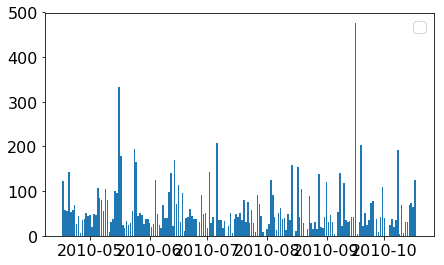

In [100]:
plt.figure()
plt.bar(df_storage_size.index, df_storage_size['Storage size(kWh)'].values)
plt.legend()
plt.show()

<font size="4" color='yellow'>Outliners removal</font>

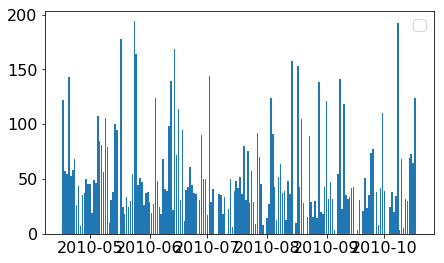

In [101]:
df_storage_size_without_outliners = df_storage_size[df_storage_size['Storage size(kWh)']<200]
plt.figure()
plt.bar(df_storage_size_without_outliners.index, df_storage_size_without_outliners['Storage size(kWh)'].values)
plt.legend()
plt.show()

<font size="4" color='yellow'>Normal Distribution</font>

D:\Programs\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


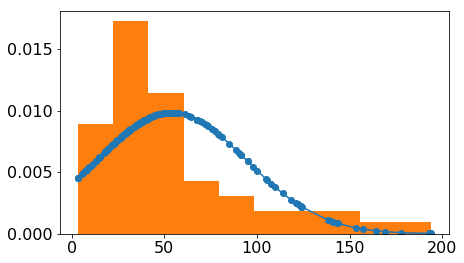

In [102]:
sorted_storage_size = sorted(df_storage_size_without_outliners['Storage size(kWh)'].values)
fit_storage_size = stats.norm.pdf(sorted_storage_size, np.mean(sorted_storage_size), np.std(sorted_storage_size))
plt.plot(sorted_storage_size,fit_storage_size,'-o')
plt.hist(sorted_storage_size,normed=True) #use this to draw histogram of your data
plt.show()

In [103]:
fit_idmax_storage_size = [i for i, j in enumerate(fit_storage_size) if j == max(fit_storage_size)][0]
most_probable_storage_size = df_storage_size_without_outliners[df_storage_size_without_outliners["Storage size(kWh)"].values == sorted_storage_size[fit_idmax_storage_size]]
most_probable_storage_size

,Storage size(kWh)
2010-09-07,54.229366


<font size="5" color='blue'>Transformers</font>

In [104]:
max_consumption_eco_district = df_load_eco_district.max().values[0]
max_consumption_time_eco_district = df_load_eco_district.idxmax()[0].strftime("%Y-%m-%d %H:%M:%S")
print("The max consumption is ", max_consumption_eco_district, "kVA at ", max_consumption_time_eco_district)

The max consumption is  62.234142712 kVA at  2010-01-09 12:00:00


In [105]:
transformers_eco_district = [
    {"Name":"Transformer(1)",'Percentage':100},
]
df_transformers_eco_district = pd.DataFrame(transformers_eco_district, columns=['Name','Percentage'])
df_transformers_eco_district["(kVA)"] = df_transformers_eco_district["Percentage"]/100*max_consumption_eco_district
df_transformers_eco_district["(kW)"] = df_transformers_eco_district["(kVA)"]*.8
df_transformers_eco_district["(kVAr)"] = df_transformers_eco_district["(kVA)"]*math.sin(math.acos(.8))
df_transformers_eco_district.set_index('Name',inplace=True)
df_transformers_eco_district

,Percentage,(kVA),(kW),(kVAr)
Name,,,,
Transformer(1),100,62.234143,49.787314,37.340486


<font size="6" color='red'>Village + Ski-resort + Eco-district</font>

<font size="5" color='blue'>Lines</font>

In [106]:
line_eco_district = {
    "Name":"Line Eco-district",
    "Lenght(km)": 5, 
}
df_lines.loc[line_eco_district['Name']] = [line_eco_district['Lenght(km)'], "", "", "", ""]
df_lines

,Lenght(km),Rated voltage(kV),Cross section(mm2),SC power available: at substation(kV),SC power available: at substation(MVA)
Name,,,,,
Line Overhead,8,20,150,"(63, 20)",500
Line Ski-resort,5,,,,
Line Eco-district,5,,,,


<font size="5" color='blue'>Load</font>

In [107]:
df_load_village_ski_resort_eco_district = pd.DataFrame()
df_load_village_ski_resort_eco_district['Consumption(kW)']=df_load_village["Consumption(kW)"]+df_load_ski_resort["Consumption(kW)"]+df_load_eco_district["Consumption(kW)"]
df_load_village_ski_resort_eco_district.head()

,Consumption(kW)
2010-01-01 00:00:00,1022.983945
2010-01-01 01:00:00,1242.115701
2010-01-01 02:00:00,1125.635133
2010-01-01 03:00:00,1089.477705
2010-01-01 04:00:00,982.389332


<font size="5" color='blue'>Transformers</font>

In [108]:
transformers_eco_district = [
    {"Name":"Transformer(1)",'Percentage':100},
]
df_transformers_eco_district = pd.DataFrame(transformers_eco_district, columns=['Name','Percentage'])
df_transformers_eco_district["(kVA)"] = df_transformers_eco_district["Percentage"]/100*max_consumption_eco_district
df_transformers_eco_district["(kW)"] = df_transformers_eco_district["(kVA)"]*.8
df_transformers_eco_district["(kVAr)"] = df_transformers_eco_district["(kVA)"]*math.sin(math.acos(.8))
df_transformers_eco_district.set_index('Name',inplace=True)
df_transformers_eco_district

,Percentage,(kVA),(kW),(kVAr)
Name,,,,
Transformer(1),100,62.234143,49.787314,37.340486


In [109]:
max_consumption_village_ski_resort_eco_district = df_load_village_ski_resort_eco_district.max().values[0]
max_consumption_time_village_ski_resort_eco_district = df_load_village_ski_resort_eco_district.idxmax()[0].strftime("%Y-%m-%d %H:%M:%S")
print("The max consumption is ", max_consumption_village_ski_resort_eco_district, "kVA at ", max_consumption_time_village_ski_resort_eco_district)

The max consumption is  1744.2701469999997 kVA at  2010-01-09 12:00:00


<font size="5" color='blue'>Diagram</font>

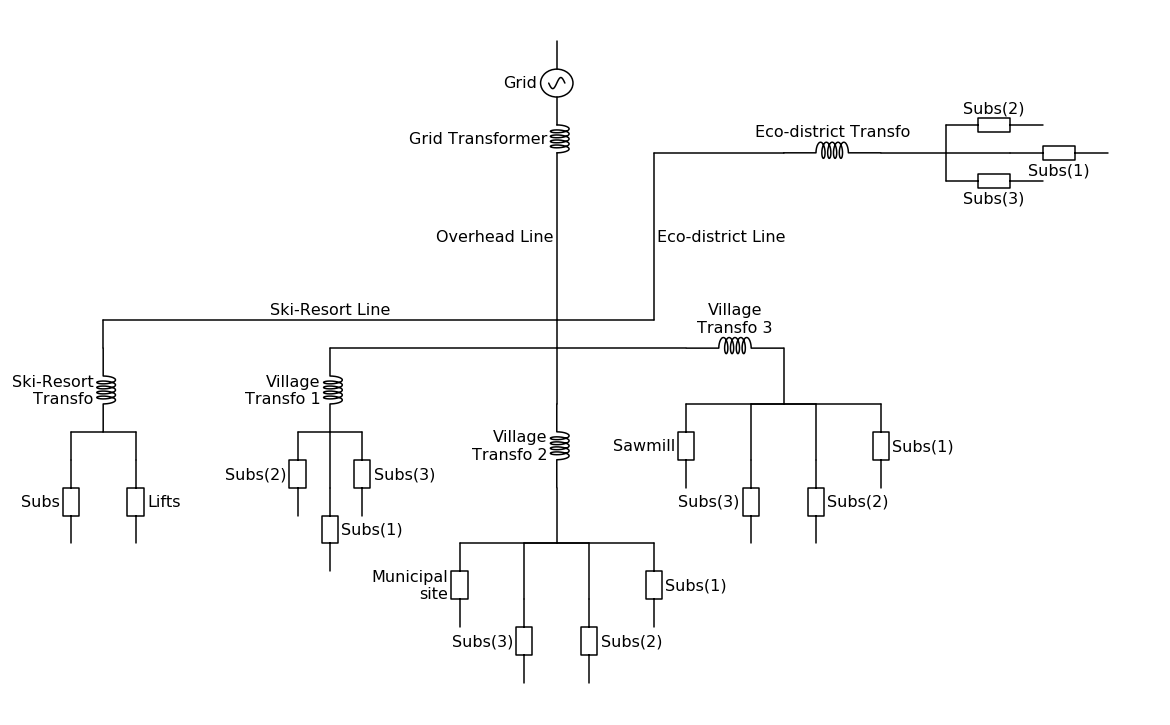

In [110]:
#######################################Eco-district elements#######################################
d.add(e.LINE, d='right', label="", l=3)
d.add(e.LINE, d='up', botlabel="Eco-district Line", l=6)
d.add(e.LINE, d='right', label="", l=4)
d.add(e.INDUCTOR2, label='Eco-district Transfo', l=3)
d.add(e.LINE, d='right', label="", l=2)
##Load 1##
d.push() #save point TRANSFO #1
d.add(e.LINE, d='right', l=2)
d.add(e.RBOX, d='right', botlabel='Subs(1)')
d.pop() #return to the point TRANSFO #1
##Load 2##
d.push() #save point TRANSFO #1
d.add(e.LINE, d='up', l=1)
d.add(e.RBOX, d='right', label='Subs(2)')
d.pop() #return to the point TRANSFO #1
##Load 3##
d.add(e.LINE, d='down', l=1)
d.add(e.RBOX, d='right', botlabel='Subs(3)')
d.draw()
d.save('imgs/line_diagram_2.eps')

<font size="5" color='blue'>Simulation of the Network</font>

In [111]:
####################Eco-district####################
#buses & lines
buses['bus 8'] = pp.create_bus(net, vn_kv=20, name="Line Eco-district")
pp.create_line(net, from_bus=buses['bus 2'], to_bus=buses['bus 8'], length_km=line_eco_district["Lenght(km)"], std_type="NA2XS2Y 1x150 RM/25 12/20 kV", name="Line Eco-district")
#buses, transformers & loads
buses['bus 9'] = pp.create_bus(net, vn_kv=.4, name="Loads Eco-district")
pp.create_transformer(net, hv_bus=buses['bus 8'], lv_bus=buses['bus 9'], std_type="0.63 MVA 20/0.4 kV", name="Transformer Eco-district")
pp.create_load(net, bus=buses['bus 9'], p_mw=df_transformers_eco_district["(kW)"].values[0]/1000, q_mvar=df_transformers_eco_district["(kVAr)"].values[0]/1000, name="Load Eco-district")

4

In [112]:
net.trafo.loc[net.trafo[net.trafo["name"]=="Transformer Grid"].index, "sn_mva"] = max_consumption_village_ski_resort_eco_district*1.5/1000
net.trafo.loc[net.trafo[net.trafo["name"]=="Transformer Eco-district"].index, "sn_mva"] = df_transformers_eco_district[df_transformers_eco_district.index=='Transformer(1)']['(kVA)'].values[0]*1.5/1000

In [113]:
pp.runpp(net)

In [114]:
df_results_lines = net.res_line
df_results_lines.set_index(net.line.name,inplace=True)
df_results_lines

,p_from_mw,q_from_mvar,p_to_mw,q_to_mvar,pl_mw,ql_mvar,i_from_ka,i_to_ka,i_ka,vm_from_pu,va_from_degree,vm_to_pu,va_to_degree,loading_percent
name,,,,,,,,,,,,,,
Line Overhead,1.487165,0.663908,-1.474646,-0.888210,0.012518,-0.224302,0.048793,0.052020,0.052020,0.963547,-4.012977,0.955308,-4.027558,16.307129
Line Ski-resort,0.114644,-0.052920,-0.114606,-0.090361,0.000038,-0.143281,0.003816,0.004412,0.004412,0.955308,-4.027558,0.954971,-4.034965,1.382977
Line Eco-district,0.051850,-0.103073,-0.051840,-0.040261,0.000010,-0.143333,0.003487,0.001984,0.003487,0.955308,-4.027558,0.955216,-4.037355,1.092960


In [115]:
df_results_transformers = net.res_trafo
df_results_transformers.set_index(net.trafo.name,inplace=True)
df_results_transformers

,p_hv_mw,q_hv_mvar,p_lv_mw,q_lv_mvar,pl_mw,ql_mvar,i_hv_ka,i_lv_ka,vm_hv_pu,va_hv_degree,vm_lv_pu,va_lv_degree,loading_percent
name,,,,,,,,,,,,,
Transformer Grid,1.505152,0.795823,-1.487165,-0.663908,0.017987,0.131915,0.015603,0.048793,1.000000,0.000000,0.963547,-4.012977,65.073679
Transformer Village 1,0.522970,0.418019,-0.515407,-0.386555,0.007563,0.031464,0.020231,1.008196,0.955308,-4.027558,0.922347,-5.754698,72.520209
Transformer Village 2,0.522970,0.418019,-0.515407,-0.386555,0.007563,0.031464,0.020231,1.008196,0.955308,-4.027558,0.922347,-5.754698,72.520209
Transformer Village 3,0.262212,0.208165,-0.257703,-0.193278,0.004509,0.014888,0.010117,0.504073,0.955308,-4.027558,0.922393,-5.758071,72.529477
Transformer Ski-resort,0.114606,0.090361,-0.111821,-0.083866,0.002786,0.006495,0.004412,0.218813,0.954971,-4.034965,0.922015,-5.774193,72.890715
Transformer Eco-district,0.051840,0.040261,-0.049787,-0.037340,0.002053,0.002920,0.001984,0.097405,0.955216,-4.037355,0.922208,-5.792056,73.609007


In [116]:
sc.calc_sc(net, case="max", ip=True)

In [117]:
df_results_sc_bus = net.res_bus_sc
df_results_sc_bus.set_index(net.bus.name,inplace=True)
df_results_sc_bus

,ikss_ka,ip_ka
name,,
Connection Grid,4.582145,11.314322
Line Overhead,0.676969,1.815530
Village,0.640949,1.545711
Load Village 1,14.161293,32.321280
Load Village 2,14.161293,32.321280
Load Village 3,9.085124,20.429523
Line Ski-resort,0.618476,1.412021
Load Ski-resort,4.667335,10.289671
Line Eco-district,0.618476,1.412021
